# 02 - ***Linear Algebra: Gradient Boosting*** - Car Price Prediction

### Project Description 
The client company which distributes automobiles, is developing an application for lead generation at the moment. The objective of data science project is to build a machine learning model for defining a car price in order to put a correct price to the app.

### Project Design

- Data quality evaluation, data pre-processing.
- As a quality metric we use RMSE.
- For modeling we use the Python library ***lightGBM*** for **gradient boosting**.

- For gradient boosting we use built-in Python  library LightGBM.


### Features in the data

•	***DateCrawled*** — date of downloading the profile from the database

•	***VehicleType*** — vehicle body type

•	***RegistrationYear*** — year of vehicle registration

•	***Gearbox*** — type of gearbox

•	***Power*** — power (hp)

•	***Model*** — car model

•	***Kilometer*** — mileage (km)

•	***RegistrationMonth*** — month of vehicle registration

•	***FuelType*** — type of fuel

•	Brand — car brand

•	NotRepaired — Was the car under repair? Yes / No

•	DateCreated — date of creation of the questionnaire

•	NumberOfPictures — the number of photos of the car

•	PostalCode — postal code of the owner of the questionnaire (user)

•	LastSeen — date of last user activity

### Target 
- price - price of the car (in euro)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import warnings

sb.set_style('whitegrid')
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

# 1 Data pre-processing

In [4]:
data = pd.read_csv('/Users/yuliabezginova/PycharmProjects/02_LA_CarPricePrediction/autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.shape

(354369, 16)

## 1.1 Loading and understanding the data

In [7]:
pip install -q pandas-profiling


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/3.4.8/libexec/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install -q ipywidgets


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/3.4.8/libexec/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from pandas_profiling import ProfileReport

In [147]:
# report = ProfileReport(data)
# report

## 1.2 Checking the dataset for missing values

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

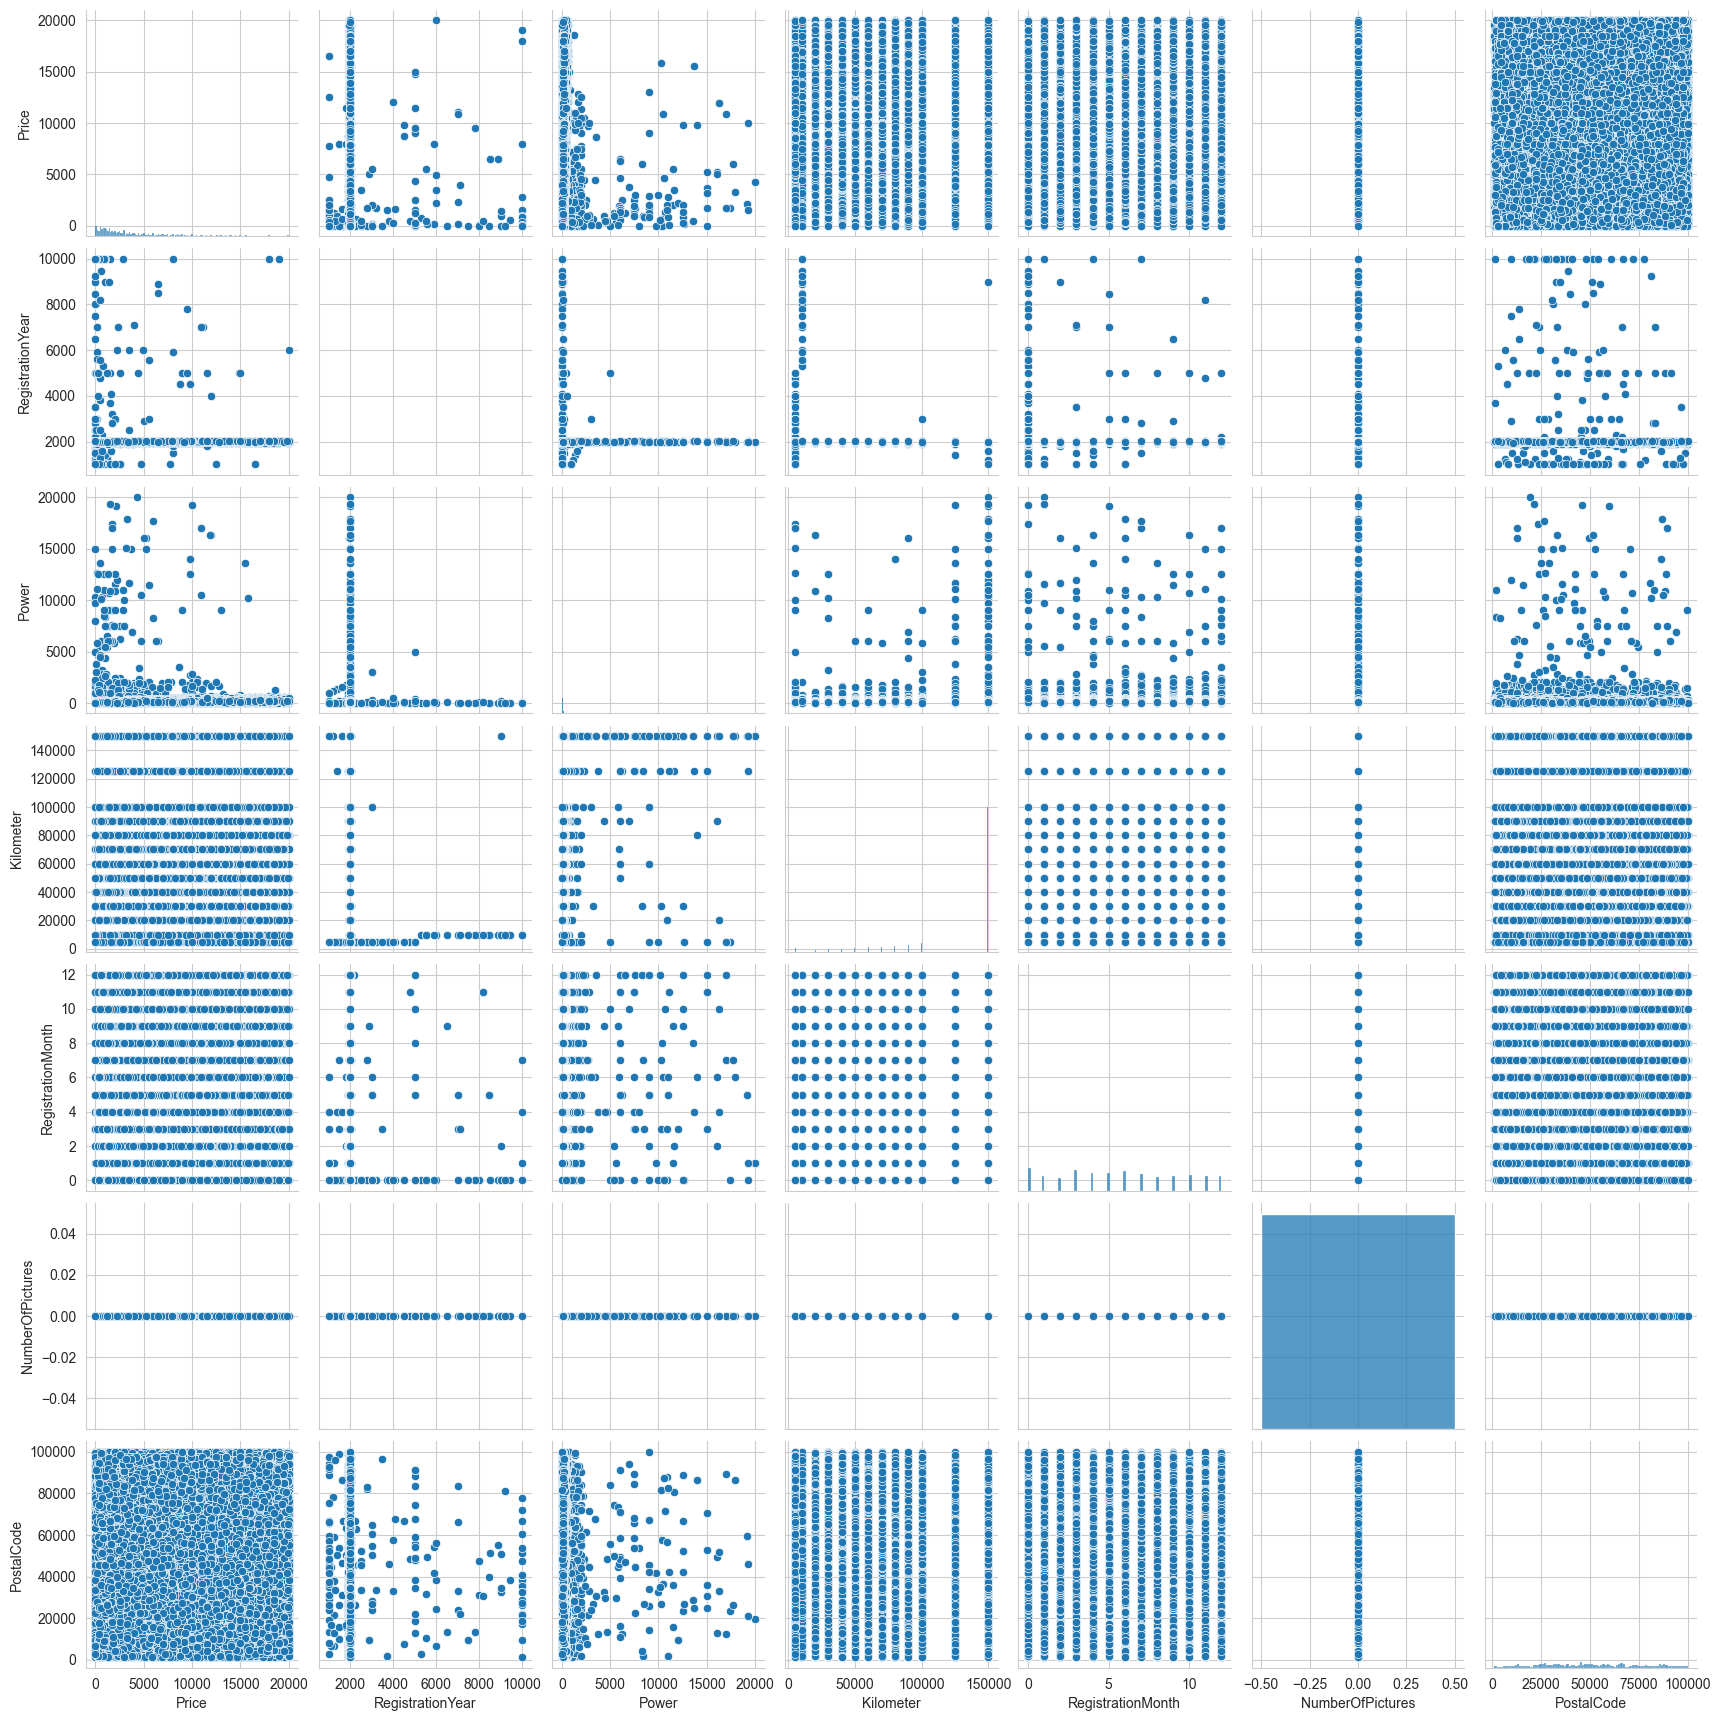

In [5]:
sb.pairplot(data);

In [6]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


### ***Conclusion:*** as long as there are categorical data which contains missing, it is reasonable to fill the missings out by the most frequent values in each column ('mode').

In [12]:
data["VehicleType"] = data["VehicleType"].fillna(data["VehicleType"].mode().values[0])
data["Gearbox"] = data["Gearbox"].fillna(data["Gearbox"].mode().values[0])
data["Model"] = data["Model"].fillna(data["Model"].mode().values[0])
data["FuelType"] = data["FuelType"].fillna(data["FuelType"].mode().values[0])

# если ячейка не заполнена, логично предположить, что ремонта не было - пропуски заполняем 'no'
data["Repaired"] = data["Repaired"].fillna("no")

In [13]:
# checking the results
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


#### Conclusion: missings are gone, we can proceed.

## 1.3 Checking for dublicates

In [14]:
# taking the columns names' list
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [15]:
check_col = ['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']
for col in check_col:
    print(col, pd.Series(data[col].unique()).duplicated().sum())

DateCrawled 0
Price 0
VehicleType 0
RegistrationYear 0
Gearbox 0
Power 0
Model 0
Kilometer 0
RegistrationMonth 0
FuelType 0
Brand 0
Repaired 0
DateCreated 0
NumberOfPictures 0
PostalCode 0
LastSeen 0


In [16]:
data.duplicated().sum()

5

In [17]:
data = data.drop_duplicates()

In [18]:
data.duplicated().sum()

0

#### Conclusion: dublicates are gone, we can proceed.

### 1.3.1 Removing the columns, which are needed for modelling

In [19]:
data_final = data.copy()

In [20]:
data_final = data_final.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures','PostalCode'],axis = 1)

In [21]:
data_final.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [22]:
# lowering all string names in the dataset
data_final.columns = data_final.columns.str.lower()

In [23]:
data_final.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [24]:
data_final.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired'],
      dtype='object')

<div class="alert alert-block alert-warning">
<b>⚠️ Совет:</b> 

Для удобства в дальнейшем анализе можно названия столбцов привести в более читаемый стиль snake_case. Здесь мы используем регулярные выражения.

Полезная <a href='https://habr.com/ru/post/545150/'>статья</a> про regex для начала
    
Этот блогер хорошо объясняет в своем <a href='https://www.youtube.com/watch?v=sHw5hLYFaIw&t=247s'>видео</a>
</div>

```python
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
```
</div>

In [25]:
# checking the current output
temp = data_final.copy() 
list_c = ['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354364 non-null  int64 
 1   vehicletype        354364 non-null  object
 2   registrationyear   354364 non-null  int64 
 3   gearbox            354364 non-null  object
 4   power              354364 non-null  int64 
 5   model              354364 non-null  object
 6   kilometer          354364 non-null  int64 
 7   registrationmonth  354364 non-null  int64 
 8   fueltype           354364 non-null  object
 9   brand              354364 non-null  object
 10  repaired           354364 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB
None
-------------------------
price [    0     1     2 ... 19998 19999 20000]
price : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
vehicletype ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'su

fueltype ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol']
fueltype : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
brand ['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']
brand : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
repaired ['no' 'yes']
repaired : кол-во NaN 0 , процент NaN 0.0 %


#### Conclusion: good, the dataset is clean, we can proceed.

## 1.4 Working with outliers

In [26]:
data_final.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641
std,4514.159690,90.228593,189.851590,37905.136957,3.726433
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [27]:
# renaming some columns' names

data_final = data_final.rename(columns={
    'vehicletype' : 'vehicle_type', 
    'registrationyear' : 'reg_year', 
       'kilometer': 'km', 
    'registrationmonth' : 'reg_month', 
    'fueltype': 'fuel_type'
})

In [28]:
data_final.describe()

,price,reg_year,power,km,reg_month
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641
std,4514.159690,90.228593,189.851590,37905.136957,3.726433
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


***Conclusion:*** 
- the median heavily differ from the mean value in the colum 'price', which mean there are signifincat outliers in the column;

- also, the column 'reg_year' contains wierd values like 1000, which is not possible for the registration year value;

- also, the column 'power' contains outliers, since it is not possible to have a car with power = 0.

In [29]:
data_final['price'].hist(bins=50, figsize=(13, 9));

In [30]:
data_final['reg_year'].hist(bins=50, figsize=(13, 9));

In [31]:
data_final['power'].hist(bins=50, figsize=(13, 9));

## 1.5  Removing outliers in ***'price'*** and ***'power'*** columns

In [32]:
# writing a function for outliers removal
def remove_ouliers(data, column):
    q25=np.array(data[column].quantile(0.25))
    q75=np.array(data[column].quantile(0.75))
    
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    
    del_index = []
    for index_value, value in zip(data[column].index, data[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Number of rows for removal:' + str(column)+":",
          len(del_index))
    return del_index

In [33]:
# checking the descriptive statistics for 'power' column
print(data_final['power'].min())

0


In [34]:
# checking the descriptive statistics for 'power' column
print(data_final['power'].max())

20000


In [35]:
# checking the descriptive statistics for 'power' column
print(data_final['power'].mode())

0    0
Name: power, dtype: int64


In [36]:
# filling the ouliers in column 'power'
data_final.loc[data_final['power'] > 3500, 'power'] = 3500
data_final.loc[data_final['power'] < 100, 'power'] = 100

In [37]:
# removing outliers

array_num_col = ['price', 'power']
count = 0 
for column in array_num_col:
    index_del = remove_ouliers(data_final, column)
    count += len(index_del)
    data_final = data_final.drop(index_del,axis = 0)
print('Removed:', count)

Number of rows for removal:price: 18979
Number of rows for removal:power: 18761
Removed: 37740


## 1.6  Removing outliers in 'reg_year' and 'reg_month' columns

In [38]:
# reg_year [2016 : 2022]
def reg_year_outliers(value):
    if value >= 2022:
        return 2022
    elif value <=2016:
        return 2016
    else:
        return value

In [39]:
# reg_year
data_final['reg_year'] = data_final['reg_year'].apply(reg_year_outliers)

In [40]:
# reg_month
data_final.loc[data_final['reg_month'] == 0, 'reg_month'] = 1

In [41]:
data_final.describe()

,price,reg_year,power,km,reg_month
count,316624.000000,316624.000000,316624.000000,316624.000000,316624.000000
mean,3481.164368,2016.056629,117.407486,129705.660342,5.766534
std,3305.724332,0.293748,25.274596,36734.881748,3.583524
min,0.000000,2016.000000,100.000000,5000.000000,1.000000
25%,999.000000,2016.000000,100.000000,125000.000000,3.000000
50%,2300.000000,2016.000000,101.000000,150000.000000,6.000000
75%,4999.000000,2016.000000,131.000000,150000.000000,9.000000
max,14400.000000,2022.000000,199.000000,150000.000000,12.000000


### 1.7  Проверим признаки на мультиколлинеарность

In [42]:
data_final.corr()

,price,reg_year,power,km,reg_month
price,1.000000,-0.041873,0.369308,-0.307265,0.106111
reg_year,-0.041873,1.000000,-0.049661,-0.002991,-0.046121
power,0.369308,-0.049661,1.000000,0.133318,0.066036
km,-0.307265,-0.002991,0.133318,1.000000,0.013966
reg_month,0.106111,-0.046121,0.066036,0.013966,1.000000


# 2  Обучение моделей

## 2.1 Spliting the data into three subsamples for three different purposes: training and testing.

```
As a benchmark, we split the sample in the proportion as follows:
- 60% train_data
- 20% validation_data
- 20% test_data

```

In [43]:
train_data, other_data = train_test_split(data_final, test_size=0.30, random_state=5)
validation_data, test_data = train_test_split(other_data, test_size=0.70, random_state=5)

print('Train sample size:', train_data.shape[0])
print('Validation sample size:', validation_data.shape[0])
print('Test sample size:', test_data.shape[0])

Train sample size: 221636
Validation sample size: 28496
Test sample size: 66492


## 2.2 Coding variables using OHE process as long as we are having _linear models_

**One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.**

Check out [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?ref=hackernoon.com) for more details about OHE.

***Applying OHE and saving a new dataset for further analysis. Also, trying to use OrdinalEncoder() to reduce the execution time.***

In [44]:
# One-Hot Encoding
train_data_ohe = pd.get_dummies(train_data, drop_first=True)
validation_data_ohe = pd.get_dummies(validation_data, drop_first=True)
test_data_ohe = pd.get_dummies(test_data, drop_first=True)

<div class="alert alert-block alert-warning">
<b>FYI</b>
    
OHE coding better to do before data split, not after. Otherwise, there can be data leakage.

More about data leakage: https://datascience.stackexchange.com/questions/108663/why-label-encoding-before-split-is-data-leakage

In [45]:
# сформируем две выборки для обучения, валидации и тестирования - целевую и признаки
X_train = train_data_ohe.drop(['price'], axis=1)
y_train = train_data_ohe['price']

X_valid = validation_data_ohe.drop(['price'], axis=1)
y_valid = validation_data_ohe['price']

X_test = test_data_ohe.drop(['price'], axis=1)
y_test = test_data_ohe['price']

In [46]:
print('Train features sample size:', X_train.shape[0])
print('Train target sample size:', y_train.shape[0])
print()
print('Test features sample size:', X_test.shape[0])
print('Test target sample size:', y_test.shape[0])

Train features sample size: 221636
Train target sample size: 221636

Test features sample size: 66492
Test target sample size: 66492


In [47]:
print('Validation features sample size:', X_valid.shape[0])
print('Validation target sample size:', y_valid.shape[0])

Validation features sample size: 28496
Validation target sample size: 28496


In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221636 entries, 293759 to 333391
Columns: 305 entries, reg_year to repaired_yes
dtypes: int64(4), uint8(301)
memory usage: 72.1 MB


In [49]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28496 entries, 182485 to 219315
Columns: 289 entries, reg_year to repaired_yes
dtypes: int64(4), uint8(285)
memory usage: 8.8 MB


In [50]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66492 entries, 294936 to 29353
Columns: 300 entries, reg_year to repaired_yes
dtypes: int64(4), uint8(296)
memory usage: 21.3 MB


<div class="alert alert-block alert-info">
<b>FYI:</b> If after coding there are different number of columns in X_train (306), X_valid (299), X_test (300), it means in initial datasets there are different number of unique columns. Some features can be deleted, other (necessary ones) can be added.
</div>

## 2.3  Coding categorical variables with OrdinalEncoder()

***Modelling gradient boosting, decision tree, random forest takes a while. To speed up the process a bit, it is worth to use OrdinalEncoding() instead of OHE - coded data this way learns faster.***

In [51]:
from sklearn.preprocessing import OrdinalEncoder

In [52]:
ord_enc = OrdinalEncoder()

In [53]:
# coding only categorical variables
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221636 entries, 293759 to 333391
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         221636 non-null  int64 
 1   vehicle_type  221636 non-null  object
 2   reg_year      221636 non-null  int64 
 3   gearbox       221636 non-null  object
 4   power         221636 non-null  int64 
 5   model         221636 non-null  object
 6   km            221636 non-null  int64 
 7   reg_month     221636 non-null  int64 
 8   fuel_type     221636 non-null  object
 9   brand         221636 non-null  object
 10  repaired      221636 non-null  object
dtypes: int64(5), object(6)
memory usage: 20.3+ MB


In [54]:
train_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(train_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [55]:
validation_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(validation_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [56]:
test_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(test_data[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [57]:
# after Ordinal Encoding we can split the dataset for further modeling
X_train_ord = train_data.drop(['price'], axis=1)
y_train_ord = train_data['price']

X_valid_ord = validation_data.drop(['price'], axis=1)
y_valid_ord = validation_data['price']

X_test_ord = test_data.drop(['price'], axis=1)
y_test_ord = test_data['price']

## 2.4  Preparing dataset for gradient boosting

In [58]:
# preparing dataset for gradient boosting models
data_boost = data_final.copy()
data_boost = data_boost.astype({'vehicle_type' : 'category',
                                                'gearbox' : 'category',
                                                'model' : 'category',
                                                'fuel_type' : 'category',
                                                'brand' : 'category',
                                                'repaired' : 'category'})

In [59]:
train_data_boost, other_data_boost = train_test_split(data_boost, test_size=0.30, random_state=5)
validation_data_boost, test_data_boost = train_test_split(other_data_boost, test_size=0.70, random_state=5)

print('Train sample size:', train_data_boost.shape[0])
print('Validation sample size:', validation_data_boost.shape[0])
print('Test sample size:', test_data_boost.shape[0])

Train sample size: 221636
Validation sample size: 28496
Test sample size: 66492


In [60]:
# train_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(train_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [61]:
# validation_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(validation_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [62]:
# test_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']] = ord_enc.fit_transform(test_data_boost[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']])

In [63]:
# сформируем две выборки для обучения, валидации и тестирования - целевую и признаки - для градиентного бустинга
X_train_boost = train_data_boost.drop(['price'], axis=1)
y_train_boost = train_data_boost['price']

X_valid_boost = validation_data_boost.drop(['price'], axis=1)
y_valid_boost = validation_data_boost['price']

X_test_boost = test_data_boost.drop(['price'], axis=1)
y_test_boost = test_data_boost['price']

print('Train features sample size:', X_train_boost.shape[0])
print('Test target sample size:', y_train_boost.shape[0])
print()
print('Validation features sample size:', X_valid_boost.shape[0])
print('Validation target sample size:', y_valid_boost.shape[0])
print()
print('Test features sample size:', X_test_boost.shape[0])
print('Test target sample size:', y_test_boost.shape[0])

Train features sample size: 221636
Test target sample size: 221636

Validation features sample size: 28496
Validation target sample size: 28496

Test features sample size: 66492
Test target sample size: 66492


#### Conclusion: data was split into 6 subsamples 60/20/20 for training and testing purposes.

## 2.5  Training the ML models

### 2.5.1 Changing type of variables in ***train, valid, test samples***

In [66]:
# changing the type of variables
X_train_ord['model'] = np.floor(pd.to_numeric(X_train_ord['model'], errors='coerce')).astype('float64')
X_train_ord['brand'] = np.floor(pd.to_numeric(X_train_ord['brand'], errors='coerce')).astype('float64')

X_valid_ord['model'] = np.floor(pd.to_numeric(X_valid_ord['model'], errors='coerce')).astype('float64')
X_valid_ord['brand'] = np.floor(pd.to_numeric(X_valid_ord['brand'], errors='coerce')).astype('float64')

X_test_ord['model'] = np.floor(pd.to_numeric(X_test_ord['model'], errors='coerce')).astype('float64')
X_test_ord['brand'] = np.floor(pd.to_numeric(X_test_ord['brand'], errors='coerce')).astype('float64')

# X_train_boost['model'] = np.floor(pd.to_numeric(X_train_boost['model'], errors='coerce')).astype('float64')
# X_train_boost['brand'] = np.floor(pd.to_numeric(X_train_boost['brand'], errors='coerce')).astype('float64')

# X_valid_boost['model'] = np.floor(pd.to_numeric(X_valid_boost['model'], errors='coerce')).astype('float64')
# X_valid_boost['brand'] = np.floor(pd.to_numeric(X_valid_boost['brand'], errors='coerce')).astype('float64')

# X_test_boost['model'] = np.floor(pd.to_numeric(X_test_boost['model'], errors='coerce')).astype('float64')
# X_test_boost['brand'] = np.floor(pd.to_numeric(X_test_boost['brand'], errors='coerce')).astype('float64')

In [67]:
X_train = np.nan_to_num(X_train)
X_valid = np.nan_to_num(X_valid)
X_test = np.nan_to_num(X_test)

y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)
y_test = np.nan_to_num(y_test)

In [68]:
X_train_ord = np.nan_to_num(X_train_ord)
X_valid_ord = np.nan_to_num(X_valid_ord)
X_test_ord = np.nan_to_num(X_test_ord)

y_train_ord = np.nan_to_num(y_train_ord)
y_valid_ord = np.nan_to_num(y_valid_ord)
y_test_ord = np.nan_to_num(y_test_ord)

In [69]:
# X_train_boost = np.nan_to_num(X_train_boost)
# X_valid_boost = np.nan_to_num(X_valid_boost)
# X_test_boost = np.nan_to_num(X_test_boost)

# y_train_boost = np.nan_to_num(y_train_boost)
# y_valid_boost = np.nan_to_num(y_valid_boost)
# y_test_boost = np.nan_to_num(y_test_boost)

In [70]:
# # changing the type of variables
# X_train_ord['model'] = np.floor(pd.to_numeric(X_train_ord['model'], errors='coerce')).astype('float64')
# X_train_ord['brand'] = np.floor(pd.to_numeric(X_train_ord['brand'], errors='coerce')).astype('float64')

# X_valid_ord['model'] = np.floor(pd.to_numeric(X_valid_ord['model'], errors='coerce')).astype('float64')
# X_valid_ord['brand'] = np.floor(pd.to_numeric(X_valid_ord['brand'], errors='coerce')).astype('float64')

# X_test_ord['model'] = np.floor(pd.to_numeric(X_test_ord['model'], errors='coerce')).astype('float64')
# X_test_ord['brand'] = np.floor(pd.to_numeric(X_test_ord['brand'], errors='coerce')).astype('float64')

#### Сравним, как обучаются модели Decision Tree Regressor, Random Forest Regressor, Dummy Regressor, lightGBM. 

***Using GridSearchCV in order to find best possible hyperparameters for the models - CatBoostRegressor (Pool), Decision Tree (DT), Random Forest (RF), Dummy Regressor, Gradient boosting (lightGBM).***

### 2.5.2 Cat Boost Regressor

In [73]:
%%time
# catboost
catboost = CatBoostRegressor(loss_function='RMSE')

parameters_boost = {'depth': [5, 10], 'learning_rate': np.arange(0.1,1,0.2)}

catboost_grid = catboost.grid_search(parameters_boost,
            Pool(X_train_boost, y_train_boost, cat_features=['vehicle_type',
                                                'gearbox',
                                                'model',
                                                'fuel_type',
                                                'brand',
                                                'repaired']),
            cv=3,
            verbose=False,
            plot=False)

0:	learn: 4452.4113461	test: 4470.6348982	best: 4470.6348982 (0)	total: 106ms	remaining: 1m 46s
1:	learn: 4153.8937241	test: 4170.8499474	best: 4170.8499474 (1)	total: 200ms	remaining: 1m 39s
2:	learn: 3891.9482503	test: 3908.1358783	best: 3908.1358783 (2)	total: 291ms	remaining: 1m 36s
3:	learn: 3667.7249105	test: 3683.9580091	best: 3683.9580091 (3)	total: 402ms	remaining: 1m 40s
4:	learn: 3472.9252958	test: 3488.2505365	best: 3488.2505365 (4)	total: 495ms	remaining: 1m 38s
5:	learn: 3303.7269245	test: 3317.9545176	best: 3317.9545176 (5)	total: 583ms	remaining: 1m 36s
6:	learn: 3156.7037277	test: 3169.4166834	best: 3169.4166834 (6)	total: 699ms	remaining: 1m 39s
7:	learn: 3030.4811091	test: 3041.7391609	best: 3041.7391609 (7)	total: 814ms	remaining: 1m 40s
8:	learn: 2919.3618940	test: 2929.7938537	best: 2929.7938537 (8)	total: 930ms	remaining: 1m 42s
9:	learn: 2823.3291632	test: 2833.8967836	best: 2833.8967836 (9)	total: 1.06s	remaining: 1m 45s
10:	learn: 2744.3555063	test: 2754.18501

84:	learn: 2103.1529051	test: 2099.7337385	best: 2099.7337385 (84)	total: 7.21s	remaining: 1m 17s
85:	learn: 2102.0253676	test: 2098.6158237	best: 2098.6158237 (85)	total: 7.41s	remaining: 1m 18s
86:	learn: 2101.0396771	test: 2097.6220395	best: 2097.6220395 (86)	total: 7.52s	remaining: 1m 18s
87:	learn: 2100.2733452	test: 2096.9236193	best: 2096.9236193 (87)	total: 7.61s	remaining: 1m 18s
88:	learn: 2099.1709910	test: 2095.7253328	best: 2095.7253328 (88)	total: 7.7s	remaining: 1m 18s
89:	learn: 2097.1804938	test: 2093.2699340	best: 2093.2699340 (89)	total: 7.8s	remaining: 1m 18s
90:	learn: 2096.1421820	test: 2092.1838995	best: 2092.1838995 (90)	total: 7.91s	remaining: 1m 18s
91:	learn: 2094.8277615	test: 2090.8633238	best: 2090.8633238 (91)	total: 8.01s	remaining: 1m 19s
92:	learn: 2093.4678440	test: 2089.5000727	best: 2089.5000727 (92)	total: 8.09s	remaining: 1m 18s
93:	learn: 2092.7535399	test: 2088.6906804	best: 2088.6906804 (93)	total: 8.17s	remaining: 1m 18s
94:	learn: 2091.613486

170:	learn: 2030.2394871	test: 2025.8905218	best: 2025.8905218 (170)	total: 14.8s	remaining: 1m 11s
171:	learn: 2029.8185508	test: 2025.4488175	best: 2025.4488175 (171)	total: 14.8s	remaining: 1m 11s
172:	learn: 2029.4269679	test: 2025.1924636	best: 2025.1924636 (172)	total: 14.9s	remaining: 1m 11s
173:	learn: 2028.9664765	test: 2024.5685060	best: 2024.5685060 (173)	total: 15s	remaining: 1m 11s
174:	learn: 2028.5390670	test: 2024.1435175	best: 2024.1435175 (174)	total: 15.1s	remaining: 1m 10s
175:	learn: 2028.1883501	test: 2023.7357960	best: 2023.7357960 (175)	total: 15.1s	remaining: 1m 10s
176:	learn: 2027.8833397	test: 2023.4950676	best: 2023.4950676 (176)	total: 15.2s	remaining: 1m 10s
177:	learn: 2027.2646474	test: 2022.9597470	best: 2022.9597470 (177)	total: 15.3s	remaining: 1m 10s
178:	learn: 2026.9066395	test: 2022.7102937	best: 2022.7102937 (178)	total: 15.4s	remaining: 1m 10s
179:	learn: 2026.6016742	test: 2022.3875067	best: 2022.3875067 (179)	total: 15.4s	remaining: 1m 10s
18

253:	learn: 1994.0500615	test: 1991.9769330	best: 1991.9769330 (253)	total: 20.7s	remaining: 1m
254:	learn: 1993.4447888	test: 1991.3719725	best: 1991.3719725 (254)	total: 20.8s	remaining: 1m
255:	learn: 1993.2765887	test: 1991.2792093	best: 1991.2792093 (255)	total: 20.8s	remaining: 1m
256:	learn: 1992.8447019	test: 1990.8181884	best: 1990.8181884 (256)	total: 20.9s	remaining: 1m
257:	learn: 1992.4954476	test: 1990.4756825	best: 1990.4756825 (257)	total: 21s	remaining: 1m
258:	learn: 1992.1548302	test: 1990.1572679	best: 1990.1572679 (258)	total: 21.1s	remaining: 1m
259:	learn: 1991.8372010	test: 1989.8866669	best: 1989.8866669 (259)	total: 21.1s	remaining: 1m
260:	learn: 1991.6895657	test: 1989.7122091	best: 1989.7122091 (260)	total: 21.2s	remaining: 1m
261:	learn: 1991.4864513	test: 1989.6426028	best: 1989.6426028 (261)	total: 21.3s	remaining: 59.9s
262:	learn: 1991.1479562	test: 1989.4830603	best: 1989.4830603 (262)	total: 21.4s	remaining: 59.8s
263:	learn: 1990.8577338	test: 1989.

338:	learn: 1970.5699307	test: 1971.5111115	best: 1971.5111115 (338)	total: 26.5s	remaining: 51.8s
339:	learn: 1970.2744792	test: 1971.2433488	best: 1971.2433488 (339)	total: 26.6s	remaining: 51.6s
340:	learn: 1970.0420660	test: 1971.0579642	best: 1971.0579642 (340)	total: 26.7s	remaining: 51.5s
341:	learn: 1969.9876989	test: 1970.9914079	best: 1970.9914079 (341)	total: 26.7s	remaining: 51.4s
342:	learn: 1969.5240237	test: 1970.6279858	best: 1970.6279858 (342)	total: 26.8s	remaining: 51.3s
343:	learn: 1969.0673139	test: 1970.2812357	best: 1970.2812357 (343)	total: 26.9s	remaining: 51.2s
344:	learn: 1968.9270603	test: 1970.1811382	best: 1970.1811382 (344)	total: 26.9s	remaining: 51.1s
345:	learn: 1968.6183380	test: 1969.9194006	best: 1969.9194006 (345)	total: 27s	remaining: 51s
346:	learn: 1968.4402579	test: 1969.7190948	best: 1969.7190948 (346)	total: 27s	remaining: 50.9s
347:	learn: 1967.9953842	test: 1969.3259461	best: 1969.3259461 (347)	total: 27.1s	remaining: 50.8s
348:	learn: 1967

423:	learn: 1950.5562027	test: 1954.6190818	best: 1954.6190818 (423)	total: 32.5s	remaining: 44.1s
424:	learn: 1950.3924022	test: 1954.5537574	best: 1954.5537574 (424)	total: 32.5s	remaining: 44s
425:	learn: 1950.1898305	test: 1954.4669599	best: 1954.4669599 (425)	total: 32.6s	remaining: 43.9s
426:	learn: 1950.1259386	test: 1954.4014036	best: 1954.4014036 (426)	total: 32.7s	remaining: 43.8s
427:	learn: 1949.9965983	test: 1954.2939222	best: 1954.2939222 (427)	total: 32.7s	remaining: 43.7s
428:	learn: 1949.8429409	test: 1954.1349152	best: 1954.1349152 (428)	total: 32.8s	remaining: 43.7s
429:	learn: 1949.6094105	test: 1953.8424376	best: 1953.8424376 (429)	total: 32.9s	remaining: 43.6s
430:	learn: 1949.5191262	test: 1953.7827067	best: 1953.7827067 (430)	total: 33s	remaining: 43.5s
431:	learn: 1949.4773778	test: 1953.7651861	best: 1953.7651861 (431)	total: 33s	remaining: 43.4s
432:	learn: 1949.2714598	test: 1953.6681509	best: 1953.6681509 (432)	total: 33.1s	remaining: 43.3s
433:	learn: 1948

508:	learn: 1935.6043654	test: 1941.8553226	best: 1941.8553226 (508)	total: 39.5s	remaining: 38.1s
509:	learn: 1935.5160024	test: 1941.7750990	best: 1941.7750990 (509)	total: 39.5s	remaining: 38s
510:	learn: 1935.3660687	test: 1941.7012945	best: 1941.7012945 (510)	total: 39.6s	remaining: 37.9s
511:	learn: 1935.0793332	test: 1941.3358913	best: 1941.3358913 (511)	total: 39.7s	remaining: 37.8s
512:	learn: 1934.9320557	test: 1941.1715923	best: 1941.1715923 (512)	total: 39.8s	remaining: 37.8s
513:	learn: 1934.7593029	test: 1940.9868749	best: 1940.9868749 (513)	total: 39.9s	remaining: 37.7s
514:	learn: 1934.6786100	test: 1940.9181772	best: 1940.9181772 (514)	total: 39.9s	remaining: 37.6s
515:	learn: 1934.4101800	test: 1940.6791329	best: 1940.6791329 (515)	total: 40s	remaining: 37.5s
516:	learn: 1934.3327106	test: 1940.6485485	best: 1940.6485485 (516)	total: 40s	remaining: 37.4s
517:	learn: 1934.1571008	test: 1940.4926139	best: 1940.4926139 (517)	total: 40.1s	remaining: 37.3s
518:	learn: 1934

592:	learn: 1924.2843309	test: 1932.5621563	best: 1932.5550618 (590)	total: 53.1s	remaining: 36.5s
593:	learn: 1924.1784104	test: 1932.5097401	best: 1932.5097401 (593)	total: 53.2s	remaining: 36.4s
594:	learn: 1923.9755232	test: 1932.3757275	best: 1932.3757275 (594)	total: 53.2s	remaining: 36.3s
595:	learn: 1923.9494972	test: 1932.3407123	best: 1932.3407123 (595)	total: 53.3s	remaining: 36.2s
596:	learn: 1923.7496235	test: 1932.0993396	best: 1932.0993396 (596)	total: 53.4s	remaining: 36.1s
597:	learn: 1923.6265311	test: 1932.0562902	best: 1932.0562902 (597)	total: 53.5s	remaining: 36s
598:	learn: 1923.4313195	test: 1931.9273593	best: 1931.9273593 (598)	total: 53.6s	remaining: 35.9s
599:	learn: 1923.1707395	test: 1931.7798843	best: 1931.7798843 (599)	total: 53.7s	remaining: 35.8s
600:	learn: 1923.0899490	test: 1931.7475151	best: 1931.7475151 (600)	total: 53.8s	remaining: 35.8s
601:	learn: 1922.7850876	test: 1931.2842987	best: 1931.2842987 (601)	total: 53.9s	remaining: 35.7s
602:	learn: 

678:	learn: 1913.9834219	test: 1924.4967118	best: 1924.4967118 (678)	total: 1m 4s	remaining: 30.4s
679:	learn: 1913.8805927	test: 1924.4456979	best: 1924.4456979 (679)	total: 1m 4s	remaining: 30.3s
680:	learn: 1913.8706938	test: 1924.4429835	best: 1924.4429835 (680)	total: 1m 4s	remaining: 30.2s
681:	learn: 1913.8225641	test: 1924.4089696	best: 1924.4089696 (681)	total: 1m 4s	remaining: 30.1s
682:	learn: 1913.7267028	test: 1924.3874712	best: 1924.3874712 (682)	total: 1m 4s	remaining: 30s
683:	learn: 1913.6532555	test: 1924.4053509	best: 1924.3874712 (682)	total: 1m 4s	remaining: 29.9s
684:	learn: 1913.6372696	test: 1924.4186448	best: 1924.3874712 (682)	total: 1m 4s	remaining: 29.7s
685:	learn: 1913.6090529	test: 1924.3826551	best: 1924.3826551 (685)	total: 1m 4s	remaining: 29.6s
686:	learn: 1913.4400803	test: 1924.2249736	best: 1924.2249736 (686)	total: 1m 4s	remaining: 29.5s
687:	learn: 1913.2696018	test: 1924.1173636	best: 1924.1173636 (687)	total: 1m 4s	remaining: 29.4s
688:	learn: 

764:	learn: 1906.2949125	test: 1919.1233189	best: 1919.1233189 (764)	total: 1m 10s	remaining: 21.8s
765:	learn: 1906.2000424	test: 1919.0366491	best: 1919.0366491 (765)	total: 1m 10s	remaining: 21.7s
766:	learn: 1906.0447227	test: 1918.9546131	best: 1918.9546131 (766)	total: 1m 10s	remaining: 21.6s
767:	learn: 1905.9122586	test: 1918.9400214	best: 1918.9400214 (767)	total: 1m 10s	remaining: 21.5s
768:	learn: 1905.8399282	test: 1918.8946491	best: 1918.8946491 (768)	total: 1m 11s	remaining: 21.4s
769:	learn: 1905.7966545	test: 1918.8538076	best: 1918.8538076 (769)	total: 1m 11s	remaining: 21.3s
770:	learn: 1905.7019219	test: 1918.8002504	best: 1918.8002504 (770)	total: 1m 11s	remaining: 21.2s
771:	learn: 1905.1662606	test: 1918.1884810	best: 1918.1884810 (771)	total: 1m 11s	remaining: 21.1s
772:	learn: 1905.0860175	test: 1918.1856529	best: 1918.1856529 (772)	total: 1m 11s	remaining: 21s
773:	learn: 1905.0599771	test: 1918.1934328	best: 1918.1856529 (772)	total: 1m 11s	remaining: 20.9s
77

849:	learn: 1897.2065528	test: 1912.1715770	best: 1912.1715770 (849)	total: 1m 16s	remaining: 13.5s
850:	learn: 1897.1702525	test: 1912.1534674	best: 1912.1534674 (850)	total: 1m 16s	remaining: 13.5s
851:	learn: 1897.1264999	test: 1912.1300298	best: 1912.1300298 (851)	total: 1m 16s	remaining: 13.4s
852:	learn: 1896.9064282	test: 1911.9700214	best: 1911.9700214 (852)	total: 1m 16s	remaining: 13.3s
853:	learn: 1896.8558804	test: 1911.9319343	best: 1911.9319343 (853)	total: 1m 16s	remaining: 13.2s
854:	learn: 1896.7971276	test: 1911.8993575	best: 1911.8993575 (854)	total: 1m 16s	remaining: 13.1s
855:	learn: 1896.7686890	test: 1911.8668359	best: 1911.8668359 (855)	total: 1m 17s	remaining: 13s
856:	learn: 1896.6725618	test: 1911.8114556	best: 1911.8114556 (856)	total: 1m 17s	remaining: 12.9s
857:	learn: 1896.6408459	test: 1911.7973127	best: 1911.7973127 (857)	total: 1m 17s	remaining: 12.8s
858:	learn: 1896.5882311	test: 1911.7735189	best: 1911.7735189 (858)	total: 1m 17s	remaining: 12.7s
85

933:	learn: 1890.4697632	test: 1906.8619903	best: 1906.8435999 (932)	total: 1m 22s	remaining: 5.86s
934:	learn: 1890.4370992	test: 1906.8333499	best: 1906.8333499 (934)	total: 1m 22s	remaining: 5.78s
935:	learn: 1890.3735819	test: 1906.7699446	best: 1906.7699446 (935)	total: 1m 23s	remaining: 5.68s
936:	learn: 1890.3521887	test: 1906.7525710	best: 1906.7525710 (936)	total: 1m 23s	remaining: 5.59s
937:	learn: 1890.2933550	test: 1906.6917781	best: 1906.6917781 (937)	total: 1m 23s	remaining: 5.5s
938:	learn: 1890.2736385	test: 1906.6807981	best: 1906.6807981 (938)	total: 1m 23s	remaining: 5.41s
939:	learn: 1890.2423194	test: 1906.6706125	best: 1906.6706125 (939)	total: 1m 23s	remaining: 5.32s
940:	learn: 1890.1344990	test: 1906.6148695	best: 1906.6148695 (940)	total: 1m 23s	remaining: 5.23s
941:	learn: 1889.9248023	test: 1906.4553240	best: 1906.4553240 (941)	total: 1m 23s	remaining: 5.14s
942:	learn: 1889.8598117	test: 1906.4309761	best: 1906.4309761 (942)	total: 1m 23s	remaining: 5.05s
9

17:	learn: 2159.4825023	test: 2160.3916447	best: 2160.3916447 (17)	total: 1.27s	remaining: 1m 9s
18:	learn: 2154.8782704	test: 2155.6087954	best: 2155.6087954 (18)	total: 1.33s	remaining: 1m 8s
19:	learn: 2151.2144455	test: 2151.5712025	best: 2151.5712025 (19)	total: 1.4s	remaining: 1m 8s
20:	learn: 2145.4664672	test: 2145.8137349	best: 2145.8137349 (20)	total: 1.47s	remaining: 1m 8s
21:	learn: 2141.9836570	test: 2142.1801462	best: 2142.1801462 (21)	total: 1.53s	remaining: 1m 7s
22:	learn: 2137.8435321	test: 2137.7899903	best: 2137.7899903 (22)	total: 1.59s	remaining: 1m 7s
23:	learn: 2131.0613563	test: 2130.9302791	best: 2130.9302791 (23)	total: 1.67s	remaining: 1m 7s
24:	learn: 2125.0449767	test: 2124.5552441	best: 2124.5552441 (24)	total: 1.91s	remaining: 1m 14s
25:	learn: 2121.9231530	test: 2121.4541436	best: 2121.4541436 (25)	total: 1.98s	remaining: 1m 14s
26:	learn: 2119.3815481	test: 2118.1319045	best: 2118.1319045 (26)	total: 2.04s	remaining: 1m 13s
27:	learn: 2115.2622083	test

103:	learn: 1983.1866872	test: 1987.0954367	best: 1987.0954367 (103)	total: 7.4s	remaining: 1m 3s
104:	learn: 1982.1707817	test: 1986.6327041	best: 1986.6327041 (104)	total: 7.46s	remaining: 1m 3s
105:	learn: 1981.0773106	test: 1986.0073927	best: 1986.0073927 (105)	total: 7.5s	remaining: 1m 3s
106:	learn: 1980.4084017	test: 1985.3612939	best: 1985.3612939 (106)	total: 7.56s	remaining: 1m 3s
107:	learn: 1979.9278061	test: 1984.6944538	best: 1984.6944538 (107)	total: 7.6s	remaining: 1m 2s
108:	learn: 1976.6161595	test: 1981.2438316	best: 1981.2438316 (108)	total: 7.7s	remaining: 1m 2s
109:	learn: 1975.6990871	test: 1980.0781022	best: 1980.0781022 (109)	total: 7.77s	remaining: 1m 2s
110:	learn: 1974.9774537	test: 1979.6144405	best: 1979.6144405 (110)	total: 7.82s	remaining: 1m 2s
111:	learn: 1974.0087953	test: 1978.9453228	best: 1978.9453228 (111)	total: 7.87s	remaining: 1m 2s
112:	learn: 1973.4280357	test: 1978.4016303	best: 1978.4016303 (112)	total: 7.9s	remaining: 1m 2s
113:	learn: 197

189:	learn: 1934.1034667	test: 1945.9740500	best: 1945.9740500 (189)	total: 13.3s	remaining: 56.7s
190:	learn: 1933.4171053	test: 1945.0588233	best: 1945.0588233 (190)	total: 13.4s	remaining: 56.6s
191:	learn: 1933.0039623	test: 1944.7702091	best: 1944.7702091 (191)	total: 13.4s	remaining: 56.4s
192:	learn: 1932.8008944	test: 1944.4993600	best: 1944.4993600 (192)	total: 13.5s	remaining: 56.3s
193:	learn: 1931.6275710	test: 1943.2089690	best: 1943.2089690 (193)	total: 13.6s	remaining: 56.3s
194:	learn: 1931.3751344	test: 1943.2049807	best: 1943.2049807 (194)	total: 13.6s	remaining: 56.2s
195:	learn: 1930.9450498	test: 1942.8029718	best: 1942.8029718 (195)	total: 13.7s	remaining: 56.1s
196:	learn: 1930.5905390	test: 1942.4294255	best: 1942.4294255 (196)	total: 13.7s	remaining: 56s
197:	learn: 1930.1633583	test: 1942.1555644	best: 1942.1555644 (197)	total: 13.8s	remaining: 55.9s
198:	learn: 1929.8566130	test: 1941.8507444	best: 1941.8507444 (198)	total: 13.8s	remaining: 55.7s
199:	learn: 

276:	learn: 1900.3629206	test: 1917.5956826	best: 1917.5956826 (276)	total: 19.2s	remaining: 50.1s
277:	learn: 1900.2536929	test: 1917.5778557	best: 1917.5778557 (277)	total: 19.2s	remaining: 50s
278:	learn: 1900.2041764	test: 1917.5338120	best: 1917.5338120 (278)	total: 19.3s	remaining: 49.8s
279:	learn: 1900.1673345	test: 1917.5564693	best: 1917.5338120 (278)	total: 19.3s	remaining: 49.7s
280:	learn: 1899.7780985	test: 1917.0971701	best: 1917.0971701 (280)	total: 19.4s	remaining: 49.6s
281:	learn: 1899.0905699	test: 1916.7910599	best: 1916.7910599 (281)	total: 19.5s	remaining: 49.6s
282:	learn: 1898.3169295	test: 1916.0998575	best: 1916.0998575 (282)	total: 19.6s	remaining: 49.6s
283:	learn: 1898.1312958	test: 1915.9324305	best: 1915.9324305 (283)	total: 19.6s	remaining: 49.5s
284:	learn: 1898.0398026	test: 1915.8068693	best: 1915.8068693 (284)	total: 19.7s	remaining: 49.4s
285:	learn: 1897.8484721	test: 1915.7966865	best: 1915.7966865 (285)	total: 19.8s	remaining: 49.4s
286:	learn: 

360:	learn: 1882.3631755	test: 1904.9701212	best: 1904.9701212 (360)	total: 24.8s	remaining: 44s
361:	learn: 1882.2396325	test: 1904.9864452	best: 1904.9701212 (360)	total: 24.9s	remaining: 43.9s
362:	learn: 1882.1954766	test: 1904.9123765	best: 1904.9123765 (362)	total: 25s	remaining: 43.8s
363:	learn: 1882.0627120	test: 1904.8452388	best: 1904.8452388 (363)	total: 25s	remaining: 43.7s
364:	learn: 1881.7750795	test: 1904.6995162	best: 1904.6995162 (364)	total: 25.1s	remaining: 43.7s
365:	learn: 1881.7486175	test: 1904.7082183	best: 1904.6995162 (364)	total: 25.2s	remaining: 43.6s
366:	learn: 1881.6037869	test: 1904.7058972	best: 1904.6995162 (364)	total: 25.2s	remaining: 43.5s
367:	learn: 1881.2686585	test: 1904.4724300	best: 1904.4724300 (367)	total: 25.3s	remaining: 43.4s
368:	learn: 1881.1792899	test: 1904.4684288	best: 1904.4684288 (368)	total: 25.4s	remaining: 43.4s
369:	learn: 1881.0383263	test: 1904.3601120	best: 1904.3601120 (369)	total: 25.4s	remaining: 43.2s
370:	learn: 1880

447:	learn: 1865.6690990	test: 1893.6096567	best: 1893.6096567 (447)	total: 30.4s	remaining: 37.5s
448:	learn: 1865.3836167	test: 1893.6135148	best: 1893.6096567 (447)	total: 30.5s	remaining: 37.5s
449:	learn: 1865.0783962	test: 1893.4172914	best: 1893.4172914 (449)	total: 30.6s	remaining: 37.4s
450:	learn: 1865.0196985	test: 1893.4134932	best: 1893.4134932 (450)	total: 30.7s	remaining: 37.4s
451:	learn: 1864.8922562	test: 1893.3510133	best: 1893.3510133 (451)	total: 30.8s	remaining: 37.3s
452:	learn: 1864.8419538	test: 1893.2825334	best: 1893.2825334 (452)	total: 30.9s	remaining: 37.3s
453:	learn: 1864.6848501	test: 1893.0821434	best: 1893.0821434 (453)	total: 30.9s	remaining: 37.2s
454:	learn: 1864.5036415	test: 1893.0644901	best: 1893.0644901 (454)	total: 31s	remaining: 37.2s
455:	learn: 1864.2963248	test: 1892.9423257	best: 1892.9423257 (455)	total: 31.1s	remaining: 37.1s
456:	learn: 1864.2642144	test: 1892.9548538	best: 1892.9423257 (455)	total: 31.2s	remaining: 37.1s
457:	learn: 

533:	learn: 1853.2595514	test: 1886.2425808	best: 1886.2425808 (533)	total: 36.5s	remaining: 31.8s
534:	learn: 1853.1189751	test: 1886.1495253	best: 1886.1495253 (534)	total: 36.5s	remaining: 31.7s
535:	learn: 1853.0237140	test: 1886.1461012	best: 1886.1461012 (535)	total: 36.6s	remaining: 31.7s
536:	learn: 1852.9047595	test: 1886.1633841	best: 1886.1461012 (535)	total: 36.7s	remaining: 31.6s
537:	learn: 1852.8695156	test: 1886.1537025	best: 1886.1461012 (535)	total: 36.7s	remaining: 31.5s
538:	learn: 1852.7725583	test: 1886.1394837	best: 1886.1394837 (538)	total: 36.8s	remaining: 31.5s
539:	learn: 1852.6160314	test: 1886.0669765	best: 1886.0669765 (539)	total: 36.9s	remaining: 31.4s
540:	learn: 1852.3031854	test: 1885.7582925	best: 1885.7582925 (540)	total: 37s	remaining: 31.4s
541:	learn: 1852.2959416	test: 1885.7556959	best: 1885.7556959 (541)	total: 37s	remaining: 31.3s
542:	learn: 1852.1341089	test: 1885.6387926	best: 1885.6387926 (542)	total: 37.1s	remaining: 31.2s
543:	learn: 18

617:	learn: 1842.3677179	test: 1880.6717551	best: 1880.6717551 (617)	total: 42.4s	remaining: 26.2s
618:	learn: 1842.3353995	test: 1880.6824988	best: 1880.6717551 (617)	total: 42.5s	remaining: 26.1s
619:	learn: 1842.3178506	test: 1880.6849786	best: 1880.6717551 (617)	total: 42.6s	remaining: 26.1s
620:	learn: 1842.0874883	test: 1880.5968213	best: 1880.5968213 (620)	total: 42.6s	remaining: 26s
621:	learn: 1841.9201119	test: 1880.5092446	best: 1880.5092446 (621)	total: 42.7s	remaining: 26s
622:	learn: 1841.8404794	test: 1880.4062767	best: 1880.4062767 (622)	total: 42.7s	remaining: 25.9s
623:	learn: 1841.7971298	test: 1880.4263480	best: 1880.4062767 (622)	total: 42.8s	remaining: 25.8s
624:	learn: 1841.3500986	test: 1880.0441791	best: 1880.0441791 (624)	total: 42.9s	remaining: 25.8s
625:	learn: 1841.2824540	test: 1879.9785655	best: 1879.9785655 (625)	total: 43s	remaining: 25.7s
626:	learn: 1841.2632996	test: 1879.9825627	best: 1879.9785655 (625)	total: 43s	remaining: 25.6s
627:	learn: 1841.2

702:	learn: 1831.8435455	test: 1874.2269919	best: 1874.2269919 (702)	total: 48.1s	remaining: 20.3s
703:	learn: 1831.7257634	test: 1874.1520903	best: 1874.1520903 (703)	total: 48.2s	remaining: 20.3s
704:	learn: 1831.6329177	test: 1874.1193742	best: 1874.1193742 (704)	total: 48.2s	remaining: 20.2s
705:	learn: 1831.6118985	test: 1874.1187709	best: 1874.1187709 (705)	total: 48.3s	remaining: 20.1s
706:	learn: 1831.5340722	test: 1874.0940653	best: 1874.0940653 (706)	total: 48.4s	remaining: 20.1s
707:	learn: 1831.3943426	test: 1874.1684994	best: 1874.0940653 (706)	total: 48.5s	remaining: 20s
708:	learn: 1831.2850749	test: 1874.1610258	best: 1874.0940653 (706)	total: 48.5s	remaining: 19.9s
709:	learn: 1830.9551357	test: 1873.7459281	best: 1873.7459281 (709)	total: 48.6s	remaining: 19.8s
710:	learn: 1830.4245489	test: 1873.1642628	best: 1873.1642628 (710)	total: 48.6s	remaining: 19.8s
711:	learn: 1829.9066658	test: 1872.7441238	best: 1872.7441238 (711)	total: 48.7s	remaining: 19.7s
712:	learn: 

786:	learn: 1822.2759569	test: 1868.8836754	best: 1868.8715102 (784)	total: 53.4s	remaining: 14.4s
787:	learn: 1822.2530030	test: 1868.8731142	best: 1868.8715102 (784)	total: 53.4s	remaining: 14.4s
788:	learn: 1822.2055763	test: 1868.8665832	best: 1868.8665832 (788)	total: 53.5s	remaining: 14.3s
789:	learn: 1822.0991296	test: 1868.7042211	best: 1868.7042211 (789)	total: 53.6s	remaining: 14.2s
790:	learn: 1821.7732812	test: 1868.5111396	best: 1868.5111396 (790)	total: 53.7s	remaining: 14.2s
791:	learn: 1821.6401933	test: 1868.4861137	best: 1868.4861137 (791)	total: 53.7s	remaining: 14.1s
792:	learn: 1821.4609501	test: 1868.3806926	best: 1868.3806926 (792)	total: 53.8s	remaining: 14s
793:	learn: 1821.3329918	test: 1868.4009034	best: 1868.3806926 (792)	total: 53.9s	remaining: 14s
794:	learn: 1821.2108502	test: 1868.3939255	best: 1868.3806926 (792)	total: 53.9s	remaining: 13.9s
795:	learn: 1821.0633617	test: 1868.4415146	best: 1868.3806926 (792)	total: 54s	remaining: 13.8s
796:	learn: 1820

870:	learn: 1814.4694750	test: 1865.0783978	best: 1865.0783978 (870)	total: 58.9s	remaining: 8.72s
871:	learn: 1814.4312977	test: 1865.0673004	best: 1865.0673004 (871)	total: 58.9s	remaining: 8.65s
872:	learn: 1814.1267064	test: 1864.8547944	best: 1864.8547944 (872)	total: 59s	remaining: 8.59s
873:	learn: 1814.0587121	test: 1864.9209137	best: 1864.8547944 (872)	total: 59.1s	remaining: 8.52s
874:	learn: 1814.0305056	test: 1864.8700993	best: 1864.8547944 (872)	total: 59.1s	remaining: 8.45s
875:	learn: 1813.8817531	test: 1864.7546913	best: 1864.7546913 (875)	total: 59.2s	remaining: 8.38s
876:	learn: 1813.7481196	test: 1864.7165862	best: 1864.7165862 (876)	total: 59.3s	remaining: 8.31s
877:	learn: 1813.5416567	test: 1864.5691408	best: 1864.5691408 (877)	total: 59.3s	remaining: 8.24s
878:	learn: 1813.5202442	test: 1864.5810836	best: 1864.5691408 (877)	total: 59.4s	remaining: 8.18s
879:	learn: 1813.4768958	test: 1864.5707214	best: 1864.5691408 (877)	total: 59.5s	remaining: 8.11s
880:	learn: 

954:	learn: 1807.1117769	test: 1861.0908666	best: 1861.0908666 (954)	total: 1m 4s	remaining: 3.03s
955:	learn: 1807.0818179	test: 1861.0786006	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.96s
956:	learn: 1806.9316012	test: 1861.0991345	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.9s
957:	learn: 1806.8470127	test: 1861.1336844	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.83s
958:	learn: 1806.7720473	test: 1861.1474093	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.76s
959:	learn: 1806.6974640	test: 1861.1583145	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.69s
960:	learn: 1806.6704922	test: 1861.1513284	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.63s
961:	learn: 1806.5839642	test: 1861.1097892	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.56s
962:	learn: 1806.5216324	test: 1861.1220569	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.49s
963:	learn: 1806.4935764	test: 1861.1019459	best: 1861.0786006 (955)	total: 1m 4s	remaining: 2.42s
964:	learn:

41:	learn: 2023.7841568	test: 2017.8638540	best: 2017.8638540 (41)	total: 3.03s	remaining: 1m 9s
42:	learn: 2021.4171321	test: 2015.4563762	best: 2015.4563762 (42)	total: 3.1s	remaining: 1m 8s
43:	learn: 2020.2366769	test: 2014.5690476	best: 2014.5690476 (43)	total: 3.18s	remaining: 1m 9s
44:	learn: 2017.0868814	test: 2012.2513178	best: 2012.2513178 (44)	total: 3.25s	remaining: 1m 8s
45:	learn: 2015.4475209	test: 2010.5673059	best: 2010.5673059 (45)	total: 3.3s	remaining: 1m 8s
46:	learn: 2013.2419317	test: 2007.8272289	best: 2007.8272289 (46)	total: 3.38s	remaining: 1m 8s
47:	learn: 2011.2597778	test: 2005.5654642	best: 2005.5654642 (47)	total: 3.45s	remaining: 1m 8s
48:	learn: 2008.8455356	test: 2003.2702644	best: 2003.2702644 (48)	total: 3.53s	remaining: 1m 8s
49:	learn: 2005.1715273	test: 1999.6022422	best: 1999.6022422 (49)	total: 3.6s	remaining: 1m 8s
50:	learn: 2003.3906604	test: 1997.8443123	best: 1997.8443123 (50)	total: 3.65s	remaining: 1m 7s
51:	learn: 2002.3063865	test: 199

127:	learn: 1920.9829983	test: 1929.7187912	best: 1929.7187912 (127)	total: 9.7s	remaining: 1m 6s
128:	learn: 1920.5865585	test: 1929.5778184	best: 1929.5778184 (128)	total: 9.74s	remaining: 1m 5s
129:	learn: 1919.8824334	test: 1929.1149455	best: 1929.1149455 (129)	total: 9.79s	remaining: 1m 5s
130:	learn: 1919.4161931	test: 1929.1502102	best: 1929.1149455 (129)	total: 9.89s	remaining: 1m 5s
131:	learn: 1918.8563460	test: 1928.8835940	best: 1928.8835940 (131)	total: 9.95s	remaining: 1m 5s
132:	learn: 1918.5928179	test: 1928.8067402	best: 1928.8067402 (132)	total: 10s	remaining: 1m 5s
133:	learn: 1917.8598246	test: 1928.3498181	best: 1928.3498181 (133)	total: 10s	remaining: 1m 4s
134:	learn: 1917.4578644	test: 1928.1293435	best: 1928.1293435 (134)	total: 10.1s	remaining: 1m 4s
135:	learn: 1917.2300219	test: 1928.0275155	best: 1928.0275155 (135)	total: 10.2s	remaining: 1m 4s
136:	learn: 1916.9365572	test: 1927.8250889	best: 1927.8250889 (136)	total: 10.3s	remaining: 1m 4s
137:	learn: 191

212:	learn: 1885.9149835	test: 1907.3947895	best: 1907.3947895 (212)	total: 15.4s	remaining: 56.9s
213:	learn: 1885.8536686	test: 1907.2987804	best: 1907.2987804 (213)	total: 15.4s	remaining: 56.7s
214:	learn: 1885.7890675	test: 1907.2442503	best: 1907.2442503 (214)	total: 15.5s	remaining: 56.7s
215:	learn: 1885.1207230	test: 1906.7243386	best: 1906.7243386 (215)	total: 15.6s	remaining: 56.6s
216:	learn: 1884.9329881	test: 1906.6185269	best: 1906.6185269 (216)	total: 15.7s	remaining: 56.5s
217:	learn: 1884.3238831	test: 1906.0235322	best: 1906.0235322 (217)	total: 15.7s	remaining: 56.5s
218:	learn: 1884.0812710	test: 1905.8637417	best: 1905.8637417 (218)	total: 15.8s	remaining: 56.3s
219:	learn: 1883.8822414	test: 1906.0278591	best: 1905.8637417 (218)	total: 15.9s	remaining: 56.3s
220:	learn: 1883.8668574	test: 1906.0181429	best: 1905.8637417 (218)	total: 16s	remaining: 56.3s
221:	learn: 1883.5262459	test: 1906.0226494	best: 1905.8637417 (218)	total: 16.1s	remaining: 56.3s
222:	learn: 

298:	learn: 1862.8290753	test: 1894.5039275	best: 1894.5039275 (298)	total: 21.1s	remaining: 49.6s
299:	learn: 1862.5502146	test: 1894.0625487	best: 1894.0625487 (299)	total: 21.2s	remaining: 49.5s
300:	learn: 1862.2388279	test: 1893.9498532	best: 1893.9498532 (300)	total: 21.3s	remaining: 49.4s
301:	learn: 1862.0372607	test: 1893.7235966	best: 1893.7235966 (301)	total: 21.3s	remaining: 49.3s
302:	learn: 1861.6808167	test: 1893.3229046	best: 1893.3229046 (302)	total: 21.4s	remaining: 49.3s
303:	learn: 1861.2560299	test: 1893.4662503	best: 1893.3229046 (302)	total: 21.5s	remaining: 49.2s
304:	learn: 1861.0745754	test: 1893.3804667	best: 1893.3229046 (302)	total: 21.5s	remaining: 49.1s
305:	learn: 1860.7720123	test: 1893.2711924	best: 1893.2711924 (305)	total: 21.6s	remaining: 49s
306:	learn: 1860.6328943	test: 1893.0707222	best: 1893.0707222 (306)	total: 21.7s	remaining: 49s
307:	learn: 1860.4506428	test: 1893.0961769	best: 1893.0707222 (306)	total: 21.8s	remaining: 48.9s
308:	learn: 18

384:	learn: 1844.2603490	test: 1884.8662307	best: 1884.8662307 (384)	total: 27.1s	remaining: 43.3s
385:	learn: 1843.0896803	test: 1883.0350400	best: 1883.0350400 (385)	total: 27.2s	remaining: 43.2s
386:	learn: 1842.9023820	test: 1882.9890664	best: 1882.9890664 (386)	total: 27.2s	remaining: 43.1s
387:	learn: 1842.6892698	test: 1882.9775121	best: 1882.9775121 (387)	total: 27.3s	remaining: 43s
388:	learn: 1842.6030405	test: 1882.9216448	best: 1882.9216448 (388)	total: 27.3s	remaining: 43s
389:	learn: 1842.3706076	test: 1883.0590589	best: 1882.9216448 (388)	total: 27.4s	remaining: 42.9s
390:	learn: 1842.1298798	test: 1882.8710556	best: 1882.8710556 (390)	total: 27.5s	remaining: 42.8s
391:	learn: 1841.9937978	test: 1882.9456177	best: 1882.8710556 (390)	total: 27.5s	remaining: 42.7s
392:	learn: 1841.7295442	test: 1883.0804357	best: 1882.8710556 (390)	total: 27.6s	remaining: 42.6s
393:	learn: 1841.5142938	test: 1882.9806010	best: 1882.8710556 (390)	total: 27.7s	remaining: 42.5s
394:	learn: 18

470:	learn: 1829.0432167	test: 1877.2416266	best: 1877.2416266 (470)	total: 32.6s	remaining: 36.6s
471:	learn: 1828.9188208	test: 1877.1738915	best: 1877.1738915 (471)	total: 32.6s	remaining: 36.5s
472:	learn: 1828.8999530	test: 1877.1979893	best: 1877.1738915 (471)	total: 32.7s	remaining: 36.5s
473:	learn: 1828.8194494	test: 1877.1795112	best: 1877.1738915 (471)	total: 32.8s	remaining: 36.4s
474:	learn: 1828.4412568	test: 1876.8789920	best: 1876.8789920 (474)	total: 32.9s	remaining: 36.4s
475:	learn: 1828.2878893	test: 1876.7561043	best: 1876.7561043 (475)	total: 33s	remaining: 36.3s
476:	learn: 1828.1967040	test: 1876.6587846	best: 1876.6587846 (476)	total: 33.1s	remaining: 36.3s
477:	learn: 1828.1758509	test: 1876.6472121	best: 1876.6472121 (477)	total: 33.1s	remaining: 36.2s
478:	learn: 1827.8405893	test: 1876.3192954	best: 1876.3192954 (478)	total: 33.2s	remaining: 36.1s
479:	learn: 1827.7146978	test: 1876.1583907	best: 1876.1583907 (479)	total: 33.2s	remaining: 36s
480:	learn: 18

554:	learn: 1818.6696797	test: 1873.7248545	best: 1873.7138615 (553)	total: 38.5s	remaining: 30.8s
555:	learn: 1818.5273793	test: 1873.7257725	best: 1873.7138615 (553)	total: 38.5s	remaining: 30.8s
556:	learn: 1818.3896670	test: 1873.6850522	best: 1873.6850522 (556)	total: 38.6s	remaining: 30.7s
557:	learn: 1818.3250775	test: 1873.6540961	best: 1873.6540961 (557)	total: 38.6s	remaining: 30.6s
558:	learn: 1818.1862093	test: 1873.6147930	best: 1873.6147930 (558)	total: 38.7s	remaining: 30.6s
559:	learn: 1817.7153239	test: 1873.4380142	best: 1873.4380142 (559)	total: 38.8s	remaining: 30.5s
560:	learn: 1817.5904940	test: 1873.4057663	best: 1873.4057663 (560)	total: 38.9s	remaining: 30.4s
561:	learn: 1817.4078794	test: 1873.1788660	best: 1873.1788660 (561)	total: 39s	remaining: 30.4s
562:	learn: 1817.2002713	test: 1872.9959277	best: 1872.9959277 (562)	total: 39s	remaining: 30.3s
563:	learn: 1817.1304455	test: 1872.9893791	best: 1872.9893791 (563)	total: 39.1s	remaining: 30.2s
564:	learn: 18

641:	learn: 1805.4814091	test: 1868.4219640	best: 1868.3776887 (638)	total: 44.4s	remaining: 24.8s
642:	learn: 1805.4291039	test: 1868.4516309	best: 1868.3776887 (638)	total: 44.4s	remaining: 24.7s
643:	learn: 1805.3924479	test: 1868.4111049	best: 1868.3776887 (638)	total: 44.5s	remaining: 24.6s
644:	learn: 1805.2302892	test: 1868.2144950	best: 1868.2144950 (644)	total: 44.6s	remaining: 24.5s
645:	learn: 1805.1276170	test: 1868.2811418	best: 1868.2144950 (644)	total: 44.7s	remaining: 24.5s
646:	learn: 1804.9894530	test: 1868.2057378	best: 1868.2057378 (646)	total: 44.7s	remaining: 24.4s
647:	learn: 1804.6997805	test: 1867.9451710	best: 1867.9451710 (647)	total: 44.8s	remaining: 24.3s
648:	learn: 1804.6372558	test: 1867.8981883	best: 1867.8981883 (648)	total: 44.8s	remaining: 24.2s
649:	learn: 1804.5713692	test: 1867.8652226	best: 1867.8652226 (649)	total: 44.9s	remaining: 24.2s
650:	learn: 1804.5271885	test: 1867.8831780	best: 1867.8652226 (649)	total: 44.9s	remaining: 24.1s
651:	learn

727:	learn: 1793.8811085	test: 1861.9081251	best: 1861.9081251 (727)	total: 49.7s	remaining: 18.6s
728:	learn: 1793.8453591	test: 1861.8972956	best: 1861.8972956 (728)	total: 49.7s	remaining: 18.5s
729:	learn: 1793.8230598	test: 1861.9429363	best: 1861.8972956 (728)	total: 49.8s	remaining: 18.4s
730:	learn: 1793.6714105	test: 1861.9241407	best: 1861.8972956 (728)	total: 49.9s	remaining: 18.4s
731:	learn: 1793.6000056	test: 1861.9492082	best: 1861.8972956 (728)	total: 49.9s	remaining: 18.3s
732:	learn: 1793.4971074	test: 1861.7815126	best: 1861.7815126 (732)	total: 50s	remaining: 18.2s
733:	learn: 1793.4621619	test: 1861.7653512	best: 1861.7653512 (733)	total: 50.1s	remaining: 18.1s
734:	learn: 1793.4133039	test: 1861.7374944	best: 1861.7374944 (734)	total: 50.1s	remaining: 18.1s
735:	learn: 1793.3065165	test: 1861.7076981	best: 1861.7076981 (735)	total: 50.2s	remaining: 18s
736:	learn: 1793.2126619	test: 1861.6334662	best: 1861.6334662 (736)	total: 50.3s	remaining: 17.9s
737:	learn: 17

811:	learn: 1785.7754946	test: 1859.1182011	best: 1859.1182011 (811)	total: 55s	remaining: 12.7s
812:	learn: 1785.6497082	test: 1859.1250480	best: 1859.1182011 (811)	total: 55.1s	remaining: 12.7s
813:	learn: 1785.5575624	test: 1859.2290946	best: 1859.1182011 (811)	total: 55.2s	remaining: 12.6s
814:	learn: 1785.4457079	test: 1859.1446398	best: 1859.1182011 (811)	total: 55.3s	remaining: 12.5s
815:	learn: 1785.4217722	test: 1859.1425642	best: 1859.1182011 (811)	total: 55.3s	remaining: 12.5s
816:	learn: 1785.3323653	test: 1859.0401057	best: 1859.0401057 (816)	total: 55.4s	remaining: 12.4s
817:	learn: 1784.9408042	test: 1858.7536792	best: 1858.7536792 (817)	total: 55.5s	remaining: 12.3s
818:	learn: 1784.8901900	test: 1858.7649504	best: 1858.7536792 (817)	total: 55.5s	remaining: 12.3s
819:	learn: 1784.8574911	test: 1858.7377274	best: 1858.7377274 (819)	total: 55.6s	remaining: 12.2s
820:	learn: 1784.7400640	test: 1858.4809108	best: 1858.4809108 (820)	total: 55.6s	remaining: 12.1s
821:	learn: 

896:	learn: 1779.1059288	test: 1857.3256971	best: 1857.2327487 (891)	total: 1m	remaining: 6.93s
897:	learn: 1779.0314535	test: 1857.2319848	best: 1857.2319848 (897)	total: 1m	remaining: 6.86s
898:	learn: 1779.0031733	test: 1857.2386576	best: 1857.2319848 (897)	total: 1m	remaining: 6.79s
899:	learn: 1778.9464751	test: 1857.1073264	best: 1857.1073264 (899)	total: 1m	remaining: 6.73s
900:	learn: 1778.7929869	test: 1857.0521689	best: 1857.0521689 (900)	total: 1m	remaining: 6.66s
901:	learn: 1778.7260715	test: 1856.9849424	best: 1856.9849424 (901)	total: 1m	remaining: 6.59s
902:	learn: 1778.7035855	test: 1856.9959168	best: 1856.9849424 (901)	total: 1m	remaining: 6.52s
903:	learn: 1778.6055824	test: 1857.0320629	best: 1856.9849424 (901)	total: 1m	remaining: 6.45s
904:	learn: 1778.5160711	test: 1857.0757092	best: 1856.9849424 (901)	total: 1m	remaining: 6.38s
905:	learn: 1778.3362421	test: 1857.1904891	best: 1856.9849424 (901)	total: 1m	remaining: 6.31s
906:	learn: 1778.1816683	test: 1857.1963

982:	learn: 1772.0974257	test: 1854.5247475	best: 1854.3349734 (978)	total: 1m 5s	remaining: 1.13s
983:	learn: 1771.9128487	test: 1854.4828840	best: 1854.3349734 (978)	total: 1m 5s	remaining: 1.07s
984:	learn: 1771.8057135	test: 1854.4976083	best: 1854.3349734 (978)	total: 1m 5s	remaining: 1000ms
985:	learn: 1771.7198465	test: 1854.4934040	best: 1854.3349734 (978)	total: 1m 5s	remaining: 933ms
986:	learn: 1771.6182729	test: 1854.5864036	best: 1854.3349734 (978)	total: 1m 5s	remaining: 866ms
987:	learn: 1771.5539434	test: 1854.6319383	best: 1854.3349734 (978)	total: 1m 5s	remaining: 799ms
988:	learn: 1771.4798429	test: 1854.5716192	best: 1854.3349734 (978)	total: 1m 5s	remaining: 732ms
989:	learn: 1771.4071064	test: 1854.5752556	best: 1854.3349734 (978)	total: 1m 5s	remaining: 666ms
990:	learn: 1771.3340543	test: 1854.5873068	best: 1854.3349734 (978)	total: 1m 5s	remaining: 599ms
991:	learn: 1771.2712598	test: 1854.5194165	best: 1854.3349734 (978)	total: 1m 5s	remaining: 532ms
992:	lear

66:	learn: 1957.3367798	test: 1961.5142667	best: 1961.5142667 (66)	total: 5.72s	remaining: 1m 19s
67:	learn: 1957.0260639	test: 1961.1672696	best: 1961.1672696 (67)	total: 5.77s	remaining: 1m 19s
68:	learn: 1955.9680815	test: 1960.1633273	best: 1960.1633273 (68)	total: 5.85s	remaining: 1m 18s
69:	learn: 1955.3586145	test: 1959.9468048	best: 1959.9468048 (69)	total: 5.91s	remaining: 1m 18s
70:	learn: 1953.7029791	test: 1958.9247702	best: 1958.9247702 (70)	total: 5.96s	remaining: 1m 18s
71:	learn: 1952.8787753	test: 1957.7651867	best: 1957.7651867 (71)	total: 6.04s	remaining: 1m 17s
72:	learn: 1951.5877399	test: 1956.4558404	best: 1956.4558404 (72)	total: 6.13s	remaining: 1m 17s
73:	learn: 1950.8654822	test: 1956.0664448	best: 1956.0664448 (73)	total: 6.2s	remaining: 1m 17s
74:	learn: 1949.8819351	test: 1954.8024782	best: 1954.8024782 (74)	total: 6.26s	remaining: 1m 17s
75:	learn: 1948.3649615	test: 1953.7923549	best: 1953.7923549 (75)	total: 6.32s	remaining: 1m 16s
76:	learn: 1945.89017

149:	learn: 1890.9683227	test: 1909.6832370	best: 1909.6832370 (149)	total: 11.6s	remaining: 1m 5s
150:	learn: 1890.7017641	test: 1909.5165921	best: 1909.5165921 (150)	total: 11.7s	remaining: 1m 5s
151:	learn: 1890.4816081	test: 1909.5052349	best: 1909.5052349 (151)	total: 11.7s	remaining: 1m 5s
152:	learn: 1890.2235199	test: 1909.3460471	best: 1909.3460471 (152)	total: 11.8s	remaining: 1m 5s
153:	learn: 1890.0185994	test: 1909.1132257	best: 1909.1132257 (153)	total: 11.9s	remaining: 1m 5s
154:	learn: 1889.7626934	test: 1908.8753326	best: 1908.8753326 (154)	total: 11.9s	remaining: 1m 4s
155:	learn: 1889.4140635	test: 1909.0802350	best: 1908.8753326 (154)	total: 12s	remaining: 1m 4s
156:	learn: 1888.6663477	test: 1908.7011532	best: 1908.7011532 (156)	total: 12.1s	remaining: 1m 4s
157:	learn: 1888.4875557	test: 1908.6651218	best: 1908.6651218 (157)	total: 12.1s	remaining: 1m 4s
158:	learn: 1887.9452209	test: 1908.4196347	best: 1908.4196347 (158)	total: 12.2s	remaining: 1m 4s
159:	learn: 

236:	learn: 1861.1845879	test: 1893.5115000	best: 1893.3905386 (234)	total: 17.5s	remaining: 56.3s
237:	learn: 1860.9311743	test: 1893.3242140	best: 1893.3242140 (237)	total: 17.6s	remaining: 56.2s
238:	learn: 1860.7087120	test: 1893.2397930	best: 1893.2397930 (238)	total: 17.6s	remaining: 56.1s
239:	learn: 1860.4273549	test: 1893.1379995	best: 1893.1379995 (239)	total: 17.7s	remaining: 56s
240:	learn: 1860.1236331	test: 1893.0210400	best: 1893.0210400 (240)	total: 17.8s	remaining: 55.9s
241:	learn: 1859.7015999	test: 1893.1125365	best: 1893.0210400 (240)	total: 17.8s	remaining: 55.8s
242:	learn: 1859.5997541	test: 1893.1168455	best: 1893.0210400 (240)	total: 17.9s	remaining: 55.7s
243:	learn: 1859.4748375	test: 1893.1139928	best: 1893.0210400 (240)	total: 17.9s	remaining: 55.5s
244:	learn: 1859.1802237	test: 1893.0215946	best: 1893.0210400 (240)	total: 18s	remaining: 55.4s
245:	learn: 1858.8366883	test: 1892.7655864	best: 1892.7655864 (245)	total: 18s	remaining: 55.2s
246:	learn: 1858

320:	learn: 1842.1984445	test: 1886.0679421	best: 1886.0399410 (319)	total: 22.9s	remaining: 48.4s
321:	learn: 1841.9924619	test: 1885.9597122	best: 1885.9597122 (321)	total: 22.9s	remaining: 48.3s
322:	learn: 1841.8429159	test: 1885.8555753	best: 1885.8555753 (322)	total: 23s	remaining: 48.1s
323:	learn: 1841.7983973	test: 1885.7887402	best: 1885.7887402 (323)	total: 23s	remaining: 48s
324:	learn: 1841.6277030	test: 1885.7116475	best: 1885.7116475 (324)	total: 23.1s	remaining: 47.9s
325:	learn: 1841.3817548	test: 1885.5583648	best: 1885.5583648 (325)	total: 23.1s	remaining: 47.8s
326:	learn: 1841.2459689	test: 1885.5396409	best: 1885.5396409 (326)	total: 23.2s	remaining: 47.7s
327:	learn: 1841.0130345	test: 1885.4397207	best: 1885.4397207 (327)	total: 23.2s	remaining: 47.6s
328:	learn: 1840.9260926	test: 1885.3813893	best: 1885.3813893 (328)	total: 23.3s	remaining: 47.6s
329:	learn: 1840.7478524	test: 1884.9050570	best: 1884.9050570 (329)	total: 23.4s	remaining: 47.5s
330:	learn: 1840

404:	learn: 1825.2508994	test: 1878.8129359	best: 1878.8129359 (404)	total: 29.2s	remaining: 42.8s
405:	learn: 1825.0727344	test: 1878.6726960	best: 1878.6726960 (405)	total: 29.2s	remaining: 42.8s
406:	learn: 1824.9268280	test: 1878.6265043	best: 1878.6265043 (406)	total: 29.3s	remaining: 42.7s
407:	learn: 1824.7680041	test: 1878.4725281	best: 1878.4725281 (407)	total: 29.4s	remaining: 42.6s
408:	learn: 1824.5908317	test: 1878.5113124	best: 1878.4725281 (407)	total: 29.4s	remaining: 42.5s
409:	learn: 1824.5232557	test: 1878.4059675	best: 1878.4059675 (409)	total: 29.5s	remaining: 42.5s
410:	learn: 1824.2946910	test: 1878.3104514	best: 1878.3104514 (410)	total: 29.6s	remaining: 42.4s
411:	learn: 1824.1827436	test: 1878.3974846	best: 1878.3104514 (410)	total: 29.6s	remaining: 42.3s
412:	learn: 1824.0486512	test: 1878.3078808	best: 1878.3078808 (412)	total: 29.7s	remaining: 42.2s
413:	learn: 1823.8349999	test: 1878.4183974	best: 1878.3078808 (412)	total: 29.8s	remaining: 42.2s
414:	learn

488:	learn: 1812.4189068	test: 1872.5688422	best: 1872.5688422 (488)	total: 35.1s	remaining: 36.7s
489:	learn: 1812.2714700	test: 1872.3314391	best: 1872.3314391 (489)	total: 35.1s	remaining: 36.6s
490:	learn: 1812.1235381	test: 1872.3716385	best: 1872.3314391 (489)	total: 35.2s	remaining: 36.5s
491:	learn: 1811.8201508	test: 1872.5274310	best: 1872.3314391 (489)	total: 35.3s	remaining: 36.4s
492:	learn: 1811.7153422	test: 1872.4912309	best: 1872.3314391 (489)	total: 35.3s	remaining: 36.3s
493:	learn: 1811.4683738	test: 1872.4850156	best: 1872.3314391 (489)	total: 35.4s	remaining: 36.3s
494:	learn: 1811.3754484	test: 1872.4271367	best: 1872.3314391 (489)	total: 35.5s	remaining: 36.2s
495:	learn: 1811.0212554	test: 1872.1912495	best: 1872.1912495 (495)	total: 35.5s	remaining: 36.1s
496:	learn: 1810.8909338	test: 1872.1724470	best: 1872.1724470 (496)	total: 35.7s	remaining: 36.1s
497:	learn: 1810.8501617	test: 1872.1934146	best: 1872.1724470 (496)	total: 35.8s	remaining: 36.1s
498:	learn

573:	learn: 1799.3117552	test: 1869.6414862	best: 1869.6414862 (573)	total: 41.4s	remaining: 30.7s
574:	learn: 1799.2003008	test: 1869.5616856	best: 1869.5616856 (574)	total: 41.5s	remaining: 30.7s
575:	learn: 1799.0563678	test: 1869.6236799	best: 1869.5616856 (574)	total: 41.6s	remaining: 30.7s
576:	learn: 1798.9766527	test: 1869.4589870	best: 1869.4589870 (576)	total: 41.8s	remaining: 30.6s
577:	learn: 1798.9612762	test: 1869.4991790	best: 1869.4589870 (576)	total: 41.8s	remaining: 30.5s
578:	learn: 1798.9003217	test: 1869.4480678	best: 1869.4480678 (578)	total: 41.9s	remaining: 30.5s
579:	learn: 1798.8304846	test: 1869.3812034	best: 1869.3812034 (579)	total: 42s	remaining: 30.4s
580:	learn: 1798.5612812	test: 1869.3037951	best: 1869.3037951 (580)	total: 42.1s	remaining: 30.3s
581:	learn: 1798.4703278	test: 1869.1522343	best: 1869.1522343 (581)	total: 42.1s	remaining: 30.3s
582:	learn: 1798.3120165	test: 1869.1334228	best: 1869.1334228 (582)	total: 42.2s	remaining: 30.2s
583:	learn: 

658:	learn: 1787.5172523	test: 1866.6724087	best: 1866.4410566 (653)	total: 48s	remaining: 24.8s
659:	learn: 1787.4025097	test: 1866.7008359	best: 1866.4410566 (653)	total: 48.1s	remaining: 24.8s
660:	learn: 1787.3040095	test: 1866.7591785	best: 1866.4410566 (653)	total: 48.2s	remaining: 24.7s
661:	learn: 1787.1267736	test: 1866.8352261	best: 1866.4410566 (653)	total: 48.2s	remaining: 24.6s
662:	learn: 1787.0672614	test: 1866.8163352	best: 1866.4410566 (653)	total: 48.3s	remaining: 24.5s
663:	learn: 1787.0138572	test: 1866.8305472	best: 1866.4410566 (653)	total: 48.4s	remaining: 24.5s
664:	learn: 1786.9750363	test: 1866.8143260	best: 1866.4410566 (653)	total: 48.4s	remaining: 24.4s
665:	learn: 1786.8304175	test: 1866.6975262	best: 1866.4410566 (653)	total: 48.5s	remaining: 24.3s
666:	learn: 1786.8079476	test: 1866.7537099	best: 1866.4410566 (653)	total: 48.5s	remaining: 24.2s
667:	learn: 1786.5179066	test: 1866.8578553	best: 1866.4410566 (653)	total: 48.6s	remaining: 24.1s
668:	learn: 

744:	learn: 1778.2674623	test: 1865.9752205	best: 1865.7983612 (740)	total: 54s	remaining: 18.5s
745:	learn: 1778.0121125	test: 1865.7358595	best: 1865.7358595 (745)	total: 54.1s	remaining: 18.4s
746:	learn: 1777.8394514	test: 1865.4969466	best: 1865.4969466 (746)	total: 54.1s	remaining: 18.3s
747:	learn: 1777.7565870	test: 1865.5194205	best: 1865.4969466 (746)	total: 54.2s	remaining: 18.3s
748:	learn: 1777.4961859	test: 1865.4866159	best: 1865.4866159 (748)	total: 54.3s	remaining: 18.2s
749:	learn: 1777.4155718	test: 1865.3990669	best: 1865.3990669 (749)	total: 54.4s	remaining: 18.1s
750:	learn: 1777.3341945	test: 1865.4078678	best: 1865.3990669 (749)	total: 54.4s	remaining: 18s
751:	learn: 1777.1942813	test: 1865.3919776	best: 1865.3919776 (751)	total: 54.5s	remaining: 18s
752:	learn: 1777.0006145	test: 1865.1908220	best: 1865.1908220 (752)	total: 54.6s	remaining: 17.9s
753:	learn: 1776.8587551	test: 1865.0879187	best: 1865.0879187 (753)	total: 54.7s	remaining: 17.8s
754:	learn: 1776

831:	learn: 1769.1973488	test: 1863.8563060	best: 1863.8563060 (831)	total: 1m	remaining: 12.2s
832:	learn: 1769.1248793	test: 1863.7837994	best: 1863.7837994 (832)	total: 1m	remaining: 12.1s
833:	learn: 1769.0594213	test: 1863.6994466	best: 1863.6994466 (833)	total: 1m	remaining: 12.1s
834:	learn: 1768.9771303	test: 1863.7933215	best: 1863.6994466 (833)	total: 1m	remaining: 12s
835:	learn: 1768.9454534	test: 1863.7601248	best: 1863.6994466 (833)	total: 1m	remaining: 11.9s
836:	learn: 1768.8619327	test: 1863.8611978	best: 1863.6994466 (833)	total: 1m	remaining: 11.9s
837:	learn: 1768.8132038	test: 1863.7983688	best: 1863.6994466 (833)	total: 1m	remaining: 11.8s
838:	learn: 1768.7994186	test: 1863.7782024	best: 1863.6994466 (833)	total: 1m 1s	remaining: 11.7s
839:	learn: 1768.7640759	test: 1863.7403310	best: 1863.6994466 (833)	total: 1m 1s	remaining: 11.7s
840:	learn: 1768.6713132	test: 1863.7427777	best: 1863.6994466 (833)	total: 1m 1s	remaining: 11.6s
841:	learn: 1768.5919853	test: 18

916:	learn: 1761.9843763	test: 1862.0124275	best: 1861.9338746 (915)	total: 1m 6s	remaining: 6.03s
917:	learn: 1761.8688995	test: 1861.9647532	best: 1861.9338746 (915)	total: 1m 6s	remaining: 5.96s
918:	learn: 1761.8422787	test: 1861.8826216	best: 1861.8826216 (918)	total: 1m 6s	remaining: 5.88s
919:	learn: 1761.7981591	test: 1861.8552954	best: 1861.8552954 (919)	total: 1m 6s	remaining: 5.81s
920:	learn: 1761.6732901	test: 1861.6174254	best: 1861.6174254 (920)	total: 1m 6s	remaining: 5.74s
921:	learn: 1761.6433518	test: 1861.6617326	best: 1861.6174254 (920)	total: 1m 6s	remaining: 5.66s
922:	learn: 1761.6076790	test: 1861.6974810	best: 1861.6174254 (920)	total: 1m 6s	remaining: 5.59s
923:	learn: 1761.5025793	test: 1861.8309732	best: 1861.6174254 (920)	total: 1m 7s	remaining: 5.51s
924:	learn: 1761.3456546	test: 1861.9397378	best: 1861.6174254 (920)	total: 1m 7s	remaining: 5.44s
925:	learn: 1761.3145623	test: 1861.9642998	best: 1861.6174254 (920)	total: 1m 7s	remaining: 5.37s
926:	learn

999:	learn: 1755.2244387	test: 1860.8933272	best: 1860.8706497 (984)	total: 1m 12s	remaining: 0us

bestTest = 1860.87065
bestIteration = 984

0:	learn: 2550.4043335	test: 2551.5552268	best: 2551.5552268 (0)	total: 117ms	remaining: 1m 57s
1:	learn: 2308.6647753	test: 2304.2684553	best: 2304.2684553 (1)	total: 255ms	remaining: 2m 7s
2:	learn: 2261.3473298	test: 2257.4815915	best: 2257.4815915 (2)	total: 336ms	remaining: 1m 51s
3:	learn: 2225.4368291	test: 2219.0952361	best: 2219.0952361 (3)	total: 407ms	remaining: 1m 41s
4:	learn: 2208.1222422	test: 2204.9969104	best: 2204.9969104 (4)	total: 457ms	remaining: 1m 31s
5:	learn: 2196.2736995	test: 2192.1429407	best: 2192.1429407 (5)	total: 536ms	remaining: 1m 28s
6:	learn: 2181.9657588	test: 2176.4552453	best: 2176.4552453 (6)	total: 604ms	remaining: 1m 25s
7:	learn: 2170.2903845	test: 2166.3478268	best: 2166.3478268 (7)	total: 672ms	remaining: 1m 23s
8:	learn: 2153.3831793	test: 2150.1275215	best: 2150.1275215 (8)	total: 744ms	remaining: 1m

83:	learn: 1935.5275373	test: 1951.1351785	best: 1951.1351785 (83)	total: 6.62s	remaining: 1m 12s
84:	learn: 1932.9566524	test: 1948.6859615	best: 1948.6859615 (84)	total: 6.7s	remaining: 1m 12s
85:	learn: 1931.6447705	test: 1947.9001781	best: 1947.9001781 (85)	total: 6.78s	remaining: 1m 12s
86:	learn: 1931.1551782	test: 1947.7135680	best: 1947.7135680 (86)	total: 6.85s	remaining: 1m 11s
87:	learn: 1929.8926870	test: 1947.0837862	best: 1947.0837862 (87)	total: 6.9s	remaining: 1m 11s
88:	learn: 1928.8776434	test: 1946.6575395	best: 1946.6575395 (88)	total: 6.97s	remaining: 1m 11s
89:	learn: 1927.9465146	test: 1946.4709163	best: 1946.4709163 (89)	total: 7.02s	remaining: 1m 11s
90:	learn: 1926.4550014	test: 1945.7767164	best: 1945.7767164 (90)	total: 7.1s	remaining: 1m 10s
91:	learn: 1925.8833025	test: 1945.0712756	best: 1945.0712756 (91)	total: 7.16s	remaining: 1m 10s
92:	learn: 1925.2167351	test: 1944.6245248	best: 1944.6245248 (92)	total: 7.19s	remaining: 1m 10s
93:	learn: 1923.6259239

168:	learn: 1880.5096170	test: 1910.9318493	best: 1910.9163308 (167)	total: 12.2s	remaining: 59.8s
169:	learn: 1879.8971167	test: 1910.4626679	best: 1910.4626679 (169)	total: 12.2s	remaining: 59.7s
170:	learn: 1879.6176360	test: 1910.6654227	best: 1910.4626679 (169)	total: 12.3s	remaining: 59.5s
171:	learn: 1879.2758894	test: 1910.5685818	best: 1910.4626679 (169)	total: 12.3s	remaining: 59.3s
172:	learn: 1878.8190047	test: 1910.4480477	best: 1910.4480477 (172)	total: 12.4s	remaining: 59.3s
173:	learn: 1878.3356599	test: 1910.4314475	best: 1910.4314475 (173)	total: 12.5s	remaining: 59.1s
174:	learn: 1878.0816898	test: 1910.1040380	best: 1910.1040380 (174)	total: 12.5s	remaining: 58.9s
175:	learn: 1877.4961798	test: 1910.6478627	best: 1910.1040380 (174)	total: 12.6s	remaining: 58.9s
176:	learn: 1876.7845081	test: 1910.4242198	best: 1910.1040380 (174)	total: 12.6s	remaining: 58.8s
177:	learn: 1876.6282454	test: 1910.1985625	best: 1910.1040380 (174)	total: 12.7s	remaining: 58.6s
178:	learn

253:	learn: 1854.5996122	test: 1903.1119168	best: 1902.7231911 (250)	total: 17.5s	remaining: 51.4s
254:	learn: 1854.0020963	test: 1903.0887362	best: 1902.7231911 (250)	total: 17.6s	remaining: 51.4s
255:	learn: 1853.8704120	test: 1902.9663048	best: 1902.7231911 (250)	total: 17.7s	remaining: 51.3s
256:	learn: 1853.6650484	test: 1902.9863397	best: 1902.7231911 (250)	total: 17.7s	remaining: 51.2s
257:	learn: 1853.2722963	test: 1902.8705498	best: 1902.7231911 (250)	total: 17.8s	remaining: 51.1s
258:	learn: 1852.1747172	test: 1902.3677875	best: 1902.3677875 (258)	total: 17.8s	remaining: 51s
259:	learn: 1851.9271090	test: 1902.7527832	best: 1902.3677875 (258)	total: 17.9s	remaining: 50.9s
260:	learn: 1851.8229175	test: 1902.6663290	best: 1902.3677875 (258)	total: 18s	remaining: 50.9s
261:	learn: 1851.4675660	test: 1902.4879661	best: 1902.3677875 (258)	total: 18s	remaining: 50.7s
262:	learn: 1851.3003360	test: 1902.3442148	best: 1902.3442148 (262)	total: 18.1s	remaining: 50.7s
263:	learn: 1850

337:	learn: 1833.3031169	test: 1893.8331401	best: 1893.7569528 (336)	total: 24.3s	remaining: 47.6s
338:	learn: 1832.9063595	test: 1893.4043013	best: 1893.4043013 (338)	total: 24.4s	remaining: 47.6s
339:	learn: 1832.7797713	test: 1893.4196081	best: 1893.4043013 (338)	total: 24.5s	remaining: 47.5s
340:	learn: 1832.5994030	test: 1893.5603437	best: 1893.4043013 (338)	total: 24.6s	remaining: 47.5s
341:	learn: 1832.4877293	test: 1893.5165280	best: 1893.4043013 (338)	total: 24.7s	remaining: 47.4s
342:	learn: 1831.6970230	test: 1892.8923152	best: 1892.8923152 (342)	total: 24.7s	remaining: 47.4s
343:	learn: 1831.3754265	test: 1892.9459398	best: 1892.8923152 (342)	total: 24.8s	remaining: 47.3s
344:	learn: 1831.2586923	test: 1892.8409415	best: 1892.8409415 (344)	total: 24.9s	remaining: 47.2s
345:	learn: 1831.0890616	test: 1892.7075883	best: 1892.7075883 (345)	total: 24.9s	remaining: 47.2s
346:	learn: 1830.8885688	test: 1892.3796619	best: 1892.3796619 (346)	total: 25s	remaining: 47.1s
347:	learn: 

421:	learn: 1816.2311615	test: 1886.8887693	best: 1886.8887693 (421)	total: 30.2s	remaining: 41.4s
422:	learn: 1816.1340739	test: 1886.6967249	best: 1886.6967249 (422)	total: 30.3s	remaining: 41.3s
423:	learn: 1815.8256536	test: 1886.5842130	best: 1886.5842130 (423)	total: 30.4s	remaining: 41.3s
424:	learn: 1815.6824237	test: 1886.3559015	best: 1886.3559015 (424)	total: 30.5s	remaining: 41.2s
425:	learn: 1815.2635442	test: 1885.9812916	best: 1885.9812916 (425)	total: 30.5s	remaining: 41.1s
426:	learn: 1814.9366166	test: 1886.1080525	best: 1885.9812916 (425)	total: 30.6s	remaining: 41.1s
427:	learn: 1814.8235485	test: 1886.0005795	best: 1885.9812916 (425)	total: 30.7s	remaining: 41s
428:	learn: 1814.4708276	test: 1885.9462915	best: 1885.9462915 (428)	total: 30.7s	remaining: 40.9s
429:	learn: 1814.0714863	test: 1885.9939104	best: 1885.9462915 (428)	total: 30.8s	remaining: 40.8s
430:	learn: 1813.9441230	test: 1886.0429255	best: 1885.9462915 (428)	total: 30.9s	remaining: 40.8s
431:	learn: 

505:	learn: 1800.9372789	test: 1884.3819971	best: 1883.8083553 (494)	total: 36.2s	remaining: 35.3s
506:	learn: 1800.9135853	test: 1884.4165415	best: 1883.8083553 (494)	total: 36.2s	remaining: 35.2s
507:	learn: 1800.7944873	test: 1884.4847902	best: 1883.8083553 (494)	total: 36.3s	remaining: 35.2s
508:	learn: 1800.3828127	test: 1884.0026310	best: 1883.8083553 (494)	total: 36.4s	remaining: 35.1s
509:	learn: 1800.3023860	test: 1883.9712027	best: 1883.8083553 (494)	total: 36.5s	remaining: 35s
510:	learn: 1800.1935364	test: 1884.0493239	best: 1883.8083553 (494)	total: 36.5s	remaining: 34.9s
511:	learn: 1800.1397711	test: 1884.0533645	best: 1883.8083553 (494)	total: 36.5s	remaining: 34.8s
512:	learn: 1800.1168219	test: 1884.0590101	best: 1883.8083553 (494)	total: 36.6s	remaining: 34.7s
513:	learn: 1799.9908500	test: 1884.1743334	best: 1883.8083553 (494)	total: 36.7s	remaining: 34.7s
514:	learn: 1799.9598467	test: 1884.1866408	best: 1883.8083553 (494)	total: 36.7s	remaining: 34.6s
515:	learn: 

592:	learn: 1786.3808133	test: 1880.3528957	best: 1880.2520527 (591)	total: 41.8s	remaining: 28.7s
593:	learn: 1786.3176980	test: 1880.2628771	best: 1880.2520527 (591)	total: 41.8s	remaining: 28.6s
594:	learn: 1786.2585442	test: 1880.2732189	best: 1880.2520527 (591)	total: 41.8s	remaining: 28.5s
595:	learn: 1786.0949908	test: 1880.2641281	best: 1880.2520527 (591)	total: 41.9s	remaining: 28.4s
596:	learn: 1786.0040680	test: 1880.2441215	best: 1880.2441215 (596)	total: 42s	remaining: 28.3s
597:	learn: 1785.8601405	test: 1880.0897494	best: 1880.0897494 (597)	total: 42.1s	remaining: 28.3s
598:	learn: 1785.3677239	test: 1880.0396615	best: 1880.0396615 (598)	total: 42.1s	remaining: 28.2s
599:	learn: 1785.0639960	test: 1879.7595665	best: 1879.7595665 (599)	total: 42.2s	remaining: 28.1s
600:	learn: 1785.0113432	test: 1879.7127024	best: 1879.7127024 (600)	total: 42.3s	remaining: 28.1s
601:	learn: 1784.9541979	test: 1879.7026470	best: 1879.7026470 (601)	total: 42.3s	remaining: 28s
602:	learn: 17

680:	learn: 1776.2698507	test: 1878.0787352	best: 1877.5419660 (671)	total: 47.2s	remaining: 22.1s
681:	learn: 1776.2472983	test: 1878.1698725	best: 1877.5419660 (671)	total: 47.3s	remaining: 22s
682:	learn: 1776.0016100	test: 1878.1326384	best: 1877.5419660 (671)	total: 47.3s	remaining: 22s
683:	learn: 1775.8745360	test: 1877.9448271	best: 1877.5419660 (671)	total: 47.4s	remaining: 21.9s
684:	learn: 1775.7736169	test: 1878.1142782	best: 1877.5419660 (671)	total: 47.5s	remaining: 21.8s
685:	learn: 1775.7271803	test: 1877.9330402	best: 1877.5419660 (671)	total: 47.5s	remaining: 21.7s
686:	learn: 1775.6772851	test: 1877.8812860	best: 1877.5419660 (671)	total: 47.6s	remaining: 21.7s
687:	learn: 1775.5972313	test: 1877.7743732	best: 1877.5419660 (671)	total: 47.6s	remaining: 21.6s
688:	learn: 1775.2042478	test: 1877.6154571	best: 1877.5419660 (671)	total: 47.7s	remaining: 21.5s
689:	learn: 1775.0905898	test: 1877.5888829	best: 1877.5419660 (671)	total: 47.8s	remaining: 21.5s
690:	learn: 17

764:	learn: 1766.3452297	test: 1875.6629860	best: 1875.6394860 (763)	total: 52.4s	remaining: 16.1s
765:	learn: 1766.2610415	test: 1875.5496096	best: 1875.5496096 (765)	total: 52.4s	remaining: 16s
766:	learn: 1766.1594787	test: 1875.6673135	best: 1875.5496096 (765)	total: 52.5s	remaining: 15.9s
767:	learn: 1766.0095419	test: 1875.8726080	best: 1875.5496096 (765)	total: 52.5s	remaining: 15.9s
768:	learn: 1765.7898855	test: 1875.7355900	best: 1875.5496096 (765)	total: 52.6s	remaining: 15.8s
769:	learn: 1765.7602971	test: 1875.7378318	best: 1875.5496096 (765)	total: 52.7s	remaining: 15.7s
770:	learn: 1765.6754546	test: 1875.7865864	best: 1875.5496096 (765)	total: 52.8s	remaining: 15.7s
771:	learn: 1765.5319448	test: 1875.7340490	best: 1875.5496096 (765)	total: 52.8s	remaining: 15.6s
772:	learn: 1765.5057581	test: 1875.7670567	best: 1875.5496096 (765)	total: 52.9s	remaining: 15.5s
773:	learn: 1765.4109477	test: 1875.3789685	best: 1875.3789685 (773)	total: 52.9s	remaining: 15.4s
774:	learn: 

851:	learn: 1757.4556089	test: 1872.9905727	best: 1872.8311708 (844)	total: 57.7s	remaining: 10s
852:	learn: 1757.1820416	test: 1872.9333452	best: 1872.8311708 (844)	total: 57.7s	remaining: 9.95s
853:	learn: 1757.1047187	test: 1873.0885384	best: 1872.8311708 (844)	total: 57.8s	remaining: 9.88s
854:	learn: 1757.0354599	test: 1873.0345762	best: 1872.8311708 (844)	total: 57.8s	remaining: 9.81s
855:	learn: 1756.9970860	test: 1873.0556909	best: 1872.8311708 (844)	total: 57.9s	remaining: 9.74s
856:	learn: 1756.8345199	test: 1873.0050678	best: 1872.8311708 (844)	total: 58s	remaining: 9.68s
857:	learn: 1756.7494693	test: 1873.0588557	best: 1872.8311708 (844)	total: 58s	remaining: 9.6s
858:	learn: 1756.5616158	test: 1873.0453776	best: 1872.8311708 (844)	total: 58.1s	remaining: 9.53s
859:	learn: 1756.3985411	test: 1873.0546119	best: 1872.8311708 (844)	total: 58.1s	remaining: 9.46s
860:	learn: 1756.2384649	test: 1872.7540037	best: 1872.7540037 (860)	total: 58.2s	remaining: 9.4s
861:	learn: 1756.1

935:	learn: 1749.0412233	test: 1872.3594265	best: 1872.2011788 (934)	total: 1m 2s	remaining: 4.3s
936:	learn: 1748.9522564	test: 1872.4936805	best: 1872.2011788 (934)	total: 1m 2s	remaining: 4.24s
937:	learn: 1748.9245063	test: 1872.5331032	best: 1872.2011788 (934)	total: 1m 3s	remaining: 4.17s
938:	learn: 1748.7766951	test: 1872.4876166	best: 1872.2011788 (934)	total: 1m 3s	remaining: 4.1s
939:	learn: 1748.7059305	test: 1872.4511408	best: 1872.2011788 (934)	total: 1m 3s	remaining: 4.03s
940:	learn: 1748.6727827	test: 1872.4569950	best: 1872.2011788 (934)	total: 1m 3s	remaining: 3.96s
941:	learn: 1748.6262818	test: 1872.4740510	best: 1872.2011788 (934)	total: 1m 3s	remaining: 3.9s
942:	learn: 1748.4933420	test: 1872.3239851	best: 1872.2011788 (934)	total: 1m 3s	remaining: 3.83s
943:	learn: 1748.4674461	test: 1872.2729175	best: 1872.2011788 (934)	total: 1m 3s	remaining: 3.76s
944:	learn: 1748.4087945	test: 1872.2319934	best: 1872.2011788 (934)	total: 1m 3s	remaining: 3.69s
945:	learn: 1

18:	learn: 2247.3136333	test: 2259.7234698	best: 2259.7234698 (18)	total: 3.44s	remaining: 2m 57s
19:	learn: 2225.6735753	test: 2238.5022392	best: 2238.5022392 (19)	total: 3.59s	remaining: 2m 55s
20:	learn: 2206.2022975	test: 2219.1619258	best: 2219.1619258 (20)	total: 3.77s	remaining: 2m 55s
21:	learn: 2189.6840233	test: 2202.8902580	best: 2202.8902580 (21)	total: 3.9s	remaining: 2m 53s
22:	learn: 2176.1702811	test: 2188.7946115	best: 2188.7946115 (22)	total: 4.08s	remaining: 2m 53s
23:	learn: 2162.7793218	test: 2175.3815196	best: 2175.3815196 (23)	total: 4.21s	remaining: 2m 51s
24:	learn: 2152.2035511	test: 2164.6576004	best: 2164.6576004 (24)	total: 4.39s	remaining: 2m 51s
25:	learn: 2139.2450233	test: 2151.9167717	best: 2151.9167717 (25)	total: 4.54s	remaining: 2m 49s
26:	learn: 2129.8324899	test: 2142.5723777	best: 2142.5723777 (26)	total: 4.71s	remaining: 2m 49s
27:	learn: 2122.3908444	test: 2135.4702209	best: 2135.4702209 (27)	total: 4.88s	remaining: 2m 49s
28:	learn: 2114.29315

103:	learn: 1909.1615723	test: 1940.7615007	best: 1940.7615007 (103)	total: 18.4s	remaining: 2m 38s
104:	learn: 1907.5843339	test: 1939.3600040	best: 1939.3600040 (104)	total: 18.6s	remaining: 2m 38s
105:	learn: 1906.3465677	test: 1938.6750601	best: 1938.6750601 (105)	total: 18.8s	remaining: 2m 38s
106:	learn: 1905.2309123	test: 1938.0875896	best: 1938.0875896 (106)	total: 19s	remaining: 2m 38s
107:	learn: 1904.1387411	test: 1937.3694421	best: 1937.3694421 (107)	total: 19.2s	remaining: 2m 38s
108:	learn: 1902.3451259	test: 1936.1687289	best: 1936.1687289 (108)	total: 19.4s	remaining: 2m 38s
109:	learn: 1901.4472583	test: 1935.5473595	best: 1935.5473595 (109)	total: 19.5s	remaining: 2m 37s
110:	learn: 1899.4576270	test: 1933.8484529	best: 1933.8484529 (110)	total: 19.7s	remaining: 2m 37s
111:	learn: 1898.9021100	test: 1933.4886224	best: 1933.4886224 (111)	total: 19.9s	remaining: 2m 37s
112:	learn: 1897.7009961	test: 1932.7944035	best: 1932.7944035 (112)	total: 20.1s	remaining: 2m 37s
11

187:	learn: 1830.1543328	test: 1886.8490514	best: 1886.8490514 (187)	total: 34.1s	remaining: 2m 27s
188:	learn: 1829.4034549	test: 1886.2698827	best: 1886.2698827 (188)	total: 34.3s	remaining: 2m 27s
189:	learn: 1828.9166982	test: 1886.0554475	best: 1886.0554475 (189)	total: 34.5s	remaining: 2m 26s
190:	learn: 1828.6389554	test: 1885.8877518	best: 1885.8877518 (190)	total: 34.7s	remaining: 2m 26s
191:	learn: 1828.2695932	test: 1885.5989954	best: 1885.5989954 (191)	total: 34.8s	remaining: 2m 26s
192:	learn: 1827.3754895	test: 1884.8224212	best: 1884.8224212 (192)	total: 35s	remaining: 2m 26s
193:	learn: 1826.8171890	test: 1884.2847264	best: 1884.2847264 (193)	total: 35.2s	remaining: 2m 26s
194:	learn: 1826.1770746	test: 1883.7559342	best: 1883.7559342 (194)	total: 35.4s	remaining: 2m 26s
195:	learn: 1825.7086257	test: 1883.5619188	best: 1883.5619188 (195)	total: 35.6s	remaining: 2m 26s
196:	learn: 1825.5815819	test: 1883.5574423	best: 1883.5574423 (196)	total: 35.8s	remaining: 2m 25s
19

270:	learn: 1791.5622252	test: 1864.9617379	best: 1864.9617379 (270)	total: 50.1s	remaining: 2m 14s
271:	learn: 1791.4853634	test: 1864.9260396	best: 1864.9260396 (271)	total: 50.3s	remaining: 2m 14s
272:	learn: 1791.1883038	test: 1864.7825436	best: 1864.7825436 (272)	total: 50.4s	remaining: 2m 14s
273:	learn: 1790.7910311	test: 1864.5636490	best: 1864.5636490 (273)	total: 50.6s	remaining: 2m 14s
274:	learn: 1790.6114478	test: 1864.5288381	best: 1864.5288381 (274)	total: 50.8s	remaining: 2m 13s
275:	learn: 1789.9223995	test: 1864.1056478	best: 1864.1056478 (275)	total: 51s	remaining: 2m 13s
276:	learn: 1789.4600057	test: 1863.9858846	best: 1863.9858846 (276)	total: 51.2s	remaining: 2m 13s
277:	learn: 1788.9225009	test: 1863.5332806	best: 1863.5332806 (277)	total: 51.4s	remaining: 2m 13s
278:	learn: 1788.6955622	test: 1863.4497363	best: 1863.4497363 (278)	total: 51.6s	remaining: 2m 13s
279:	learn: 1788.2466075	test: 1863.1129140	best: 1863.1129140 (279)	total: 51.8s	remaining: 2m 13s
28

354:	learn: 1759.1665636	test: 1851.3415697	best: 1851.3415697 (354)	total: 1m 5s	remaining: 1m 59s
355:	learn: 1758.5696302	test: 1851.1224236	best: 1851.1224236 (355)	total: 1m 5s	remaining: 1m 59s
356:	learn: 1758.2699242	test: 1851.0633866	best: 1851.0633866 (356)	total: 1m 5s	remaining: 1m 58s
357:	learn: 1757.9967196	test: 1850.9983465	best: 1850.9983465 (357)	total: 1m 6s	remaining: 1m 58s
358:	learn: 1757.8306312	test: 1850.9518297	best: 1850.9518297 (358)	total: 1m 6s	remaining: 1m 58s
359:	learn: 1757.5287871	test: 1850.8968724	best: 1850.8968724 (359)	total: 1m 6s	remaining: 1m 58s
360:	learn: 1757.3759565	test: 1850.8176401	best: 1850.8176401 (360)	total: 1m 6s	remaining: 1m 58s
361:	learn: 1757.1413204	test: 1850.7032336	best: 1850.7032336 (361)	total: 1m 6s	remaining: 1m 58s
362:	learn: 1757.0170602	test: 1850.6503271	best: 1850.6503271 (362)	total: 1m 7s	remaining: 1m 57s
363:	learn: 1756.7513109	test: 1850.5249494	best: 1850.5249494 (363)	total: 1m 7s	remaining: 1m 57s


436:	learn: 1734.0684940	test: 1841.7819364	best: 1841.7819364 (436)	total: 1m 21s	remaining: 1m 45s
437:	learn: 1733.9709253	test: 1841.7455216	best: 1841.7455216 (437)	total: 1m 21s	remaining: 1m 44s
438:	learn: 1733.3822088	test: 1841.3280341	best: 1841.3280341 (438)	total: 1m 21s	remaining: 1m 44s
439:	learn: 1733.0849623	test: 1841.0315326	best: 1841.0315326 (439)	total: 1m 22s	remaining: 1m 44s
440:	learn: 1732.8258261	test: 1841.0395168	best: 1841.0315326 (439)	total: 1m 22s	remaining: 1m 44s
441:	learn: 1732.6259676	test: 1840.9418836	best: 1840.9418836 (441)	total: 1m 22s	remaining: 1m 44s
442:	learn: 1732.2171032	test: 1840.7884208	best: 1840.7884208 (442)	total: 1m 22s	remaining: 1m 43s
443:	learn: 1732.0186313	test: 1840.7201858	best: 1840.7201858 (443)	total: 1m 22s	remaining: 1m 43s
444:	learn: 1731.7027756	test: 1840.7064034	best: 1840.7064034 (444)	total: 1m 23s	remaining: 1m 43s
445:	learn: 1731.3242915	test: 1840.6114115	best: 1840.6114115 (445)	total: 1m 23s	remainin

518:	learn: 1714.2635321	test: 1836.3211591	best: 1836.3179916 (517)	total: 1m 37s	remaining: 1m 30s
519:	learn: 1713.9718426	test: 1836.2747963	best: 1836.2747963 (519)	total: 1m 37s	remaining: 1m 30s
520:	learn: 1713.7566307	test: 1836.2201820	best: 1836.2201820 (520)	total: 1m 37s	remaining: 1m 29s
521:	learn: 1713.6383044	test: 1836.0954427	best: 1836.0954427 (521)	total: 1m 37s	remaining: 1m 29s
522:	learn: 1713.4052483	test: 1836.1292460	best: 1836.0954427 (521)	total: 1m 38s	remaining: 1m 29s
523:	learn: 1713.1280385	test: 1836.0502829	best: 1836.0502829 (523)	total: 1m 38s	remaining: 1m 29s
524:	learn: 1713.0327842	test: 1836.0212704	best: 1836.0212704 (524)	total: 1m 38s	remaining: 1m 29s
525:	learn: 1712.9665675	test: 1835.9843250	best: 1835.9843250 (525)	total: 1m 38s	remaining: 1m 28s
526:	learn: 1712.9051535	test: 1835.9615439	best: 1835.9615439 (526)	total: 1m 38s	remaining: 1m 28s
527:	learn: 1712.6408280	test: 1835.9067823	best: 1835.9067823 (527)	total: 1m 39s	remainin

600:	learn: 1696.8526589	test: 1831.4633862	best: 1831.4541450 (599)	total: 1m 52s	remaining: 1m 14s
601:	learn: 1696.5943313	test: 1831.4659844	best: 1831.4541450 (599)	total: 1m 53s	remaining: 1m 14s
602:	learn: 1696.5277631	test: 1831.4718138	best: 1831.4541450 (599)	total: 1m 53s	remaining: 1m 14s
603:	learn: 1696.4332940	test: 1831.4803547	best: 1831.4541450 (599)	total: 1m 53s	remaining: 1m 14s
604:	learn: 1696.1975098	test: 1831.4051611	best: 1831.4051611 (604)	total: 1m 53s	remaining: 1m 14s
605:	learn: 1696.0216605	test: 1831.3600827	best: 1831.3600827 (605)	total: 1m 53s	remaining: 1m 14s
606:	learn: 1695.8041324	test: 1831.3117908	best: 1831.3117908 (606)	total: 1m 54s	remaining: 1m 13s
607:	learn: 1695.5591405	test: 1831.2378826	best: 1831.2378826 (607)	total: 1m 54s	remaining: 1m 13s
608:	learn: 1695.4627239	test: 1831.2157225	best: 1831.2157225 (608)	total: 1m 54s	remaining: 1m 13s
609:	learn: 1695.0957587	test: 1831.1533393	best: 1831.1533393 (609)	total: 1m 54s	remainin

683:	learn: 1679.8368780	test: 1827.6922396	best: 1827.6922396 (683)	total: 2m 8s	remaining: 59.5s
684:	learn: 1679.6134182	test: 1827.6716894	best: 1827.6716894 (684)	total: 2m 8s	remaining: 59.3s
685:	learn: 1679.4793416	test: 1827.6826705	best: 1827.6716894 (684)	total: 2m 9s	remaining: 59.1s
686:	learn: 1679.2495102	test: 1827.5687661	best: 1827.5687661 (686)	total: 2m 9s	remaining: 58.9s
687:	learn: 1679.0497026	test: 1827.5323500	best: 1827.5323500 (687)	total: 2m 9s	remaining: 58.7s
688:	learn: 1678.9953867	test: 1827.5087792	best: 1827.5087792 (688)	total: 2m 9s	remaining: 58.6s
689:	learn: 1678.8185895	test: 1827.4113390	best: 1827.4113390 (689)	total: 2m 9s	remaining: 58.4s
690:	learn: 1678.7046146	test: 1827.3576066	best: 1827.3576066 (690)	total: 2m 10s	remaining: 58.2s
691:	learn: 1678.5395243	test: 1827.3268103	best: 1827.3268103 (691)	total: 2m 10s	remaining: 58s
692:	learn: 1678.1075820	test: 1827.1630759	best: 1827.1630759 (692)	total: 2m 10s	remaining: 57.9s
693:	lear

767:	learn: 1664.7408706	test: 1824.0289676	best: 1824.0289676 (767)	total: 2m 24s	remaining: 43.8s
768:	learn: 1664.4718291	test: 1823.9248110	best: 1823.9248110 (768)	total: 2m 25s	remaining: 43.6s
769:	learn: 1664.2276980	test: 1823.7254944	best: 1823.7254944 (769)	total: 2m 25s	remaining: 43.4s
770:	learn: 1664.0577745	test: 1823.7062267	best: 1823.7062267 (770)	total: 2m 25s	remaining: 43.2s
771:	learn: 1663.8449700	test: 1823.7078900	best: 1823.7062267 (770)	total: 2m 25s	remaining: 43s
772:	learn: 1663.7112955	test: 1823.6764493	best: 1823.6764493 (772)	total: 2m 25s	remaining: 42.9s
773:	learn: 1663.3605517	test: 1823.2512374	best: 1823.2512374 (773)	total: 2m 26s	remaining: 42.7s
774:	learn: 1663.2409544	test: 1823.1265621	best: 1823.1265621 (774)	total: 2m 26s	remaining: 42.5s
775:	learn: 1663.0533393	test: 1823.1297920	best: 1823.1265621 (774)	total: 2m 26s	remaining: 42.3s
776:	learn: 1662.8817129	test: 1823.1301706	best: 1823.1265621 (774)	total: 2m 26s	remaining: 42.1s
77

850:	learn: 1652.3573051	test: 1821.3379000	best: 1821.3379000 (850)	total: 2m 40s	remaining: 28.1s
851:	learn: 1652.1552768	test: 1821.3018702	best: 1821.3018702 (851)	total: 2m 40s	remaining: 28s
852:	learn: 1651.9655395	test: 1821.3028350	best: 1821.3018702 (851)	total: 2m 41s	remaining: 27.8s
853:	learn: 1651.8659420	test: 1821.3452800	best: 1821.3018702 (851)	total: 2m 41s	remaining: 27.6s
854:	learn: 1651.5858244	test: 1821.1119438	best: 1821.1119438 (854)	total: 2m 41s	remaining: 27.4s
855:	learn: 1651.4320721	test: 1821.1056014	best: 1821.1056014 (855)	total: 2m 41s	remaining: 27.2s
856:	learn: 1651.3194410	test: 1821.1006714	best: 1821.1006714 (856)	total: 2m 41s	remaining: 27s
857:	learn: 1651.2251220	test: 1821.0740823	best: 1821.0740823 (857)	total: 2m 42s	remaining: 26.8s
858:	learn: 1651.1664704	test: 1821.0496508	best: 1821.0496508 (858)	total: 2m 42s	remaining: 26.6s
859:	learn: 1651.0713576	test: 1821.0135278	best: 1821.0135278 (859)	total: 2m 42s	remaining: 26.4s
860:

934:	learn: 1638.0733957	test: 1818.7269898	best: 1818.7269898 (934)	total: 2m 57s	remaining: 12.3s
935:	learn: 1637.8645629	test: 1818.7118210	best: 1818.7118210 (935)	total: 2m 57s	remaining: 12.2s
936:	learn: 1637.7327310	test: 1818.6957549	best: 1818.6957549 (936)	total: 2m 57s	remaining: 12s
937:	learn: 1637.6709620	test: 1818.6854131	best: 1818.6854131 (937)	total: 2m 58s	remaining: 11.8s
938:	learn: 1637.5918033	test: 1818.6882102	best: 1818.6854131 (937)	total: 2m 58s	remaining: 11.6s
939:	learn: 1637.5611463	test: 1818.6828942	best: 1818.6828942 (939)	total: 2m 58s	remaining: 11.4s
940:	learn: 1637.4680954	test: 1818.6568844	best: 1818.6568844 (940)	total: 2m 58s	remaining: 11.2s
941:	learn: 1637.2402261	test: 1818.5539646	best: 1818.5539646 (941)	total: 2m 58s	remaining: 11s
942:	learn: 1637.0969598	test: 1818.4888393	best: 1818.4888393 (942)	total: 2m 59s	remaining: 10.8s
943:	learn: 1636.8424909	test: 1818.5283703	best: 1818.4888393 (942)	total: 2m 59s	remaining: 10.6s
944:

18:	learn: 1999.2173234	test: 2010.9875483	best: 2010.9875483 (18)	total: 3.29s	remaining: 2m 49s
19:	learn: 1993.7408827	test: 2006.3616615	best: 2006.3616615 (19)	total: 3.47s	remaining: 2m 50s
20:	learn: 1989.7101417	test: 2003.2292529	best: 2003.2292529 (20)	total: 3.68s	remaining: 2m 51s
21:	learn: 1978.0443668	test: 1992.7462775	best: 1992.7462775 (21)	total: 3.85s	remaining: 2m 51s
22:	learn: 1969.2209563	test: 1984.7693795	best: 1984.7693795 (22)	total: 4.04s	remaining: 2m 51s
23:	learn: 1960.9234876	test: 1977.3164785	best: 1977.3164785 (23)	total: 4.21s	remaining: 2m 51s
24:	learn: 1954.1122457	test: 1971.5651351	best: 1971.5651351 (24)	total: 4.37s	remaining: 2m 50s
25:	learn: 1949.5074135	test: 1968.2008546	best: 1968.2008546 (25)	total: 4.52s	remaining: 2m 49s
26:	learn: 1944.1232171	test: 1964.8498250	best: 1964.8498250 (26)	total: 4.72s	remaining: 2m 50s
27:	learn: 1936.0724952	test: 1958.5066760	best: 1958.5066760 (27)	total: 4.87s	remaining: 2m 48s
28:	learn: 1931.8911

102:	learn: 1771.5614790	test: 1860.2261777	best: 1860.2261777 (102)	total: 18.4s	remaining: 2m 40s
103:	learn: 1770.8766879	test: 1860.1432939	best: 1860.1432939 (103)	total: 18.6s	remaining: 2m 40s
104:	learn: 1769.9503451	test: 1860.1237823	best: 1860.1237823 (104)	total: 18.8s	remaining: 2m 40s
105:	learn: 1768.9308878	test: 1859.8321839	best: 1859.8321839 (105)	total: 18.9s	remaining: 2m 39s
106:	learn: 1768.0767841	test: 1859.3504861	best: 1859.3504861 (106)	total: 19.2s	remaining: 2m 39s
107:	learn: 1766.8129695	test: 1858.8896504	best: 1858.8896504 (107)	total: 19.4s	remaining: 2m 39s
108:	learn: 1766.1689333	test: 1858.7934205	best: 1858.7934205 (108)	total: 19.6s	remaining: 2m 40s
109:	learn: 1764.5350695	test: 1858.3031397	best: 1858.3031397 (109)	total: 19.7s	remaining: 2m 39s
110:	learn: 1763.4443700	test: 1858.0943429	best: 1858.0943429 (110)	total: 19.9s	remaining: 2m 39s
111:	learn: 1762.8246482	test: 1857.7897576	best: 1857.7897576 (111)	total: 20.1s	remaining: 2m 39s


185:	learn: 1706.2467488	test: 1839.9503294	best: 1839.9503294 (185)	total: 34.2s	remaining: 2m 29s
186:	learn: 1705.9253362	test: 1839.9371722	best: 1839.9371722 (186)	total: 34.4s	remaining: 2m 29s
187:	learn: 1705.6974501	test: 1839.8885781	best: 1839.8885781 (187)	total: 34.6s	remaining: 2m 29s
188:	learn: 1705.0098373	test: 1839.6519796	best: 1839.6519796 (188)	total: 34.7s	remaining: 2m 28s
189:	learn: 1704.4005218	test: 1839.5917948	best: 1839.5917948 (189)	total: 34.9s	remaining: 2m 28s
190:	learn: 1704.3388396	test: 1839.5820579	best: 1839.5820579 (190)	total: 35s	remaining: 2m 28s
191:	learn: 1703.3212505	test: 1839.0403488	best: 1839.0403488 (191)	total: 35.2s	remaining: 2m 28s
192:	learn: 1702.7643940	test: 1838.8054551	best: 1838.8054551 (192)	total: 35.4s	remaining: 2m 27s
193:	learn: 1702.3559217	test: 1838.6222630	best: 1838.6222630 (193)	total: 35.5s	remaining: 2m 27s
194:	learn: 1702.1846149	test: 1838.6241477	best: 1838.6222630 (193)	total: 35.7s	remaining: 2m 27s
19

269:	learn: 1658.6214748	test: 1831.3374856	best: 1831.3374856 (269)	total: 49.8s	remaining: 2m 14s
270:	learn: 1658.1509632	test: 1831.0521939	best: 1831.0521939 (270)	total: 50s	remaining: 2m 14s
271:	learn: 1657.1719740	test: 1830.6500873	best: 1830.6500873 (271)	total: 50.2s	remaining: 2m 14s
272:	learn: 1656.9582084	test: 1830.7173371	best: 1830.6500873 (271)	total: 50.4s	remaining: 2m 14s
273:	learn: 1656.6227942	test: 1830.6663884	best: 1830.6500873 (271)	total: 50.6s	remaining: 2m 14s
274:	learn: 1656.1690759	test: 1830.4831759	best: 1830.4831759 (274)	total: 50.8s	remaining: 2m 13s
275:	learn: 1655.6614078	test: 1830.6549577	best: 1830.4831759 (274)	total: 51s	remaining: 2m 13s
276:	learn: 1655.1857132	test: 1830.5312279	best: 1830.4831759 (274)	total: 51.2s	remaining: 2m 13s
277:	learn: 1654.6953208	test: 1830.2961564	best: 1830.2961564 (277)	total: 51.3s	remaining: 2m 13s
278:	learn: 1654.2024129	test: 1830.3696910	best: 1830.2961564 (277)	total: 51.5s	remaining: 2m 13s
279:

353:	learn: 1620.8208562	test: 1825.6885503	best: 1825.6885503 (353)	total: 1m 5s	remaining: 1m 59s
354:	learn: 1620.3771722	test: 1825.4741456	best: 1825.4741456 (354)	total: 1m 5s	remaining: 1m 59s
355:	learn: 1620.1454523	test: 1825.5079484	best: 1825.4741456 (354)	total: 1m 5s	remaining: 1m 59s
356:	learn: 1619.9341954	test: 1825.5813916	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 58s
357:	learn: 1619.5371320	test: 1825.5506401	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 58s
358:	learn: 1619.0872019	test: 1825.5311533	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 58s
359:	learn: 1618.6099401	test: 1825.7550007	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 58s
360:	learn: 1618.2801576	test: 1825.7362257	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 58s
361:	learn: 1617.8548617	test: 1825.6793780	best: 1825.4741456 (354)	total: 1m 6s	remaining: 1m 57s
362:	learn: 1617.5521245	test: 1825.7516823	best: 1825.4741456 (354)	total: 1m 7s	remaining: 1m 57s


435:	learn: 1591.5269520	test: 1823.2959352	best: 1822.9215627 (426)	total: 1m 20s	remaining: 1m 44s
436:	learn: 1591.2321577	test: 1823.1825541	best: 1822.9215627 (426)	total: 1m 21s	remaining: 1m 44s
437:	learn: 1591.0389266	test: 1823.1623367	best: 1822.9215627 (426)	total: 1m 21s	remaining: 1m 44s
438:	learn: 1590.7868262	test: 1823.2667253	best: 1822.9215627 (426)	total: 1m 21s	remaining: 1m 44s
439:	learn: 1590.4820151	test: 1823.3720577	best: 1822.9215627 (426)	total: 1m 21s	remaining: 1m 43s
440:	learn: 1590.2792160	test: 1823.3171526	best: 1822.9215627 (426)	total: 1m 21s	remaining: 1m 43s
441:	learn: 1590.1940182	test: 1823.3244638	best: 1822.9215627 (426)	total: 1m 22s	remaining: 1m 43s
442:	learn: 1589.6417690	test: 1823.1217888	best: 1822.9215627 (426)	total: 1m 22s	remaining: 1m 43s
443:	learn: 1589.3879078	test: 1823.1379074	best: 1822.9215627 (426)	total: 1m 22s	remaining: 1m 43s
444:	learn: 1589.3432988	test: 1823.0799479	best: 1822.9215627 (426)	total: 1m 22s	remainin

518:	learn: 1563.6075162	test: 1820.7434206	best: 1820.7434206 (518)	total: 1m 37s	remaining: 1m 30s
519:	learn: 1563.2850758	test: 1820.6373827	best: 1820.6373827 (519)	total: 1m 37s	remaining: 1m 30s
520:	learn: 1563.2306059	test: 1820.6401258	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 30s
521:	learn: 1562.7943561	test: 1820.7035703	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 29s
522:	learn: 1562.1744293	test: 1820.8836745	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 29s
523:	learn: 1561.6491349	test: 1820.9313840	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 29s
524:	learn: 1561.2895264	test: 1820.9158846	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 29s
525:	learn: 1560.9104572	test: 1820.7772796	best: 1820.6373827 (519)	total: 1m 38s	remaining: 1m 29s
526:	learn: 1560.5496245	test: 1820.8620163	best: 1820.6373827 (519)	total: 1m 39s	remaining: 1m 29s
527:	learn: 1560.1755454	test: 1820.8301049	best: 1820.6373827 (519)	total: 1m 39s	remainin

600:	learn: 1542.7677799	test: 1820.0131499	best: 1819.5493931 (574)	total: 1m 53s	remaining: 1m 15s
601:	learn: 1542.4034860	test: 1819.9925167	best: 1819.5493931 (574)	total: 1m 54s	remaining: 1m 15s
602:	learn: 1542.2109304	test: 1820.0049715	best: 1819.5493931 (574)	total: 1m 54s	remaining: 1m 15s
603:	learn: 1541.8781511	test: 1819.9379532	best: 1819.5493931 (574)	total: 1m 54s	remaining: 1m 15s
604:	learn: 1541.1654996	test: 1819.7199087	best: 1819.5493931 (574)	total: 1m 54s	remaining: 1m 14s
605:	learn: 1541.0958816	test: 1819.7048875	best: 1819.5493931 (574)	total: 1m 54s	remaining: 1m 14s
606:	learn: 1540.9519055	test: 1819.6685305	best: 1819.5493931 (574)	total: 1m 55s	remaining: 1m 14s
607:	learn: 1540.5593217	test: 1819.8105173	best: 1819.5493931 (574)	total: 1m 55s	remaining: 1m 14s
608:	learn: 1540.4263320	test: 1819.7945618	best: 1819.5493931 (574)	total: 1m 55s	remaining: 1m 14s
609:	learn: 1540.2925693	test: 1819.8257105	best: 1819.5493931 (574)	total: 1m 55s	remainin

683:	learn: 1520.0406704	test: 1821.0269058	best: 1819.5493931 (574)	total: 2m 9s	remaining: 59.9s
684:	learn: 1519.7627393	test: 1820.9651723	best: 1819.5493931 (574)	total: 2m 9s	remaining: 59.7s
685:	learn: 1519.5897390	test: 1821.0401063	best: 1819.5493931 (574)	total: 2m 9s	remaining: 59.5s
686:	learn: 1519.5805678	test: 1821.0367819	best: 1819.5493931 (574)	total: 2m 10s	remaining: 59.3s
687:	learn: 1519.3844378	test: 1820.9750485	best: 1819.5493931 (574)	total: 2m 10s	remaining: 59.1s
688:	learn: 1519.3644475	test: 1820.9938381	best: 1819.5493931 (574)	total: 2m 10s	remaining: 58.9s
689:	learn: 1519.1919961	test: 1821.0166088	best: 1819.5493931 (574)	total: 2m 10s	remaining: 58.7s
690:	learn: 1519.0496128	test: 1820.9659119	best: 1819.5493931 (574)	total: 2m 10s	remaining: 58.5s
691:	learn: 1518.9198493	test: 1820.9319505	best: 1819.5493931 (574)	total: 2m 11s	remaining: 58.3s
692:	learn: 1518.5541507	test: 1820.9388257	best: 1819.5493931 (574)	total: 2m 11s	remaining: 58.1s
693

766:	learn: 1501.7610027	test: 1820.5990480	best: 1819.5493931 (574)	total: 2m 25s	remaining: 44.3s
767:	learn: 1501.7132469	test: 1820.5841735	best: 1819.5493931 (574)	total: 2m 25s	remaining: 44.1s
768:	learn: 1501.5152543	test: 1820.5663501	best: 1819.5493931 (574)	total: 2m 26s	remaining: 43.9s
769:	learn: 1501.2461629	test: 1820.6251710	best: 1819.5493931 (574)	total: 2m 26s	remaining: 43.7s
770:	learn: 1501.2204097	test: 1820.6117764	best: 1819.5493931 (574)	total: 2m 26s	remaining: 43.5s
771:	learn: 1500.8924212	test: 1820.4800591	best: 1819.5493931 (574)	total: 2m 26s	remaining: 43.3s
772:	learn: 1500.3190008	test: 1820.4363398	best: 1819.5493931 (574)	total: 2m 26s	remaining: 43.1s
773:	learn: 1500.2357094	test: 1820.4780916	best: 1819.5493931 (574)	total: 2m 27s	remaining: 42.9s
774:	learn: 1500.0186442	test: 1820.4647563	best: 1819.5493931 (574)	total: 2m 27s	remaining: 42.8s
775:	learn: 1499.9000989	test: 1820.4835116	best: 1819.5493931 (574)	total: 2m 27s	remaining: 42.6s


849:	learn: 1485.3320210	test: 1820.3474870	best: 1819.5493931 (574)	total: 2m 42s	remaining: 28.7s
850:	learn: 1485.1621327	test: 1820.1932304	best: 1819.5493931 (574)	total: 2m 42s	remaining: 28.5s
851:	learn: 1484.9072569	test: 1820.1322219	best: 1819.5493931 (574)	total: 2m 42s	remaining: 28.3s
852:	learn: 1484.8559578	test: 1820.1626233	best: 1819.5493931 (574)	total: 2m 43s	remaining: 28.1s
853:	learn: 1484.6670011	test: 1820.2411838	best: 1819.5493931 (574)	total: 2m 43s	remaining: 27.9s
854:	learn: 1484.5832928	test: 1820.2196028	best: 1819.5493931 (574)	total: 2m 43s	remaining: 27.7s
855:	learn: 1484.3871349	test: 1820.2063316	best: 1819.5493931 (574)	total: 2m 43s	remaining: 27.6s
856:	learn: 1484.2905118	test: 1820.1929557	best: 1819.5493931 (574)	total: 2m 44s	remaining: 27.4s
857:	learn: 1484.0016424	test: 1820.1074416	best: 1819.5493931 (574)	total: 2m 44s	remaining: 27.2s
858:	learn: 1483.7664117	test: 1820.1376771	best: 1819.5493931 (574)	total: 2m 44s	remaining: 27s
85

932:	learn: 1470.7021019	test: 1821.8758916	best: 1819.5493931 (574)	total: 2m 59s	remaining: 12.9s
933:	learn: 1470.5041584	test: 1821.8586594	best: 1819.5493931 (574)	total: 2m 59s	remaining: 12.7s
934:	learn: 1470.3848861	test: 1821.8310813	best: 1819.5493931 (574)	total: 2m 59s	remaining: 12.5s
935:	learn: 1470.2197422	test: 1821.8174696	best: 1819.5493931 (574)	total: 2m 59s	remaining: 12.3s
936:	learn: 1469.8529743	test: 1821.8627218	best: 1819.5493931 (574)	total: 2m 59s	remaining: 12.1s
937:	learn: 1469.5315154	test: 1821.9784079	best: 1819.5493931 (574)	total: 3m	remaining: 11.9s
938:	learn: 1469.3585720	test: 1822.0361209	best: 1819.5493931 (574)	total: 3m	remaining: 11.7s
939:	learn: 1469.3532162	test: 1822.0373011	best: 1819.5493931 (574)	total: 3m	remaining: 11.5s
940:	learn: 1468.9198556	test: 1821.9927436	best: 1819.5493931 (574)	total: 3m	remaining: 11.3s
941:	learn: 1468.8523297	test: 1821.9892999	best: 1819.5493931 (574)	total: 3m	remaining: 11.1s
942:	learn: 1468.628

15:	learn: 1974.8621122	test: 1998.0444048	best: 1998.0444048 (15)	total: 3.08s	remaining: 3m 9s
16:	learn: 1967.7817897	test: 1993.9719621	best: 1993.9719621 (16)	total: 3.24s	remaining: 3m 7s
17:	learn: 1960.9523804	test: 1989.0626839	best: 1989.0626839 (17)	total: 3.48s	remaining: 3m 9s
18:	learn: 1946.5329235	test: 1974.6746993	best: 1974.6746993 (18)	total: 3.67s	remaining: 3m 9s
19:	learn: 1938.3199505	test: 1968.9429075	best: 1968.9429075 (19)	total: 3.85s	remaining: 3m 8s
20:	learn: 1929.8832771	test: 1962.8103990	best: 1962.8103990 (20)	total: 4.05s	remaining: 3m 8s
21:	learn: 1926.0449374	test: 1959.7742885	best: 1959.7742885 (21)	total: 4.25s	remaining: 3m 9s
22:	learn: 1922.2841439	test: 1958.1019384	best: 1958.1019384 (22)	total: 4.47s	remaining: 3m 9s
23:	learn: 1914.1208690	test: 1951.0244566	best: 1951.0244566 (23)	total: 4.64s	remaining: 3m 8s
24:	learn: 1907.1506222	test: 1946.4690550	best: 1946.4690550 (24)	total: 4.83s	remaining: 3m 8s
25:	learn: 1899.1344689	test: 

100:	learn: 1734.1421754	test: 1863.4645170	best: 1863.4645170 (100)	total: 21s	remaining: 3m 6s
101:	learn: 1732.6018615	test: 1863.3360842	best: 1863.3360842 (101)	total: 21.2s	remaining: 3m 6s
102:	learn: 1730.2340628	test: 1862.5083640	best: 1862.5083640 (102)	total: 21.5s	remaining: 3m 6s
103:	learn: 1729.6885291	test: 1862.5454140	best: 1862.5083640 (102)	total: 21.6s	remaining: 3m 6s
104:	learn: 1728.9488089	test: 1862.8823692	best: 1862.5083640 (102)	total: 21.8s	remaining: 3m 6s
105:	learn: 1728.0850580	test: 1863.2003732	best: 1862.5083640 (102)	total: 22.1s	remaining: 3m 6s
106:	learn: 1727.2355417	test: 1862.8425521	best: 1862.5083640 (102)	total: 22.3s	remaining: 3m 6s
107:	learn: 1725.7583277	test: 1862.8558386	best: 1862.5083640 (102)	total: 22.6s	remaining: 3m 6s
108:	learn: 1725.5860509	test: 1862.9308643	best: 1862.5083640 (102)	total: 22.9s	remaining: 3m 6s
109:	learn: 1724.3448274	test: 1861.9355538	best: 1861.9355538 (109)	total: 23.1s	remaining: 3m 6s
110:	learn: 

183:	learn: 1649.4807205	test: 1846.7721541	best: 1846.7105503 (182)	total: 38.8s	remaining: 2m 52s
184:	learn: 1649.3270630	test: 1846.7907984	best: 1846.7105503 (182)	total: 39.1s	remaining: 2m 52s
185:	learn: 1648.9702395	test: 1846.9098982	best: 1846.7105503 (182)	total: 39.3s	remaining: 2m 51s
186:	learn: 1647.7541227	test: 1846.5174582	best: 1846.5174582 (186)	total: 39.5s	remaining: 2m 51s
187:	learn: 1646.9740849	test: 1846.4786984	best: 1846.4786984 (187)	total: 39.7s	remaining: 2m 51s
188:	learn: 1645.9245169	test: 1846.3803610	best: 1846.3803610 (188)	total: 39.8s	remaining: 2m 50s
189:	learn: 1644.7295060	test: 1846.0555076	best: 1846.0555076 (189)	total: 40.1s	remaining: 2m 50s
190:	learn: 1643.9067853	test: 1846.2153141	best: 1846.0555076 (189)	total: 40.2s	remaining: 2m 50s
191:	learn: 1642.8640264	test: 1846.4877991	best: 1846.0555076 (189)	total: 40.4s	remaining: 2m 50s
192:	learn: 1641.6087831	test: 1845.7785565	best: 1845.7785565 (192)	total: 40.6s	remaining: 2m 49s


266:	learn: 1597.0942012	test: 1842.4401850	best: 1842.2190572 (265)	total: 55.8s	remaining: 2m 33s
267:	learn: 1596.8994040	test: 1842.4898215	best: 1842.2190572 (265)	total: 56.1s	remaining: 2m 33s
268:	learn: 1596.7410782	test: 1842.6368505	best: 1842.2190572 (265)	total: 56.3s	remaining: 2m 32s
269:	learn: 1596.5618222	test: 1842.5058307	best: 1842.2190572 (265)	total: 56.5s	remaining: 2m 32s
270:	learn: 1596.1380288	test: 1842.4394909	best: 1842.2190572 (265)	total: 56.7s	remaining: 2m 32s
271:	learn: 1595.7473940	test: 1842.5012137	best: 1842.2190572 (265)	total: 56.9s	remaining: 2m 32s
272:	learn: 1594.7306559	test: 1842.5480067	best: 1842.2190572 (265)	total: 57s	remaining: 2m 31s
273:	learn: 1594.1821445	test: 1842.4555120	best: 1842.2190572 (265)	total: 57.3s	remaining: 2m 31s
274:	learn: 1593.9973486	test: 1842.4941370	best: 1842.2190572 (265)	total: 57.5s	remaining: 2m 31s
275:	learn: 1593.0871952	test: 1842.2229361	best: 1842.2190572 (265)	total: 57.6s	remaining: 2m 31s
27

350:	learn: 1557.9256169	test: 1842.1145107	best: 1842.1145107 (350)	total: 1m 12s	remaining: 2m 14s
351:	learn: 1557.0051608	test: 1842.1927043	best: 1842.1145107 (350)	total: 1m 12s	remaining: 2m 14s
352:	learn: 1556.6926929	test: 1842.4191943	best: 1842.1145107 (350)	total: 1m 13s	remaining: 2m 13s
353:	learn: 1556.4008667	test: 1842.3089740	best: 1842.1145107 (350)	total: 1m 13s	remaining: 2m 13s
354:	learn: 1555.0774376	test: 1841.6995182	best: 1841.6995182 (354)	total: 1m 13s	remaining: 2m 13s
355:	learn: 1554.4660898	test: 1841.7433671	best: 1841.6995182 (354)	total: 1m 13s	remaining: 2m 13s
356:	learn: 1554.0870067	test: 1841.6864408	best: 1841.6864408 (356)	total: 1m 13s	remaining: 2m 12s
357:	learn: 1553.7309207	test: 1841.7361098	best: 1841.6864408 (356)	total: 1m 14s	remaining: 2m 12s
358:	learn: 1553.2720370	test: 1841.7487804	best: 1841.6864408 (356)	total: 1m 14s	remaining: 2m 12s
359:	learn: 1552.7642181	test: 1841.6937734	best: 1841.6864408 (356)	total: 1m 14s	remainin

433:	learn: 1523.9343648	test: 1841.7518560	best: 1840.9565670 (389)	total: 1m 30s	remaining: 1m 57s
434:	learn: 1523.7387690	test: 1841.8843950	best: 1840.9565670 (389)	total: 1m 30s	remaining: 1m 57s
435:	learn: 1522.6705608	test: 1842.0529483	best: 1840.9565670 (389)	total: 1m 30s	remaining: 1m 57s
436:	learn: 1521.7152909	test: 1842.3113738	best: 1840.9565670 (389)	total: 1m 30s	remaining: 1m 57s
437:	learn: 1521.2883318	test: 1842.3908835	best: 1840.9565670 (389)	total: 1m 31s	remaining: 1m 56s
438:	learn: 1521.2564922	test: 1842.4137468	best: 1840.9565670 (389)	total: 1m 31s	remaining: 1m 56s
439:	learn: 1520.4989663	test: 1842.3997884	best: 1840.9565670 (389)	total: 1m 31s	remaining: 1m 56s
440:	learn: 1520.2641244	test: 1842.4354524	best: 1840.9565670 (389)	total: 1m 31s	remaining: 1m 56s
441:	learn: 1520.1783376	test: 1842.4958706	best: 1840.9565670 (389)	total: 1m 32s	remaining: 1m 56s
442:	learn: 1519.5664350	test: 1842.3539459	best: 1840.9565670 (389)	total: 1m 32s	remainin

515:	learn: 1496.5345435	test: 1843.6423360	best: 1840.9565670 (389)	total: 1m 46s	remaining: 1m 40s
516:	learn: 1495.8800122	test: 1843.7243086	best: 1840.9565670 (389)	total: 1m 46s	remaining: 1m 39s
517:	learn: 1495.5079875	test: 1843.8588122	best: 1840.9565670 (389)	total: 1m 47s	remaining: 1m 39s
518:	learn: 1495.1532005	test: 1843.7272366	best: 1840.9565670 (389)	total: 1m 47s	remaining: 1m 39s
519:	learn: 1494.9356580	test: 1843.7767354	best: 1840.9565670 (389)	total: 1m 47s	remaining: 1m 39s
520:	learn: 1494.5683765	test: 1843.8912070	best: 1840.9565670 (389)	total: 1m 47s	remaining: 1m 39s
521:	learn: 1494.3876545	test: 1843.9701658	best: 1840.9565670 (389)	total: 1m 48s	remaining: 1m 38s
522:	learn: 1494.1220695	test: 1843.8673380	best: 1840.9565670 (389)	total: 1m 48s	remaining: 1m 38s
523:	learn: 1493.8554504	test: 1843.8905878	best: 1840.9565670 (389)	total: 1m 48s	remaining: 1m 38s
524:	learn: 1493.1438115	test: 1844.0114749	best: 1840.9565670 (389)	total: 1m 48s	remainin

598:	learn: 1470.4601870	test: 1847.6231266	best: 1840.9565670 (389)	total: 2m 4s	remaining: 1m 23s
599:	learn: 1470.0300578	test: 1847.7202557	best: 1840.9565670 (389)	total: 2m 4s	remaining: 1m 23s
600:	learn: 1469.4888747	test: 1847.8723799	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 22s
601:	learn: 1469.4541253	test: 1847.8895452	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 22s
602:	learn: 1469.2036463	test: 1847.8733799	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 22s
603:	learn: 1469.0503836	test: 1847.9393947	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 22s
604:	learn: 1468.7141558	test: 1847.8657689	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 22s
605:	learn: 1468.6587649	test: 1847.8674278	best: 1840.9565670 (389)	total: 2m 5s	remaining: 1m 21s
606:	learn: 1468.2692110	test: 1847.9123447	best: 1840.9565670 (389)	total: 2m 6s	remaining: 1m 21s
607:	learn: 1467.9466175	test: 1848.0176597	best: 1840.9565670 (389)	total: 2m 6s	remaining: 1m 21s


680:	learn: 1447.8301134	test: 1849.7884405	best: 1840.9565670 (389)	total: 2m 25s	remaining: 1m 8s
681:	learn: 1447.4529765	test: 1849.7049027	best: 1840.9565670 (389)	total: 2m 26s	remaining: 1m 8s
682:	learn: 1447.1316910	test: 1849.9746299	best: 1840.9565670 (389)	total: 2m 26s	remaining: 1m 7s
683:	learn: 1446.9014416	test: 1850.0914377	best: 1840.9565670 (389)	total: 2m 26s	remaining: 1m 7s
684:	learn: 1446.6102022	test: 1850.1019376	best: 1840.9565670 (389)	total: 2m 26s	remaining: 1m 7s
685:	learn: 1446.4013223	test: 1850.2998322	best: 1840.9565670 (389)	total: 2m 26s	remaining: 1m 7s
686:	learn: 1446.0758197	test: 1850.1911668	best: 1840.9565670 (389)	total: 2m 27s	remaining: 1m 6s
687:	learn: 1445.6466029	test: 1850.0840091	best: 1840.9565670 (389)	total: 2m 27s	remaining: 1m 6s
688:	learn: 1445.4028558	test: 1850.0434503	best: 1840.9565670 (389)	total: 2m 27s	remaining: 1m 6s
689:	learn: 1445.1473726	test: 1849.9038921	best: 1840.9565670 (389)	total: 2m 27s	remaining: 1m 6s


763:	learn: 1427.6479988	test: 1851.5606678	best: 1840.9565670 (389)	total: 2m 43s	remaining: 50.4s
764:	learn: 1427.4111570	test: 1851.6476759	best: 1840.9565670 (389)	total: 2m 43s	remaining: 50.2s
765:	learn: 1426.9758682	test: 1851.7228945	best: 1840.9565670 (389)	total: 2m 43s	remaining: 50s
766:	learn: 1426.8415568	test: 1851.7733446	best: 1840.9565670 (389)	total: 2m 43s	remaining: 49.8s
767:	learn: 1426.7848272	test: 1851.8415395	best: 1840.9565670 (389)	total: 2m 44s	remaining: 49.6s
768:	learn: 1426.6586483	test: 1851.8662342	best: 1840.9565670 (389)	total: 2m 44s	remaining: 49.4s
769:	learn: 1426.4129513	test: 1851.8783842	best: 1840.9565670 (389)	total: 2m 44s	remaining: 49.1s
770:	learn: 1426.3212855	test: 1851.7884733	best: 1840.9565670 (389)	total: 2m 44s	remaining: 48.9s
771:	learn: 1426.1242698	test: 1851.7095324	best: 1840.9565670 (389)	total: 2m 44s	remaining: 48.7s
772:	learn: 1425.9796151	test: 1851.8340319	best: 1840.9565670 (389)	total: 2m 45s	remaining: 48.5s
77

847:	learn: 1408.8617331	test: 1855.1512574	best: 1840.9565670 (389)	total: 3m	remaining: 32.3s
848:	learn: 1408.6789785	test: 1855.1936191	best: 1840.9565670 (389)	total: 3m	remaining: 32.1s
849:	learn: 1408.5526250	test: 1855.2562328	best: 1840.9565670 (389)	total: 3m	remaining: 31.9s
850:	learn: 1408.5429044	test: 1855.2510974	best: 1840.9565670 (389)	total: 3m 1s	remaining: 31.7s
851:	learn: 1408.2392680	test: 1855.3877695	best: 1840.9565670 (389)	total: 3m 1s	remaining: 31.5s
852:	learn: 1408.0414483	test: 1855.4744185	best: 1840.9565670 (389)	total: 3m 1s	remaining: 31.3s
853:	learn: 1407.9451220	test: 1855.5148820	best: 1840.9565670 (389)	total: 3m 1s	remaining: 31.1s
854:	learn: 1407.7759588	test: 1855.6378193	best: 1840.9565670 (389)	total: 3m 1s	remaining: 30.8s
855:	learn: 1407.5374245	test: 1855.4707371	best: 1840.9565670 (389)	total: 3m 2s	remaining: 30.6s
856:	learn: 1407.1872972	test: 1855.4236562	best: 1840.9565670 (389)	total: 3m 2s	remaining: 30.4s
857:	learn: 1407.04

930:	learn: 1391.1624183	test: 1857.8200892	best: 1840.9565670 (389)	total: 3m 18s	remaining: 14.7s
931:	learn: 1391.1434259	test: 1857.8159256	best: 1840.9565670 (389)	total: 3m 18s	remaining: 14.5s
932:	learn: 1390.8465084	test: 1857.8640339	best: 1840.9565670 (389)	total: 3m 18s	remaining: 14.3s
933:	learn: 1390.6558781	test: 1857.8751633	best: 1840.9565670 (389)	total: 3m 18s	remaining: 14.1s
934:	learn: 1390.5076322	test: 1857.9628153	best: 1840.9565670 (389)	total: 3m 19s	remaining: 13.8s
935:	learn: 1390.2968019	test: 1857.9591996	best: 1840.9565670 (389)	total: 3m 19s	remaining: 13.6s
936:	learn: 1390.0917445	test: 1857.9476493	best: 1840.9565670 (389)	total: 3m 19s	remaining: 13.4s
937:	learn: 1389.9162991	test: 1857.8344138	best: 1840.9565670 (389)	total: 3m 19s	remaining: 13.2s
938:	learn: 1389.7650331	test: 1857.8935847	best: 1840.9565670 (389)	total: 3m 20s	remaining: 13s
939:	learn: 1389.5894492	test: 1857.9536389	best: 1840.9565670 (389)	total: 3m 20s	remaining: 12.8s
94

13:	learn: 1936.3217708	test: 1961.3606500	best: 1961.3606500 (13)	total: 2.92s	remaining: 3m 25s
14:	learn: 1928.0418136	test: 1957.0362179	best: 1957.0362179 (14)	total: 3.13s	remaining: 3m 25s
15:	learn: 1920.9937454	test: 1950.4688325	best: 1950.4688325 (15)	total: 3.32s	remaining: 3m 23s
16:	learn: 1910.1909206	test: 1943.7998258	best: 1943.7998258 (16)	total: 3.46s	remaining: 3m 20s
17:	learn: 1904.9037717	test: 1943.0023341	best: 1943.0023341 (17)	total: 3.67s	remaining: 3m 20s
18:	learn: 1900.6227534	test: 1940.5191121	best: 1940.5191121 (18)	total: 3.88s	remaining: 3m 20s
19:	learn: 1896.5147421	test: 1937.7593407	best: 1937.7593407 (19)	total: 4.08s	remaining: 3m 19s
20:	learn: 1888.7788798	test: 1936.2864645	best: 1936.2864645 (20)	total: 4.27s	remaining: 3m 19s
21:	learn: 1879.7984737	test: 1929.2795607	best: 1929.2795607 (21)	total: 4.45s	remaining: 3m 17s
22:	learn: 1875.8245816	test: 1927.4189128	best: 1927.4189128 (22)	total: 4.63s	remaining: 3m 16s
23:	learn: 1870.4207

97:	learn: 1701.5982362	test: 1875.0018919	best: 1874.8873476 (95)	total: 19.9s	remaining: 3m 3s
98:	learn: 1699.0264909	test: 1874.6641990	best: 1874.6641990 (98)	total: 20.1s	remaining: 3m 2s
99:	learn: 1696.8569619	test: 1873.8834511	best: 1873.8834511 (99)	total: 20.3s	remaining: 3m 2s
100:	learn: 1696.2313415	test: 1873.7604007	best: 1873.7604007 (100)	total: 20.5s	remaining: 3m 2s
101:	learn: 1694.5796287	test: 1874.0073674	best: 1873.7604007 (100)	total: 20.6s	remaining: 3m 1s
102:	learn: 1693.6518182	test: 1874.1475579	best: 1873.7604007 (100)	total: 20.9s	remaining: 3m 1s
103:	learn: 1691.9032211	test: 1874.4082717	best: 1873.7604007 (100)	total: 21.1s	remaining: 3m 1s
104:	learn: 1690.8266473	test: 1874.9510838	best: 1873.7604007 (100)	total: 21.3s	remaining: 3m 1s
105:	learn: 1689.2624013	test: 1874.6813265	best: 1873.7604007 (100)	total: 21.5s	remaining: 3m 1s
106:	learn: 1686.9147410	test: 1874.3692630	best: 1873.7604007 (100)	total: 21.8s	remaining: 3m 1s
107:	learn: 1686

180:	learn: 1609.8178869	test: 1872.2489045	best: 1869.4803232 (165)	total: 37.7s	remaining: 2m 50s
181:	learn: 1608.4220657	test: 1872.4924803	best: 1869.4803232 (165)	total: 37.9s	remaining: 2m 50s
182:	learn: 1607.1277499	test: 1873.1828109	best: 1869.4803232 (165)	total: 38.1s	remaining: 2m 50s
183:	learn: 1606.3107586	test: 1873.6536575	best: 1869.4803232 (165)	total: 38.3s	remaining: 2m 49s
184:	learn: 1605.2606730	test: 1873.4003393	best: 1869.4803232 (165)	total: 38.6s	remaining: 2m 49s
185:	learn: 1603.7257506	test: 1873.2960829	best: 1869.4803232 (165)	total: 38.8s	remaining: 2m 49s
186:	learn: 1602.5877075	test: 1873.0939178	best: 1869.4803232 (165)	total: 39s	remaining: 2m 49s
187:	learn: 1601.9897989	test: 1873.3586161	best: 1869.4803232 (165)	total: 39.2s	remaining: 2m 49s
188:	learn: 1601.5928764	test: 1873.3990666	best: 1869.4803232 (165)	total: 39.4s	remaining: 2m 49s
189:	learn: 1601.2544810	test: 1873.4561455	best: 1869.4803232 (165)	total: 39.6s	remaining: 2m 48s
19

264:	learn: 1551.4842726	test: 1875.2254775	best: 1869.4803232 (165)	total: 54.6s	remaining: 2m 31s
265:	learn: 1551.1198068	test: 1875.2403138	best: 1869.4803232 (165)	total: 54.7s	remaining: 2m 30s
266:	learn: 1550.9815762	test: 1875.2205755	best: 1869.4803232 (165)	total: 54.9s	remaining: 2m 30s
267:	learn: 1550.4908837	test: 1875.4357643	best: 1869.4803232 (165)	total: 55s	remaining: 2m 30s
268:	learn: 1550.1854905	test: 1875.3000094	best: 1869.4803232 (165)	total: 55.1s	remaining: 2m 29s
269:	learn: 1549.7283018	test: 1874.9358337	best: 1869.4803232 (165)	total: 55.3s	remaining: 2m 29s
270:	learn: 1549.4159162	test: 1875.0647854	best: 1869.4803232 (165)	total: 55.6s	remaining: 2m 29s
271:	learn: 1549.1283700	test: 1875.0376417	best: 1869.4803232 (165)	total: 55.8s	remaining: 2m 29s
272:	learn: 1549.0236614	test: 1875.0065613	best: 1869.4803232 (165)	total: 56.5s	remaining: 2m 30s
273:	learn: 1548.5546040	test: 1875.1577243	best: 1869.4803232 (165)	total: 56.7s	remaining: 2m 30s
27

348:	learn: 1507.7922996	test: 1875.1479813	best: 1869.4803232 (165)	total: 1m 11s	remaining: 2m 13s
349:	learn: 1507.6476041	test: 1875.2424917	best: 1869.4803232 (165)	total: 1m 11s	remaining: 2m 13s
350:	learn: 1506.7142859	test: 1875.4054677	best: 1869.4803232 (165)	total: 1m 11s	remaining: 2m 13s
351:	learn: 1505.9700866	test: 1875.5524648	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 12s
352:	learn: 1505.4131139	test: 1875.5844358	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 12s
353:	learn: 1505.1719953	test: 1875.6356201	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 12s
354:	learn: 1504.8437851	test: 1875.8403949	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 11s
355:	learn: 1504.3366978	test: 1875.8982585	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 11s
356:	learn: 1503.8160842	test: 1876.2074500	best: 1869.4803232 (165)	total: 1m 12s	remaining: 2m 11s
357:	learn: 1503.1946393	test: 1876.4952685	best: 1869.4803232 (165)	total: 1m 13s	remainin

431:	learn: 1470.2850390	test: 1877.1554685	best: 1869.4803232 (165)	total: 1m 35s	remaining: 2m 5s
432:	learn: 1470.0698294	test: 1877.1810418	best: 1869.4803232 (165)	total: 1m 35s	remaining: 2m 4s
433:	learn: 1469.8655986	test: 1877.1550584	best: 1869.4803232 (165)	total: 1m 35s	remaining: 2m 4s
434:	learn: 1469.1441038	test: 1877.4252288	best: 1869.4803232 (165)	total: 1m 35s	remaining: 2m 4s
435:	learn: 1468.3277439	test: 1877.2738978	best: 1869.4803232 (165)	total: 1m 35s	remaining: 2m 4s
436:	learn: 1467.9327127	test: 1877.2301868	best: 1869.4803232 (165)	total: 1m 36s	remaining: 2m 3s
437:	learn: 1467.3477505	test: 1877.7213848	best: 1869.4803232 (165)	total: 1m 36s	remaining: 2m 3s
438:	learn: 1466.9052961	test: 1877.5387008	best: 1869.4803232 (165)	total: 1m 36s	remaining: 2m 3s
439:	learn: 1466.7759147	test: 1877.4964118	best: 1869.4803232 (165)	total: 1m 36s	remaining: 2m 3s
440:	learn: 1466.4686888	test: 1877.5189756	best: 1869.4803232 (165)	total: 1m 36s	remaining: 2m 2s


513:	learn: 1441.2592924	test: 1879.5595089	best: 1869.4803232 (165)	total: 1m 51s	remaining: 1m 45s
514:	learn: 1440.6851583	test: 1879.5930491	best: 1869.4803232 (165)	total: 1m 51s	remaining: 1m 44s
515:	learn: 1440.2811506	test: 1879.5045769	best: 1869.4803232 (165)	total: 1m 51s	remaining: 1m 44s
516:	learn: 1440.0792774	test: 1879.5092849	best: 1869.4803232 (165)	total: 1m 51s	remaining: 1m 44s
517:	learn: 1439.9234897	test: 1879.4588759	best: 1869.4803232 (165)	total: 1m 51s	remaining: 1m 44s
518:	learn: 1439.3230320	test: 1879.4658364	best: 1869.4803232 (165)	total: 1m 52s	remaining: 1m 43s
519:	learn: 1439.1326435	test: 1879.6617373	best: 1869.4803232 (165)	total: 1m 52s	remaining: 1m 43s
520:	learn: 1438.7311387	test: 1879.5616513	best: 1869.4803232 (165)	total: 1m 52s	remaining: 1m 43s
521:	learn: 1438.6963066	test: 1879.5366551	best: 1869.4803232 (165)	total: 1m 52s	remaining: 1m 43s
522:	learn: 1438.1855892	test: 1879.5991690	best: 1869.4803232 (165)	total: 1m 52s	remainin

596:	learn: 1414.5467388	test: 1883.0995922	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 25s
597:	learn: 1414.1288237	test: 1883.0549305	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 25s
598:	learn: 1413.7349714	test: 1883.0046795	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 25s
599:	learn: 1413.4393841	test: 1882.9266283	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 24s
600:	learn: 1413.3879693	test: 1882.9441016	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 24s
601:	learn: 1412.8735361	test: 1883.2850002	best: 1869.4803232 (165)	total: 2m 7s	remaining: 1m 24s
602:	learn: 1412.5110944	test: 1883.4323247	best: 1869.4803232 (165)	total: 2m 8s	remaining: 1m 24s
603:	learn: 1412.3531025	test: 1883.4752633	best: 1869.4803232 (165)	total: 2m 8s	remaining: 1m 24s
604:	learn: 1412.1552534	test: 1883.5480888	best: 1869.4803232 (165)	total: 2m 8s	remaining: 1m 23s
605:	learn: 1411.9082200	test: 1883.7361311	best: 1869.4803232 (165)	total: 2m 8s	remaining: 1m 23s


679:	learn: 1389.9179919	test: 1884.5922382	best: 1869.4803232 (165)	total: 2m 23s	remaining: 1m 7s
680:	learn: 1389.6575312	test: 1884.7044865	best: 1869.4803232 (165)	total: 2m 23s	remaining: 1m 7s
681:	learn: 1389.5257071	test: 1884.6753425	best: 1869.4803232 (165)	total: 2m 23s	remaining: 1m 7s
682:	learn: 1389.3053333	test: 1884.5907627	best: 1869.4803232 (165)	total: 2m 24s	remaining: 1m 6s
683:	learn: 1389.2005040	test: 1884.6649488	best: 1869.4803232 (165)	total: 2m 24s	remaining: 1m 6s
684:	learn: 1388.9632096	test: 1884.6296259	best: 1869.4803232 (165)	total: 2m 24s	remaining: 1m 6s
685:	learn: 1388.7763284	test: 1884.5956968	best: 1869.4803232 (165)	total: 2m 24s	remaining: 1m 6s
686:	learn: 1388.5892163	test: 1884.5715219	best: 1869.4803232 (165)	total: 2m 24s	remaining: 1m 6s
687:	learn: 1388.3810583	test: 1884.3933451	best: 1869.4803232 (165)	total: 2m 25s	remaining: 1m 5s
688:	learn: 1388.0850192	test: 1884.3823716	best: 1869.4803232 (165)	total: 2m 25s	remaining: 1m 5s


763:	learn: 1366.7101011	test: 1888.9673038	best: 1869.4803232 (165)	total: 2m 39s	remaining: 49.2s
764:	learn: 1366.1948886	test: 1889.2656821	best: 1869.4803232 (165)	total: 2m 39s	remaining: 49s
765:	learn: 1365.9386213	test: 1889.4946783	best: 1869.4803232 (165)	total: 2m 39s	remaining: 48.8s
766:	learn: 1365.8099624	test: 1889.5645364	best: 1869.4803232 (165)	total: 2m 39s	remaining: 48.6s
767:	learn: 1365.7206140	test: 1889.5451186	best: 1869.4803232 (165)	total: 2m 40s	remaining: 48.4s
768:	learn: 1365.5339293	test: 1889.6315620	best: 1869.4803232 (165)	total: 2m 40s	remaining: 48.1s
769:	learn: 1365.4007002	test: 1889.6256536	best: 1869.4803232 (165)	total: 2m 40s	remaining: 47.9s
770:	learn: 1365.1873027	test: 1889.6401085	best: 1869.4803232 (165)	total: 2m 40s	remaining: 47.7s
771:	learn: 1364.9189823	test: 1889.7112927	best: 1869.4803232 (165)	total: 2m 40s	remaining: 47.5s
772:	learn: 1364.3679056	test: 1889.7522979	best: 1869.4803232 (165)	total: 2m 41s	remaining: 47.3s
77

846:	learn: 1349.1304499	test: 1891.2752415	best: 1869.4803232 (165)	total: 2m 56s	remaining: 31.8s
847:	learn: 1349.0014976	test: 1891.2242308	best: 1869.4803232 (165)	total: 2m 56s	remaining: 31.6s
848:	learn: 1348.7395735	test: 1891.4086243	best: 1869.4803232 (165)	total: 2m 56s	remaining: 31.4s
849:	learn: 1348.2959652	test: 1891.5472364	best: 1869.4803232 (165)	total: 2m 56s	remaining: 31.2s
850:	learn: 1348.1925987	test: 1891.6182261	best: 1869.4803232 (165)	total: 2m 56s	remaining: 31s
851:	learn: 1348.0802082	test: 1891.5363402	best: 1869.4803232 (165)	total: 2m 57s	remaining: 30.8s
852:	learn: 1347.9809030	test: 1891.5781524	best: 1869.4803232 (165)	total: 2m 57s	remaining: 30.6s
853:	learn: 1347.8247454	test: 1891.6357895	best: 1869.4803232 (165)	total: 2m 57s	remaining: 30.3s
854:	learn: 1347.7826855	test: 1891.6091910	best: 1869.4803232 (165)	total: 2m 57s	remaining: 30.1s
855:	learn: 1347.6977872	test: 1891.7127339	best: 1869.4803232 (165)	total: 2m 57s	remaining: 29.9s
85

929:	learn: 1331.9736981	test: 1894.7176812	best: 1869.4803232 (165)	total: 3m 11s	remaining: 14.4s
930:	learn: 1331.6445414	test: 1894.9175762	best: 1869.4803232 (165)	total: 3m 11s	remaining: 14.2s
931:	learn: 1331.3004269	test: 1894.9875088	best: 1869.4803232 (165)	total: 3m 12s	remaining: 14s
932:	learn: 1331.2007580	test: 1895.0663461	best: 1869.4803232 (165)	total: 3m 12s	remaining: 13.8s
933:	learn: 1330.9595515	test: 1895.3715067	best: 1869.4803232 (165)	total: 3m 12s	remaining: 13.6s
934:	learn: 1330.7755211	test: 1895.6607584	best: 1869.4803232 (165)	total: 3m 12s	remaining: 13.4s
935:	learn: 1330.7286383	test: 1895.6131085	best: 1869.4803232 (165)	total: 3m 13s	remaining: 13.2s
936:	learn: 1330.6094606	test: 1895.6311108	best: 1869.4803232 (165)	total: 3m 13s	remaining: 13s
937:	learn: 1330.3034884	test: 1895.5498767	best: 1869.4803232 (165)	total: 3m 13s	remaining: 12.8s
938:	learn: 1330.0186519	test: 1895.8987933	best: 1869.4803232 (165)	total: 3m 13s	remaining: 12.6s
939:

12:	learn: 1960.6690642	test: 1995.8262504	best: 1995.8262504 (12)	total: 2.32s	remaining: 2m 56s
13:	learn: 1952.2202655	test: 1992.8151978	best: 1992.8151978 (13)	total: 2.51s	remaining: 2m 56s
14:	learn: 1932.8297882	test: 1974.2631234	best: 1974.2631234 (14)	total: 2.67s	remaining: 2m 55s
15:	learn: 1921.8614147	test: 1966.9449655	best: 1966.9449655 (15)	total: 2.84s	remaining: 2m 54s
16:	learn: 1911.9641415	test: 1962.9816928	best: 1962.9816928 (16)	total: 3.02s	remaining: 2m 54s
17:	learn: 1906.6772158	test: 1959.9378567	best: 1959.9378567 (17)	total: 3.19s	remaining: 2m 54s
18:	learn: 1901.0587101	test: 1957.7469750	best: 1957.7469750 (18)	total: 3.36s	remaining: 2m 53s
19:	learn: 1890.1685068	test: 1945.7982290	best: 1945.7982290 (19)	total: 3.67s	remaining: 3m
20:	learn: 1880.0804529	test: 1939.8571284	best: 1939.8571284 (20)	total: 3.9s	remaining: 3m 1s
21:	learn: 1873.0921865	test: 1934.3459084	best: 1934.3459084 (21)	total: 4.07s	remaining: 3m
22:	learn: 1865.3663001	test: 

96:	learn: 1680.9375993	test: 1892.2158676	best: 1892.2158676 (96)	total: 21.4s	remaining: 3m 19s
97:	learn: 1680.4251293	test: 1891.9418884	best: 1891.9418884 (97)	total: 21.6s	remaining: 3m 19s
98:	learn: 1678.8679902	test: 1892.1123086	best: 1891.9418884 (97)	total: 22.1s	remaining: 3m 20s
99:	learn: 1677.7094246	test: 1892.2438329	best: 1891.9418884 (97)	total: 22.4s	remaining: 3m 21s
100:	learn: 1676.2798329	test: 1892.1868276	best: 1891.9418884 (97)	total: 22.6s	remaining: 3m 20s
101:	learn: 1674.9464193	test: 1892.0253369	best: 1891.9418884 (97)	total: 22.9s	remaining: 3m 21s
102:	learn: 1673.7689525	test: 1891.7869987	best: 1891.7869987 (102)	total: 23.3s	remaining: 3m 22s
103:	learn: 1673.0472543	test: 1891.7034357	best: 1891.7034357 (103)	total: 23.5s	remaining: 3m 22s
104:	learn: 1672.2996566	test: 1891.6231659	best: 1891.6231659 (104)	total: 23.7s	remaining: 3m 22s
105:	learn: 1670.8137711	test: 1891.9049247	best: 1891.6231659 (104)	total: 23.9s	remaining: 3m 21s
106:	learn

179:	learn: 1590.9284864	test: 1895.6041437	best: 1891.5340108 (111)	total: 39.5s	remaining: 3m
180:	learn: 1590.2235640	test: 1895.7688866	best: 1891.5340108 (111)	total: 39.7s	remaining: 2m 59s
181:	learn: 1589.7512933	test: 1895.5168516	best: 1891.5340108 (111)	total: 39.9s	remaining: 2m 59s
182:	learn: 1589.4841108	test: 1895.4533307	best: 1891.5340108 (111)	total: 40.1s	remaining: 2m 58s
183:	learn: 1588.5272264	test: 1895.5841398	best: 1891.5340108 (111)	total: 40.4s	remaining: 2m 58s
184:	learn: 1587.5358947	test: 1895.8697091	best: 1891.5340108 (111)	total: 40.5s	remaining: 2m 58s
185:	learn: 1586.0593725	test: 1896.5918008	best: 1891.5340108 (111)	total: 40.7s	remaining: 2m 58s
186:	learn: 1585.5919774	test: 1897.0557951	best: 1891.5340108 (111)	total: 41s	remaining: 2m 58s
187:	learn: 1585.2586635	test: 1896.9766671	best: 1891.5340108 (111)	total: 41.2s	remaining: 2m 57s
188:	learn: 1584.4135379	test: 1897.0939112	best: 1891.5340108 (111)	total: 41.4s	remaining: 2m 57s
189:	l

263:	learn: 1530.2626218	test: 1901.0558359	best: 1891.5340108 (111)	total: 57.2s	remaining: 2m 39s
264:	learn: 1529.8157712	test: 1901.3494344	best: 1891.5340108 (111)	total: 57.4s	remaining: 2m 39s
265:	learn: 1529.2808159	test: 1901.5416990	best: 1891.5340108 (111)	total: 57.6s	remaining: 2m 38s
266:	learn: 1528.9643611	test: 1901.4288036	best: 1891.5340108 (111)	total: 57.8s	remaining: 2m 38s
267:	learn: 1528.8350349	test: 1901.4102722	best: 1891.5340108 (111)	total: 58s	remaining: 2m 38s
268:	learn: 1528.5273344	test: 1901.0861070	best: 1891.5340108 (111)	total: 58.1s	remaining: 2m 37s
269:	learn: 1527.3778720	test: 1901.3016592	best: 1891.5340108 (111)	total: 58.3s	remaining: 2m 37s
270:	learn: 1526.7595754	test: 1901.6066490	best: 1891.5340108 (111)	total: 58.5s	remaining: 2m 37s
271:	learn: 1526.2170958	test: 1901.7106062	best: 1891.5340108 (111)	total: 58.7s	remaining: 2m 37s
272:	learn: 1525.3773079	test: 1902.0196307	best: 1891.5340108 (111)	total: 58.9s	remaining: 2m 36s
27

345:	learn: 1485.9112218	test: 1908.3097685	best: 1891.5340108 (111)	total: 1m 13s	remaining: 2m 18s
346:	learn: 1485.6160970	test: 1908.4144102	best: 1891.5340108 (111)	total: 1m 13s	remaining: 2m 17s
347:	learn: 1485.6058349	test: 1908.4322505	best: 1891.5340108 (111)	total: 1m 13s	remaining: 2m 17s
348:	learn: 1485.4356716	test: 1908.3363365	best: 1891.5340108 (111)	total: 1m 13s	remaining: 2m 17s
349:	learn: 1484.7700025	test: 1908.3349754	best: 1891.5340108 (111)	total: 1m 13s	remaining: 2m 17s
350:	learn: 1484.1738424	test: 1908.3915774	best: 1891.5340108 (111)	total: 1m 14s	remaining: 2m 17s
351:	learn: 1483.4793886	test: 1908.5739097	best: 1891.5340108 (111)	total: 1m 14s	remaining: 2m 16s
352:	learn: 1483.2658333	test: 1908.4947812	best: 1891.5340108 (111)	total: 1m 14s	remaining: 2m 16s
353:	learn: 1483.0055148	test: 1908.5374034	best: 1891.5340108 (111)	total: 1m 14s	remaining: 2m 16s
354:	learn: 1482.5530864	test: 1908.8037855	best: 1891.5340108 (111)	total: 1m 14s	remainin

427:	learn: 1448.9088089	test: 1911.3936117	best: 1891.5340108 (111)	total: 1m 30s	remaining: 2m 1s
428:	learn: 1447.9070713	test: 1911.2682403	best: 1891.5340108 (111)	total: 1m 30s	remaining: 2m
429:	learn: 1447.2655499	test: 1911.2627051	best: 1891.5340108 (111)	total: 1m 30s	remaining: 2m
430:	learn: 1446.9619710	test: 1911.3429609	best: 1891.5340108 (111)	total: 1m 31s	remaining: 2m
431:	learn: 1446.7012388	test: 1911.6281739	best: 1891.5340108 (111)	total: 1m 31s	remaining: 2m
432:	learn: 1446.4971153	test: 1911.6963511	best: 1891.5340108 (111)	total: 1m 31s	remaining: 1m 59s
433:	learn: 1446.4147064	test: 1911.6533490	best: 1891.5340108 (111)	total: 1m 31s	remaining: 1m 59s
434:	learn: 1445.6735307	test: 1911.3231121	best: 1891.5340108 (111)	total: 1m 31s	remaining: 1m 59s
435:	learn: 1445.2784292	test: 1911.5686609	best: 1891.5340108 (111)	total: 1m 32s	remaining: 1m 59s
436:	learn: 1445.1091521	test: 1911.3940889	best: 1891.5340108 (111)	total: 1m 32s	remaining: 1m 58s
437:	le

510:	learn: 1414.1356263	test: 1918.0999232	best: 1891.5340108 (111)	total: 1m 46s	remaining: 1m 41s
511:	learn: 1413.8158004	test: 1918.2266568	best: 1891.5340108 (111)	total: 1m 46s	remaining: 1m 41s
512:	learn: 1413.6291973	test: 1918.3666103	best: 1891.5340108 (111)	total: 1m 46s	remaining: 1m 41s
513:	learn: 1413.4299098	test: 1918.3371678	best: 1891.5340108 (111)	total: 1m 46s	remaining: 1m 41s
514:	learn: 1413.2309068	test: 1918.3549842	best: 1891.5340108 (111)	total: 1m 46s	remaining: 1m 40s
515:	learn: 1413.1100979	test: 1918.2069735	best: 1891.5340108 (111)	total: 1m 47s	remaining: 1m 40s
516:	learn: 1412.8930431	test: 1918.3087100	best: 1891.5340108 (111)	total: 1m 47s	remaining: 1m 40s
517:	learn: 1412.6413592	test: 1918.4787088	best: 1891.5340108 (111)	total: 1m 47s	remaining: 1m 40s
518:	learn: 1412.5409985	test: 1918.6172287	best: 1891.5340108 (111)	total: 1m 47s	remaining: 1m 39s
519:	learn: 1412.2735523	test: 1918.7445822	best: 1891.5340108 (111)	total: 1m 47s	remainin

593:	learn: 1385.3815881	test: 1923.6162711	best: 1891.5340108 (111)	total: 2m 3s	remaining: 1m 24s
594:	learn: 1384.4764226	test: 1923.5661823	best: 1891.5340108 (111)	total: 2m 3s	remaining: 1m 24s
595:	learn: 1384.3927268	test: 1923.5954785	best: 1891.5340108 (111)	total: 2m 3s	remaining: 1m 23s
596:	learn: 1384.1254690	test: 1923.5848221	best: 1891.5340108 (111)	total: 2m 3s	remaining: 1m 23s
597:	learn: 1383.8379301	test: 1923.7714191	best: 1891.5340108 (111)	total: 2m 4s	remaining: 1m 23s
598:	learn: 1383.4089143	test: 1923.9382079	best: 1891.5340108 (111)	total: 2m 4s	remaining: 1m 23s
599:	learn: 1383.2603503	test: 1923.9552515	best: 1891.5340108 (111)	total: 2m 4s	remaining: 1m 23s
600:	learn: 1382.7941855	test: 1924.2005764	best: 1891.5340108 (111)	total: 2m 4s	remaining: 1m 22s
601:	learn: 1382.6686868	test: 1924.2615042	best: 1891.5340108 (111)	total: 2m 5s	remaining: 1m 22s
602:	learn: 1382.3745877	test: 1924.6550995	best: 1891.5340108 (111)	total: 2m 5s	remaining: 1m 22s


675:	learn: 1359.7793291	test: 1929.9390103	best: 1891.5340108 (111)	total: 2m 20s	remaining: 1m 7s
676:	learn: 1359.5000336	test: 1929.9592825	best: 1891.5340108 (111)	total: 2m 21s	remaining: 1m 7s
677:	learn: 1359.2308741	test: 1930.1072056	best: 1891.5340108 (111)	total: 2m 21s	remaining: 1m 7s
678:	learn: 1358.9830899	test: 1930.1221306	best: 1891.5340108 (111)	total: 2m 21s	remaining: 1m 6s
679:	learn: 1358.7814279	test: 1930.0585538	best: 1891.5340108 (111)	total: 2m 21s	remaining: 1m 6s
680:	learn: 1358.6988743	test: 1929.9810722	best: 1891.5340108 (111)	total: 2m 22s	remaining: 1m 6s
681:	learn: 1358.5179267	test: 1929.8743178	best: 1891.5340108 (111)	total: 2m 22s	remaining: 1m 6s
682:	learn: 1358.0781122	test: 1929.9279876	best: 1891.5340108 (111)	total: 2m 22s	remaining: 1m 6s
683:	learn: 1357.5445212	test: 1930.0160885	best: 1891.5340108 (111)	total: 2m 22s	remaining: 1m 5s
684:	learn: 1357.0958541	test: 1930.3224626	best: 1891.5340108 (111)	total: 2m 22s	remaining: 1m 5s


758:	learn: 1338.0459869	test: 1935.5996990	best: 1891.5340108 (111)	total: 2m 37s	remaining: 50.1s
759:	learn: 1337.5857070	test: 1935.6709423	best: 1891.5340108 (111)	total: 2m 38s	remaining: 49.9s
760:	learn: 1337.4325528	test: 1935.7461292	best: 1891.5340108 (111)	total: 2m 38s	remaining: 49.7s
761:	learn: 1336.9436092	test: 1935.6727530	best: 1891.5340108 (111)	total: 2m 38s	remaining: 49.5s
762:	learn: 1336.5086120	test: 1935.9472223	best: 1891.5340108 (111)	total: 2m 38s	remaining: 49.3s
763:	learn: 1336.2361070	test: 1936.2272223	best: 1891.5340108 (111)	total: 2m 38s	remaining: 49.1s
764:	learn: 1336.0919867	test: 1936.4129338	best: 1891.5340108 (111)	total: 2m 39s	remaining: 48.9s
765:	learn: 1335.7533212	test: 1936.3789620	best: 1891.5340108 (111)	total: 2m 39s	remaining: 48.6s
766:	learn: 1335.3863434	test: 1936.6229773	best: 1891.5340108 (111)	total: 2m 39s	remaining: 48.4s
767:	learn: 1335.2217776	test: 1936.5877759	best: 1891.5340108 (111)	total: 2m 39s	remaining: 48.2s


841:	learn: 1315.9447445	test: 1938.1526684	best: 1891.5340108 (111)	total: 2m 56s	remaining: 33.1s
842:	learn: 1315.8689780	test: 1938.1660015	best: 1891.5340108 (111)	total: 2m 56s	remaining: 32.9s
843:	learn: 1315.7343277	test: 1938.2570154	best: 1891.5340108 (111)	total: 2m 56s	remaining: 32.7s
844:	learn: 1315.5264474	test: 1938.1180053	best: 1891.5340108 (111)	total: 2m 56s	remaining: 32.4s
845:	learn: 1315.3150300	test: 1937.9801683	best: 1891.5340108 (111)	total: 2m 57s	remaining: 32.2s
846:	learn: 1315.2007873	test: 1938.0823127	best: 1891.5340108 (111)	total: 2m 57s	remaining: 32s
847:	learn: 1315.0880425	test: 1938.1422776	best: 1891.5340108 (111)	total: 2m 57s	remaining: 31.8s
848:	learn: 1314.5863549	test: 1938.4942229	best: 1891.5340108 (111)	total: 2m 57s	remaining: 31.6s
849:	learn: 1314.4228478	test: 1938.6210351	best: 1891.5340108 (111)	total: 2m 57s	remaining: 31.4s
850:	learn: 1314.2436612	test: 1938.6660406	best: 1891.5340108 (111)	total: 2m 57s	remaining: 31.2s
85

924:	learn: 1295.9761282	test: 1943.2120400	best: 1891.5340108 (111)	total: 3m 15s	remaining: 15.8s
925:	learn: 1295.6689121	test: 1943.5828731	best: 1891.5340108 (111)	total: 3m 15s	remaining: 15.6s
926:	learn: 1295.5276943	test: 1943.6648343	best: 1891.5340108 (111)	total: 3m 15s	remaining: 15.4s
927:	learn: 1295.3241805	test: 1943.7950612	best: 1891.5340108 (111)	total: 3m 16s	remaining: 15.2s
928:	learn: 1295.2278808	test: 1943.8344764	best: 1891.5340108 (111)	total: 3m 16s	remaining: 15s
929:	learn: 1295.0293969	test: 1943.8627956	best: 1891.5340108 (111)	total: 3m 16s	remaining: 14.8s
930:	learn: 1294.8424436	test: 1943.9242564	best: 1891.5340108 (111)	total: 3m 16s	remaining: 14.6s
931:	learn: 1294.5753398	test: 1943.9619096	best: 1891.5340108 (111)	total: 3m 16s	remaining: 14.4s
932:	learn: 1294.5124787	test: 1944.0189757	best: 1891.5340108 (111)	total: 3m 17s	remaining: 14.2s
933:	learn: 1294.2492067	test: 1943.9921333	best: 1891.5340108 (111)	total: 3m 17s	remaining: 13.9s
93

6:	learn: 3066.7517891	test: 3053.7128616	best: 3053.7128616 (6)	total: 1.61s	remaining: 3m 48s
7:	learn: 2934.5193256	test: 2922.9107134	best: 2922.9107134 (7)	total: 1.79s	remaining: 3m 41s
8:	learn: 2821.7382435	test: 2810.5318844	best: 2810.5318844 (8)	total: 1.98s	remaining: 3m 37s
9:	learn: 2722.5324843	test: 2712.7287996	best: 2712.7287996 (9)	total: 2.11s	remaining: 3m 28s
10:	learn: 2641.9168702	test: 2633.1830537	best: 2633.1830537 (10)	total: 2.27s	remaining: 3m 24s
11:	learn: 2563.2403138	test: 2555.0677662	best: 2555.0677662 (11)	total: 2.41s	remaining: 3m 18s
12:	learn: 2495.2552271	test: 2487.8923151	best: 2487.8923151 (12)	total: 2.56s	remaining: 3m 14s
13:	learn: 2439.2702599	test: 2432.6805521	best: 2432.6805521 (13)	total: 2.75s	remaining: 3m 13s
14:	learn: 2390.2325263	test: 2384.1776118	best: 2384.1776118 (14)	total: 2.9s	remaining: 3m 10s
15:	learn: 2349.9421593	test: 2344.1386165	best: 2344.1386165 (15)	total: 3.06s	remaining: 3m 8s
16:	learn: 2316.6070819	test: 

90:	learn: 1930.5450979	test: 1951.6404957	best: 1951.6404957 (90)	total: 16s	remaining: 2m 39s
91:	learn: 1929.3007744	test: 1951.0389298	best: 1951.0389298 (91)	total: 16.2s	remaining: 2m 39s
92:	learn: 1928.4950380	test: 1950.4711859	best: 1950.4711859 (92)	total: 16.4s	remaining: 2m 39s
93:	learn: 1927.2249669	test: 1949.1824922	best: 1949.1824922 (93)	total: 16.5s	remaining: 2m 39s
94:	learn: 1924.8389072	test: 1947.1796381	best: 1947.1796381 (94)	total: 16.7s	remaining: 2m 39s
95:	learn: 1923.0166730	test: 1945.4524024	best: 1945.4524024 (95)	total: 16.9s	remaining: 2m 39s
96:	learn: 1922.1268396	test: 1944.9827463	best: 1944.9827463 (96)	total: 17.1s	remaining: 2m 39s
97:	learn: 1921.1393326	test: 1944.2346146	best: 1944.2346146 (97)	total: 17.3s	remaining: 2m 39s
98:	learn: 1919.9035476	test: 1943.4473457	best: 1943.4473457 (98)	total: 17.5s	remaining: 2m 38s
99:	learn: 1918.0495780	test: 1942.3275834	best: 1942.3275834 (99)	total: 17.6s	remaining: 2m 38s
100:	learn: 1916.48484

174:	learn: 1839.1777062	test: 1889.2621834	best: 1889.2621834 (174)	total: 30.5s	remaining: 2m 23s
175:	learn: 1838.5208312	test: 1888.9512064	best: 1888.9512064 (175)	total: 30.6s	remaining: 2m 23s
176:	learn: 1837.2690709	test: 1888.5605378	best: 1888.5605378 (176)	total: 30.8s	remaining: 2m 23s
177:	learn: 1836.3408802	test: 1887.9132019	best: 1887.9132019 (177)	total: 31s	remaining: 2m 22s
178:	learn: 1835.9423396	test: 1887.8806472	best: 1887.8806472 (178)	total: 31.1s	remaining: 2m 22s
179:	learn: 1835.2331358	test: 1887.2556982	best: 1887.2556982 (179)	total: 31.2s	remaining: 2m 22s
180:	learn: 1834.4860301	test: 1886.9873753	best: 1886.9873753 (180)	total: 31.4s	remaining: 2m 22s
181:	learn: 1833.9824548	test: 1886.5011452	best: 1886.5011452 (181)	total: 31.6s	remaining: 2m 21s
182:	learn: 1833.4793315	test: 1886.2775002	best: 1886.2775002 (182)	total: 31.7s	remaining: 2m 21s
183:	learn: 1832.8933060	test: 1886.0622454	best: 1886.0622454 (183)	total: 31.9s	remaining: 2m 21s
18

257:	learn: 1791.6700045	test: 1865.1391249	best: 1865.1391249 (257)	total: 45.7s	remaining: 2m 11s
258:	learn: 1791.0373803	test: 1864.9340813	best: 1864.9340813 (258)	total: 45.9s	remaining: 2m 11s
259:	learn: 1790.7430594	test: 1864.8996125	best: 1864.8996125 (259)	total: 46.1s	remaining: 2m 11s
260:	learn: 1789.9231278	test: 1864.6043308	best: 1864.6043308 (260)	total: 46.2s	remaining: 2m 10s
261:	learn: 1789.5372557	test: 1864.5071345	best: 1864.5071345 (261)	total: 46.4s	remaining: 2m 10s
262:	learn: 1789.3586935	test: 1864.4239912	best: 1864.4239912 (262)	total: 46.6s	remaining: 2m 10s
263:	learn: 1788.8003954	test: 1864.0624825	best: 1864.0624825 (263)	total: 46.8s	remaining: 2m 10s
264:	learn: 1788.3834499	test: 1863.9773989	best: 1863.9773989 (264)	total: 47s	remaining: 2m 10s
265:	learn: 1787.7460913	test: 1863.5854975	best: 1863.5854975 (265)	total: 47.2s	remaining: 2m 10s
266:	learn: 1787.0760340	test: 1863.4765016	best: 1863.4765016 (266)	total: 47.4s	remaining: 2m 10s
26

342:	learn: 1755.4949792	test: 1850.1193984	best: 1850.1193984 (342)	total: 1m 1s	remaining: 1m 58s
343:	learn: 1755.0630093	test: 1850.0087951	best: 1850.0087951 (343)	total: 1m 1s	remaining: 1m 58s
344:	learn: 1754.6908098	test: 1849.9925643	best: 1849.9925643 (344)	total: 1m 2s	remaining: 1m 58s
345:	learn: 1754.5140716	test: 1849.9331866	best: 1849.9331866 (345)	total: 1m 2s	remaining: 1m 57s
346:	learn: 1753.7121910	test: 1849.8652444	best: 1849.8652444 (346)	total: 1m 2s	remaining: 1m 57s
347:	learn: 1753.3654702	test: 1849.8573021	best: 1849.8573021 (347)	total: 1m 2s	remaining: 1m 57s
348:	learn: 1753.0919873	test: 1849.7567211	best: 1849.7567211 (348)	total: 1m 2s	remaining: 1m 57s
349:	learn: 1752.7819498	test: 1849.6634977	best: 1849.6634977 (349)	total: 1m 3s	remaining: 1m 57s
350:	learn: 1752.3982268	test: 1849.5338195	best: 1849.5338195 (350)	total: 1m 3s	remaining: 1m 57s
351:	learn: 1751.6673360	test: 1848.9440256	best: 1848.9440256 (351)	total: 1m 3s	remaining: 1m 56s


424:	learn: 1726.9307712	test: 1841.1987047	best: 1841.1767047 (423)	total: 1m 17s	remaining: 1m 44s
425:	learn: 1726.6278404	test: 1841.2115359	best: 1841.1767047 (423)	total: 1m 17s	remaining: 1m 44s
426:	learn: 1726.1390836	test: 1841.2085766	best: 1841.1767047 (423)	total: 1m 17s	remaining: 1m 44s
427:	learn: 1725.8832972	test: 1841.2326302	best: 1841.1767047 (423)	total: 1m 18s	remaining: 1m 44s
428:	learn: 1725.8430491	test: 1841.2337155	best: 1841.1767047 (423)	total: 1m 18s	remaining: 1m 44s
429:	learn: 1725.4492104	test: 1841.1402426	best: 1841.1402426 (429)	total: 1m 18s	remaining: 1m 44s
430:	learn: 1724.9026958	test: 1841.0507066	best: 1841.0507066 (430)	total: 1m 18s	remaining: 1m 44s
431:	learn: 1723.8999831	test: 1840.2759350	best: 1840.2759350 (431)	total: 1m 19s	remaining: 1m 43s
432:	learn: 1723.8359627	test: 1840.2444645	best: 1840.2444645 (432)	total: 1m 19s	remaining: 1m 43s
433:	learn: 1723.5156248	test: 1840.2070230	best: 1840.2070230 (433)	total: 1m 19s	remainin

506:	learn: 1702.0836212	test: 1834.6529608	best: 1834.6529608 (506)	total: 1m 40s	remaining: 1m 37s
507:	learn: 1701.7903357	test: 1834.5956459	best: 1834.5956459 (507)	total: 1m 40s	remaining: 1m 37s
508:	learn: 1701.6013182	test: 1834.4998631	best: 1834.4998631 (508)	total: 1m 40s	remaining: 1m 37s
509:	learn: 1701.4427928	test: 1834.4774455	best: 1834.4774455 (509)	total: 1m 41s	remaining: 1m 37s
510:	learn: 1700.9041041	test: 1834.0558282	best: 1834.0558282 (510)	total: 1m 41s	remaining: 1m 37s
511:	learn: 1700.5190689	test: 1833.9736658	best: 1833.9736658 (511)	total: 1m 41s	remaining: 1m 36s
512:	learn: 1700.2230711	test: 1833.9226545	best: 1833.9226545 (512)	total: 1m 41s	remaining: 1m 36s
513:	learn: 1700.1131809	test: 1833.8986623	best: 1833.8986623 (513)	total: 1m 41s	remaining: 1m 36s
514:	learn: 1699.6761128	test: 1833.8380438	best: 1833.8380438 (514)	total: 1m 42s	remaining: 1m 36s
515:	learn: 1699.4849310	test: 1833.7796461	best: 1833.7796461 (515)	total: 1m 42s	remainin

589:	learn: 1681.3110088	test: 1829.6901042	best: 1829.6901042 (589)	total: 2m 3s	remaining: 1m 26s
590:	learn: 1681.1351607	test: 1829.6935457	best: 1829.6901042 (589)	total: 2m 4s	remaining: 1m 25s
591:	learn: 1680.7900537	test: 1829.5563177	best: 1829.5563177 (591)	total: 2m 4s	remaining: 1m 25s
592:	learn: 1680.5860715	test: 1829.5003036	best: 1829.5003036 (592)	total: 2m 4s	remaining: 1m 25s
593:	learn: 1680.2540191	test: 1829.4299360	best: 1829.4299360 (593)	total: 2m 4s	remaining: 1m 25s
594:	learn: 1680.1611237	test: 1829.4228567	best: 1829.4228567 (594)	total: 2m 4s	remaining: 1m 25s
595:	learn: 1680.0674083	test: 1829.3945096	best: 1829.3945096 (595)	total: 2m 5s	remaining: 1m 24s
596:	learn: 1679.6408059	test: 1829.3489944	best: 1829.3489944 (596)	total: 2m 5s	remaining: 1m 24s
597:	learn: 1679.4513580	test: 1829.3864130	best: 1829.3489944 (596)	total: 2m 5s	remaining: 1m 24s
598:	learn: 1679.0449445	test: 1829.3132611	best: 1829.3132611 (598)	total: 2m 5s	remaining: 1m 24s


672:	learn: 1662.1558740	test: 1826.1386467	best: 1826.1386467 (672)	total: 2m 19s	remaining: 1m 7s
673:	learn: 1661.9977277	test: 1826.1270048	best: 1826.1270048 (673)	total: 2m 19s	remaining: 1m 7s
674:	learn: 1661.7182769	test: 1826.0060777	best: 1826.0060777 (674)	total: 2m 19s	remaining: 1m 7s
675:	learn: 1661.4378355	test: 1826.0379218	best: 1826.0060777 (674)	total: 2m 19s	remaining: 1m 6s
676:	learn: 1661.4138126	test: 1826.0504395	best: 1826.0060777 (674)	total: 2m 19s	remaining: 1m 6s
677:	learn: 1661.0181972	test: 1825.9315640	best: 1825.9315640 (677)	total: 2m 19s	remaining: 1m 6s
678:	learn: 1660.8963731	test: 1825.9594005	best: 1825.9315640 (677)	total: 2m 20s	remaining: 1m 6s
679:	learn: 1660.6966163	test: 1825.9358831	best: 1825.9315640 (677)	total: 2m 20s	remaining: 1m 6s
680:	learn: 1660.4655357	test: 1825.9532723	best: 1825.9315640 (677)	total: 2m 20s	remaining: 1m 5s
681:	learn: 1659.8972159	test: 1825.8934146	best: 1825.8934146 (681)	total: 2m 20s	remaining: 1m 5s


756:	learn: 1644.2509919	test: 1823.6171135	best: 1823.5357277 (749)	total: 2m 35s	remaining: 49.9s
757:	learn: 1644.0845827	test: 1823.6131136	best: 1823.5357277 (749)	total: 2m 35s	remaining: 49.7s
758:	learn: 1643.9344634	test: 1823.5465743	best: 1823.5357277 (749)	total: 2m 35s	remaining: 49.5s
759:	learn: 1643.6007659	test: 1823.4367037	best: 1823.4367037 (759)	total: 2m 36s	remaining: 49.3s
760:	learn: 1643.5460280	test: 1823.4163879	best: 1823.4163879 (760)	total: 2m 36s	remaining: 49.1s
761:	learn: 1643.4572763	test: 1823.3888372	best: 1823.3888372 (761)	total: 2m 36s	remaining: 48.9s
762:	learn: 1643.3362314	test: 1823.3659604	best: 1823.3659604 (762)	total: 2m 36s	remaining: 48.7s
763:	learn: 1643.1779630	test: 1823.3384376	best: 1823.3384376 (763)	total: 2m 36s	remaining: 48.5s
764:	learn: 1643.0826959	test: 1823.2999637	best: 1823.2999637 (764)	total: 2m 37s	remaining: 48.3s
765:	learn: 1642.5866736	test: 1823.2684519	best: 1823.2684519 (765)	total: 2m 37s	remaining: 48.1s


839:	learn: 1628.2469743	test: 1820.5503288	best: 1820.5459890 (838)	total: 2m 51s	remaining: 32.8s
840:	learn: 1628.1580414	test: 1820.5302032	best: 1820.5302032 (840)	total: 2m 52s	remaining: 32.5s
841:	learn: 1628.0528425	test: 1820.5243718	best: 1820.5243718 (841)	total: 2m 52s	remaining: 32.3s
842:	learn: 1627.6660153	test: 1820.2922217	best: 1820.2922217 (842)	total: 2m 52s	remaining: 32.1s
843:	learn: 1627.5536801	test: 1820.2936696	best: 1820.2922217 (842)	total: 2m 52s	remaining: 31.9s
844:	learn: 1627.3589129	test: 1820.2963804	best: 1820.2922217 (842)	total: 2m 53s	remaining: 31.7s
845:	learn: 1627.3301967	test: 1820.2903713	best: 1820.2903713 (845)	total: 2m 53s	remaining: 31.5s
846:	learn: 1627.2119697	test: 1820.2502177	best: 1820.2502177 (846)	total: 2m 53s	remaining: 31.3s
847:	learn: 1626.9778809	test: 1820.1936883	best: 1820.1936883 (847)	total: 2m 53s	remaining: 31.1s
848:	learn: 1626.6124102	test: 1820.0661251	best: 1820.0661251 (848)	total: 2m 53s	remaining: 30.9s


923:	learn: 1612.1605369	test: 1818.2022089	best: 1818.2022089 (923)	total: 3m 7s	remaining: 15.4s
924:	learn: 1612.0807102	test: 1818.2049305	best: 1818.2022089 (923)	total: 3m 7s	remaining: 15.2s
925:	learn: 1611.6545415	test: 1818.1063307	best: 1818.1063307 (925)	total: 3m 8s	remaining: 15s
926:	learn: 1611.4908019	test: 1818.0818949	best: 1818.0818949 (926)	total: 3m 8s	remaining: 14.8s
927:	learn: 1611.3350245	test: 1818.1013208	best: 1818.0818949 (926)	total: 3m 8s	remaining: 14.6s
928:	learn: 1610.9508229	test: 1818.0217202	best: 1818.0217202 (928)	total: 3m 8s	remaining: 14.4s
929:	learn: 1610.7548895	test: 1818.0035536	best: 1818.0035536 (929)	total: 3m 8s	remaining: 14.2s
930:	learn: 1610.7014456	test: 1818.0159541	best: 1818.0035536 (929)	total: 3m 8s	remaining: 14s
931:	learn: 1610.5266449	test: 1818.0008786	best: 1818.0008786 (931)	total: 3m 9s	remaining: 13.8s
932:	learn: 1610.2861219	test: 1818.0381711	best: 1818.0008786 (931)	total: 3m 9s	remaining: 13.6s
933:	learn: 16

6:	learn: 3059.9840916	test: 3064.3806487	best: 3064.3806487 (6)	total: 1.43s	remaining: 3m 23s
7:	learn: 2925.1910813	test: 2929.6153663	best: 2929.6153663 (7)	total: 1.63s	remaining: 3m 22s
8:	learn: 2810.3244621	test: 2815.9846991	best: 2815.9846991 (8)	total: 1.8s	remaining: 3m 18s
9:	learn: 2714.7591470	test: 2721.1968617	best: 2721.1968617 (9)	total: 1.96s	remaining: 3m 14s
10:	learn: 2632.8785851	test: 2639.6289046	best: 2639.6289046 (10)	total: 2.12s	remaining: 3m 10s
11:	learn: 2561.3166761	test: 2569.1835753	best: 2569.1835753 (11)	total: 2.34s	remaining: 3m 12s
12:	learn: 2502.2024878	test: 2510.4671761	best: 2510.4671761 (12)	total: 2.55s	remaining: 3m 13s
13:	learn: 2441.5139835	test: 2450.8630511	best: 2450.8630511 (13)	total: 2.74s	remaining: 3m 12s
14:	learn: 2390.3541753	test: 2400.4084915	best: 2400.4084915 (14)	total: 2.92s	remaining: 3m 11s
15:	learn: 2344.6236187	test: 2355.8578018	best: 2355.8578018 (15)	total: 3.07s	remaining: 3m 8s
16:	learn: 2306.7832312	test: 

91:	learn: 1925.9975417	test: 1973.5045218	best: 1973.5045218 (91)	total: 15.5s	remaining: 2m 33s
92:	learn: 1924.8801127	test: 1972.8687782	best: 1972.8687782 (92)	total: 15.7s	remaining: 2m 32s
93:	learn: 1923.3812989	test: 1971.4604419	best: 1971.4604419 (93)	total: 15.8s	remaining: 2m 32s
94:	learn: 1921.7349401	test: 1970.6885890	best: 1970.6885890 (94)	total: 15.9s	remaining: 2m 31s
95:	learn: 1919.1533894	test: 1968.2546559	best: 1968.2546559 (95)	total: 16.1s	remaining: 2m 31s
96:	learn: 1918.8419876	test: 1968.1520121	best: 1968.1520121 (96)	total: 16.2s	remaining: 2m 31s
97:	learn: 1916.6906602	test: 1966.6018880	best: 1966.6018880 (97)	total: 16.4s	remaining: 2m 31s
98:	learn: 1915.6005564	test: 1965.8336631	best: 1965.8336631 (98)	total: 16.5s	remaining: 2m 30s
99:	learn: 1914.1691122	test: 1964.8295797	best: 1964.8295797 (99)	total: 16.7s	remaining: 2m 30s
100:	learn: 1911.6704939	test: 1962.5127488	best: 1962.5127488 (100)	total: 16.9s	remaining: 2m 30s
101:	learn: 1910.4

174:	learn: 1830.6980545	test: 1906.9250985	best: 1906.9250985 (174)	total: 31s	remaining: 2m 25s
175:	learn: 1830.1921824	test: 1906.6837288	best: 1906.6837288 (175)	total: 31.1s	remaining: 2m 25s
176:	learn: 1829.7322161	test: 1906.5363739	best: 1906.5363739 (176)	total: 31.3s	remaining: 2m 25s
177:	learn: 1829.2137535	test: 1906.4156073	best: 1906.4156073 (177)	total: 31.5s	remaining: 2m 25s
178:	learn: 1828.6895870	test: 1906.0264606	best: 1906.0264606 (178)	total: 31.7s	remaining: 2m 25s
179:	learn: 1827.9882936	test: 1905.8495461	best: 1905.8495461 (179)	total: 31.8s	remaining: 2m 25s
180:	learn: 1827.5205436	test: 1905.5398839	best: 1905.5398839 (180)	total: 32s	remaining: 2m 24s
181:	learn: 1827.1208521	test: 1905.3235352	best: 1905.3235352 (181)	total: 32.2s	remaining: 2m 24s
182:	learn: 1826.2050319	test: 1904.9706578	best: 1904.9706578 (182)	total: 32.3s	remaining: 2m 24s
183:	learn: 1825.3371387	test: 1904.2333469	best: 1904.2333469 (183)	total: 32.5s	remaining: 2m 24s
184:

257:	learn: 1780.6998334	test: 1881.7710907	best: 1881.7710907 (257)	total: 46.5s	remaining: 2m 13s
258:	learn: 1780.3548555	test: 1881.7090863	best: 1881.7090863 (258)	total: 46.6s	remaining: 2m 13s
259:	learn: 1779.8235491	test: 1881.5805290	best: 1881.5805290 (259)	total: 46.8s	remaining: 2m 13s
260:	learn: 1779.4009692	test: 1881.3430942	best: 1881.3430942 (260)	total: 46.9s	remaining: 2m 12s
261:	learn: 1778.9264694	test: 1881.1280854	best: 1881.1280854 (261)	total: 47.1s	remaining: 2m 12s
262:	learn: 1778.7204566	test: 1881.0783611	best: 1881.0783611 (262)	total: 47.3s	remaining: 2m 12s
263:	learn: 1778.4439985	test: 1880.9758905	best: 1880.9758905 (263)	total: 47.4s	remaining: 2m 12s
264:	learn: 1777.9447430	test: 1880.8003448	best: 1880.8003448 (264)	total: 47.6s	remaining: 2m 11s
265:	learn: 1777.3517617	test: 1880.5165335	best: 1880.5165335 (265)	total: 47.7s	remaining: 2m 11s
266:	learn: 1776.7525815	test: 1880.4494137	best: 1880.4494137 (266)	total: 47.9s	remaining: 2m 11s


340:	learn: 1745.7528831	test: 1868.7164251	best: 1868.7164251 (340)	total: 1m	remaining: 1m 57s
341:	learn: 1745.3574553	test: 1868.6867646	best: 1868.6867646 (341)	total: 1m 1s	remaining: 1m 57s
342:	learn: 1744.7904376	test: 1868.4850080	best: 1868.4850080 (342)	total: 1m 1s	remaining: 1m 57s
343:	learn: 1743.9333281	test: 1867.9655109	best: 1867.9655109 (343)	total: 1m 1s	remaining: 1m 57s
344:	learn: 1743.0682838	test: 1867.3776376	best: 1867.3776376 (344)	total: 1m 1s	remaining: 1m 57s
345:	learn: 1742.8526482	test: 1867.2206359	best: 1867.2206359 (345)	total: 1m 1s	remaining: 1m 56s
346:	learn: 1742.4583826	test: 1867.1114403	best: 1867.1114403 (346)	total: 1m 2s	remaining: 1m 56s
347:	learn: 1741.6002498	test: 1866.6507466	best: 1866.6507466 (347)	total: 1m 2s	remaining: 1m 56s
348:	learn: 1741.4452348	test: 1866.6159547	best: 1866.6159547 (348)	total: 1m 2s	remaining: 1m 56s
349:	learn: 1741.1937443	test: 1866.5549875	best: 1866.5549875 (349)	total: 1m 2s	remaining: 1m 56s
350

423:	learn: 1716.5007123	test: 1857.6704963	best: 1857.6704963 (423)	total: 1m 16s	remaining: 1m 43s
424:	learn: 1715.8145041	test: 1857.3696515	best: 1857.3696515 (424)	total: 1m 16s	remaining: 1m 43s
425:	learn: 1715.6929111	test: 1857.3312000	best: 1857.3312000 (425)	total: 1m 16s	remaining: 1m 43s
426:	learn: 1715.4234503	test: 1857.3241060	best: 1857.3241060 (426)	total: 1m 16s	remaining: 1m 42s
427:	learn: 1714.9199103	test: 1857.2198694	best: 1857.2198694 (427)	total: 1m 16s	remaining: 1m 42s
428:	learn: 1714.6043511	test: 1857.1610831	best: 1857.1610831 (428)	total: 1m 17s	remaining: 1m 42s
429:	learn: 1714.3787329	test: 1857.1284724	best: 1857.1284724 (429)	total: 1m 17s	remaining: 1m 42s
430:	learn: 1713.9416953	test: 1857.0775715	best: 1857.0775715 (430)	total: 1m 17s	remaining: 1m 42s
431:	learn: 1713.5875786	test: 1856.8234170	best: 1856.8234170 (431)	total: 1m 17s	remaining: 1m 41s
432:	learn: 1713.1074567	test: 1856.8440178	best: 1856.8234170 (431)	total: 1m 17s	remainin

505:	learn: 1691.3901302	test: 1851.1398435	best: 1851.1173003 (504)	total: 1m 30s	remaining: 1m 27s
506:	learn: 1691.1665618	test: 1851.1580217	best: 1851.1173003 (504)	total: 1m 30s	remaining: 1m 27s
507:	learn: 1691.0242343	test: 1851.1110587	best: 1851.1110587 (507)	total: 1m 30s	remaining: 1m 27s
508:	learn: 1690.6978278	test: 1851.1230557	best: 1851.1110587 (507)	total: 1m 30s	remaining: 1m 27s
509:	learn: 1690.4628705	test: 1851.0438504	best: 1851.0438504 (509)	total: 1m 30s	remaining: 1m 27s
510:	learn: 1689.9539751	test: 1850.9157790	best: 1850.9157790 (510)	total: 1m 30s	remaining: 1m 27s
511:	learn: 1689.7251951	test: 1850.8276761	best: 1850.8276761 (511)	total: 1m 31s	remaining: 1m 26s
512:	learn: 1689.4458615	test: 1850.7635429	best: 1850.7635429 (512)	total: 1m 31s	remaining: 1m 26s
513:	learn: 1689.0397963	test: 1850.6351704	best: 1850.6351704 (513)	total: 1m 31s	remaining: 1m 26s
514:	learn: 1688.7503262	test: 1850.6171084	best: 1850.6171084 (514)	total: 1m 31s	remainin

588:	learn: 1669.8272881	test: 1846.4662889	best: 1846.4662889 (588)	total: 1m 45s	remaining: 1m 13s
589:	learn: 1669.6042399	test: 1846.4490256	best: 1846.4490256 (589)	total: 1m 45s	remaining: 1m 13s
590:	learn: 1669.5154719	test: 1846.4443703	best: 1846.4443703 (590)	total: 1m 45s	remaining: 1m 13s
591:	learn: 1669.4745762	test: 1846.4597937	best: 1846.4443703 (590)	total: 1m 45s	remaining: 1m 13s
592:	learn: 1669.2387649	test: 1846.3940440	best: 1846.3940440 (592)	total: 1m 46s	remaining: 1m 12s
593:	learn: 1669.1832083	test: 1846.3762424	best: 1846.3762424 (593)	total: 1m 46s	remaining: 1m 12s
594:	learn: 1669.0564344	test: 1846.3575063	best: 1846.3575063 (594)	total: 1m 46s	remaining: 1m 12s
595:	learn: 1668.9141025	test: 1846.3705377	best: 1846.3575063 (594)	total: 1m 46s	remaining: 1m 12s
596:	learn: 1668.5788421	test: 1846.3600149	best: 1846.3575063 (594)	total: 1m 46s	remaining: 1m 12s
597:	learn: 1668.2108684	test: 1846.3377899	best: 1846.3377899 (597)	total: 1m 46s	remainin

671:	learn: 1651.9049401	test: 1843.0053797	best: 1843.0053797 (671)	total: 2m 1s	remaining: 59.3s
672:	learn: 1651.7403823	test: 1842.9601671	best: 1842.9601671 (672)	total: 2m 1s	remaining: 59.2s
673:	learn: 1651.5221526	test: 1842.9302242	best: 1842.9302242 (673)	total: 2m 1s	remaining: 59s
674:	learn: 1651.2627354	test: 1842.8411988	best: 1842.8411988 (674)	total: 2m 2s	remaining: 58.8s
675:	learn: 1651.1226132	test: 1842.7570291	best: 1842.7570291 (675)	total: 2m 2s	remaining: 58.6s
676:	learn: 1650.7199038	test: 1842.7061299	best: 1842.7061299 (676)	total: 2m 2s	remaining: 58.5s
677:	learn: 1650.3474424	test: 1842.6106765	best: 1842.6106765 (677)	total: 2m 2s	remaining: 58.3s
678:	learn: 1650.1165807	test: 1842.5590216	best: 1842.5590216 (678)	total: 2m 2s	remaining: 58.1s
679:	learn: 1649.9116221	test: 1842.5050738	best: 1842.5050738 (679)	total: 2m 3s	remaining: 58s
680:	learn: 1649.7069868	test: 1842.5002211	best: 1842.5002211 (680)	total: 2m 3s	remaining: 57.8s
681:	learn: 16

754:	learn: 1635.1251018	test: 1839.6102423	best: 1839.6102423 (754)	total: 2m 17s	remaining: 44.6s
755:	learn: 1634.8004356	test: 1839.5836171	best: 1839.5836171 (755)	total: 2m 17s	remaining: 44.4s
756:	learn: 1634.7312991	test: 1839.5741644	best: 1839.5741644 (756)	total: 2m 17s	remaining: 44.2s
757:	learn: 1634.5675064	test: 1839.6172264	best: 1839.5741644 (756)	total: 2m 17s	remaining: 44s
758:	learn: 1634.3335022	test: 1839.5264875	best: 1839.5264875 (758)	total: 2m 18s	remaining: 43.8s
759:	learn: 1634.1276250	test: 1839.4649461	best: 1839.4649461 (759)	total: 2m 18s	remaining: 43.7s
760:	learn: 1633.8936978	test: 1839.4387080	best: 1839.4387080 (760)	total: 2m 18s	remaining: 43.5s
761:	learn: 1633.8617322	test: 1839.4346459	best: 1839.4346459 (761)	total: 2m 18s	remaining: 43.3s
762:	learn: 1633.6040356	test: 1839.4146251	best: 1839.4146251 (762)	total: 2m 18s	remaining: 43.1s
763:	learn: 1633.3843056	test: 1839.4319065	best: 1839.4146251 (762)	total: 2m 18s	remaining: 42.9s
76

837:	learn: 1621.1601930	test: 1838.1181035	best: 1838.1168227 (835)	total: 2m 33s	remaining: 29.7s
838:	learn: 1620.9877941	test: 1838.0488518	best: 1838.0488518 (838)	total: 2m 33s	remaining: 29.5s
839:	learn: 1620.8089895	test: 1837.9577834	best: 1837.9577834 (839)	total: 2m 33s	remaining: 29.3s
840:	learn: 1620.6776079	test: 1837.8932088	best: 1837.8932088 (840)	total: 2m 34s	remaining: 29.1s
841:	learn: 1620.5064998	test: 1837.8850145	best: 1837.8850145 (841)	total: 2m 34s	remaining: 28.9s
842:	learn: 1620.4574339	test: 1837.8621244	best: 1837.8621244 (842)	total: 2m 34s	remaining: 28.7s
843:	learn: 1620.3027045	test: 1837.8696773	best: 1837.8621244 (842)	total: 2m 34s	remaining: 28.6s
844:	learn: 1620.2465999	test: 1837.8574792	best: 1837.8574792 (844)	total: 2m 34s	remaining: 28.4s
845:	learn: 1620.0779176	test: 1837.8320265	best: 1837.8320265 (845)	total: 2m 34s	remaining: 28.2s
846:	learn: 1619.5314204	test: 1837.7156341	best: 1837.7156341 (846)	total: 2m 34s	remaining: 28s
84

920:	learn: 1605.8661759	test: 1836.2876540	best: 1836.2646422 (919)	total: 2m 49s	remaining: 14.5s
921:	learn: 1605.6741536	test: 1836.1749562	best: 1836.1749562 (921)	total: 2m 49s	remaining: 14.4s
922:	learn: 1605.6496356	test: 1836.1652355	best: 1836.1652355 (922)	total: 2m 49s	remaining: 14.2s
923:	learn: 1605.5159183	test: 1836.1432089	best: 1836.1432089 (923)	total: 2m 50s	remaining: 14s
924:	learn: 1605.2921123	test: 1836.0939114	best: 1836.0939114 (924)	total: 2m 50s	remaining: 13.8s
925:	learn: 1605.2309651	test: 1836.0688889	best: 1836.0688889 (925)	total: 2m 50s	remaining: 13.6s
926:	learn: 1604.9410901	test: 1836.0161691	best: 1836.0161691 (926)	total: 2m 50s	remaining: 13.4s
927:	learn: 1604.7120684	test: 1836.0269822	best: 1836.0161691 (926)	total: 2m 50s	remaining: 13.3s
928:	learn: 1604.5249259	test: 1836.0183631	best: 1836.0161691 (926)	total: 2m 51s	remaining: 13.1s
929:	learn: 1604.4313303	test: 1835.9953506	best: 1835.9953506 (929)	total: 2m 51s	remaining: 12.9s
93

2:	learn: 3848.3037772	test: 3875.2285470	best: 3875.2285470 (2)	total: 628ms	remaining: 3m 28s
3:	learn: 3605.9705041	test: 3631.3023893	best: 3631.3023893 (3)	total: 797ms	remaining: 3m 18s
4:	learn: 3399.7391390	test: 3424.4696912	best: 3424.4696912 (4)	total: 992ms	remaining: 3m 17s
5:	learn: 3220.5813399	test: 3244.6008338	best: 3244.6008338 (5)	total: 1.14s	remaining: 3m 9s
6:	learn: 3063.6025333	test: 3086.9320343	best: 3086.9320343 (6)	total: 1.33s	remaining: 3m 8s
7:	learn: 2927.9720690	test: 2950.9443224	best: 2950.9443224 (7)	total: 1.48s	remaining: 3m 3s
8:	learn: 2815.1255991	test: 2837.1017440	best: 2837.1017440 (8)	total: 1.64s	remaining: 3m
9:	learn: 2709.4781612	test: 2730.5694491	best: 2730.5694491 (9)	total: 1.83s	remaining: 3m 1s
10:	learn: 2618.4388188	test: 2638.3241218	best: 2638.3241218 (10)	total: 2.06s	remaining: 3m 5s
11:	learn: 2542.1115646	test: 2561.0763589	best: 2561.0763589 (11)	total: 2.21s	remaining: 3m 2s
12:	learn: 2475.5765463	test: 2492.8524842	bes

87:	learn: 1938.2328054	test: 1968.0930443	best: 1968.0930443 (87)	total: 14.5s	remaining: 2m 29s
88:	learn: 1936.3162960	test: 1966.7760711	best: 1966.7760711 (88)	total: 14.6s	remaining: 2m 29s
89:	learn: 1934.9368269	test: 1965.7569102	best: 1965.7569102 (89)	total: 14.7s	remaining: 2m 28s
90:	learn: 1933.5191863	test: 1964.5755966	best: 1964.5755966 (90)	total: 14.8s	remaining: 2m 28s
91:	learn: 1932.0281676	test: 1963.2914107	best: 1963.2914107 (91)	total: 15s	remaining: 2m 28s
92:	learn: 1930.1974512	test: 1962.0513111	best: 1962.0513111 (92)	total: 15.2s	remaining: 2m 27s
93:	learn: 1928.6363435	test: 1961.0044640	best: 1961.0044640 (93)	total: 15.3s	remaining: 2m 27s
94:	learn: 1927.7969411	test: 1960.3379080	best: 1960.3379080 (94)	total: 15.5s	remaining: 2m 27s
95:	learn: 1927.0978275	test: 1959.6843241	best: 1959.6843241 (95)	total: 15.6s	remaining: 2m 27s
96:	learn: 1925.4326536	test: 1958.9131018	best: 1958.9131018 (96)	total: 15.8s	remaining: 2m 26s
97:	learn: 1924.495080

171:	learn: 1842.8952685	test: 1898.5631489	best: 1898.5631489 (171)	total: 28.5s	remaining: 2m 17s
172:	learn: 1842.4503782	test: 1898.2560676	best: 1898.2560676 (172)	total: 28.7s	remaining: 2m 17s
173:	learn: 1841.9845519	test: 1898.1501357	best: 1898.1501357 (173)	total: 29s	remaining: 2m 17s
174:	learn: 1840.5770751	test: 1896.9208405	best: 1896.9208405 (174)	total: 29.2s	remaining: 2m 17s
175:	learn: 1839.6225062	test: 1896.2028102	best: 1896.2028102 (175)	total: 29.5s	remaining: 2m 18s
176:	learn: 1838.5893827	test: 1895.7159557	best: 1895.7159557 (176)	total: 29.7s	remaining: 2m 17s
177:	learn: 1837.9085052	test: 1895.2934932	best: 1895.2934932 (177)	total: 29.8s	remaining: 2m 17s
178:	learn: 1837.5811345	test: 1895.1338473	best: 1895.1338473 (178)	total: 30s	remaining: 2m 17s
179:	learn: 1836.8727357	test: 1894.6547013	best: 1894.6547013 (179)	total: 30.2s	remaining: 2m 17s
180:	learn: 1836.5353935	test: 1894.4026256	best: 1894.4026256 (180)	total: 30.4s	remaining: 2m 17s
181:

255:	learn: 1790.8009379	test: 1867.9670205	best: 1867.9670205 (255)	total: 44.4s	remaining: 2m 8s
256:	learn: 1789.9003163	test: 1867.2692349	best: 1867.2692349 (256)	total: 44.6s	remaining: 2m 8s
257:	learn: 1789.5757809	test: 1867.1527549	best: 1867.1527549 (257)	total: 44.8s	remaining: 2m 8s
258:	learn: 1789.1922969	test: 1867.0951318	best: 1867.0951318 (258)	total: 45s	remaining: 2m 8s
259:	learn: 1789.1422400	test: 1867.0923322	best: 1867.0923322 (259)	total: 45.2s	remaining: 2m 8s
260:	learn: 1788.5425516	test: 1867.0742585	best: 1867.0742585 (260)	total: 45.3s	remaining: 2m 8s
261:	learn: 1788.1674922	test: 1866.9720820	best: 1866.9720820 (261)	total: 45.5s	remaining: 2m 8s
262:	learn: 1787.8211109	test: 1866.7539076	best: 1866.7539076 (262)	total: 45.7s	remaining: 2m 8s
263:	learn: 1787.2621728	test: 1866.3912975	best: 1866.3912975 (263)	total: 45.9s	remaining: 2m 7s
264:	learn: 1786.9361460	test: 1866.2750989	best: 1866.2750989 (264)	total: 46.1s	remaining: 2m 7s
265:	learn: 

339:	learn: 1756.0840896	test: 1853.8107810	best: 1853.8107810 (339)	total: 1m	remaining: 1m 58s
340:	learn: 1755.7586933	test: 1853.5317337	best: 1853.5317337 (340)	total: 1m 1s	remaining: 1m 58s
341:	learn: 1755.5543041	test: 1853.4605469	best: 1853.4605469 (341)	total: 1m 1s	remaining: 1m 57s
342:	learn: 1755.1644361	test: 1853.3738458	best: 1853.3738458 (342)	total: 1m 1s	remaining: 1m 57s
343:	learn: 1754.8351387	test: 1853.2258868	best: 1853.2258868 (343)	total: 1m 1s	remaining: 1m 57s
344:	learn: 1754.1455220	test: 1852.8396418	best: 1852.8396418 (344)	total: 1m 1s	remaining: 1m 57s
345:	learn: 1753.7264381	test: 1852.6365427	best: 1852.6365427 (345)	total: 1m 2s	remaining: 1m 57s
346:	learn: 1753.3471109	test: 1852.5231977	best: 1852.5231977 (346)	total: 1m 2s	remaining: 1m 57s
347:	learn: 1753.2219123	test: 1852.5013662	best: 1852.5013662 (347)	total: 1m 2s	remaining: 1m 57s
348:	learn: 1752.9128097	test: 1852.3675563	best: 1852.3675563 (348)	total: 1m 2s	remaining: 1m 57s
349

421:	learn: 1729.2462841	test: 1844.9293383	best: 1844.9293383 (421)	total: 1m 17s	remaining: 1m 45s
422:	learn: 1729.1542220	test: 1844.8620379	best: 1844.8620379 (422)	total: 1m 17s	remaining: 1m 45s
423:	learn: 1728.8995569	test: 1844.6622193	best: 1844.6622193 (423)	total: 1m 17s	remaining: 1m 45s
424:	learn: 1728.3541257	test: 1844.3622252	best: 1844.3622252 (424)	total: 1m 17s	remaining: 1m 44s
425:	learn: 1728.1472147	test: 1844.3541144	best: 1844.3541144 (425)	total: 1m 17s	remaining: 1m 44s
426:	learn: 1727.7420926	test: 1844.3283556	best: 1844.3283556 (426)	total: 1m 17s	remaining: 1m 44s
427:	learn: 1727.4520181	test: 1844.3206157	best: 1844.3206157 (427)	total: 1m 18s	remaining: 1m 44s
428:	learn: 1727.3489211	test: 1844.3204243	best: 1844.3204243 (428)	total: 1m 18s	remaining: 1m 44s
429:	learn: 1726.8678229	test: 1844.1600763	best: 1844.1600763 (429)	total: 1m 18s	remaining: 1m 44s
430:	learn: 1726.7172571	test: 1844.1094761	best: 1844.1094761 (430)	total: 1m 18s	remainin

504:	learn: 1705.9111417	test: 1837.8988180	best: 1837.8988180 (504)	total: 1m 32s	remaining: 1m 30s
505:	learn: 1705.7496696	test: 1837.8411510	best: 1837.8411510 (505)	total: 1m 32s	remaining: 1m 30s
506:	learn: 1705.5234889	test: 1837.7537708	best: 1837.7537708 (506)	total: 1m 33s	remaining: 1m 30s
507:	learn: 1705.3677195	test: 1837.7607579	best: 1837.7537708 (506)	total: 1m 33s	remaining: 1m 30s
508:	learn: 1705.1864974	test: 1837.8227685	best: 1837.7537708 (506)	total: 1m 33s	remaining: 1m 30s
509:	learn: 1705.0026494	test: 1837.8158531	best: 1837.7537708 (506)	total: 1m 33s	remaining: 1m 29s
510:	learn: 1704.5377681	test: 1837.7459044	best: 1837.7459044 (510)	total: 1m 33s	remaining: 1m 29s
511:	learn: 1704.1977453	test: 1837.6285553	best: 1837.6285553 (511)	total: 1m 33s	remaining: 1m 29s
512:	learn: 1703.8620257	test: 1837.5027147	best: 1837.5027147 (512)	total: 1m 34s	remaining: 1m 29s
513:	learn: 1703.5051811	test: 1837.4604543	best: 1837.4604543 (513)	total: 1m 34s	remainin

587:	learn: 1683.8542733	test: 1832.5795886	best: 1832.5795886 (587)	total: 1m 47s	remaining: 1m 15s
588:	learn: 1683.7896111	test: 1832.5708900	best: 1832.5708900 (588)	total: 1m 47s	remaining: 1m 15s
589:	learn: 1683.5766085	test: 1832.5999307	best: 1832.5708900 (588)	total: 1m 47s	remaining: 1m 15s
590:	learn: 1683.4177897	test: 1832.5948414	best: 1832.5708900 (588)	total: 1m 48s	remaining: 1m 14s
591:	learn: 1683.1432174	test: 1832.5710617	best: 1832.5708900 (588)	total: 1m 48s	remaining: 1m 14s
592:	learn: 1682.7121813	test: 1832.4608788	best: 1832.4608788 (592)	total: 1m 48s	remaining: 1m 14s
593:	learn: 1682.5045093	test: 1832.4280350	best: 1832.4280350 (593)	total: 1m 48s	remaining: 1m 14s
594:	learn: 1682.3572281	test: 1832.3985825	best: 1832.3985825 (594)	total: 1m 48s	remaining: 1m 14s
595:	learn: 1681.8062225	test: 1831.9974614	best: 1831.9974614 (595)	total: 1m 49s	remaining: 1m 13s
596:	learn: 1681.5421945	test: 1831.9493863	best: 1831.9493863 (596)	total: 1m 49s	remainin

669:	learn: 1664.0803875	test: 1828.5050892	best: 1828.5050892 (669)	total: 2m 2s	remaining: 1m
670:	learn: 1663.8205818	test: 1828.4683392	best: 1828.4683392 (670)	total: 2m 3s	remaining: 1m
671:	learn: 1663.5146423	test: 1828.3483288	best: 1828.3483288 (671)	total: 2m 3s	remaining: 1m
672:	learn: 1663.1026232	test: 1828.0959121	best: 1828.0959121 (672)	total: 2m 3s	remaining: 60s
673:	learn: 1662.9024311	test: 1828.1505874	best: 1828.0959121 (672)	total: 2m 3s	remaining: 59.8s
674:	learn: 1662.7613408	test: 1828.1209084	best: 1828.0959121 (672)	total: 2m 3s	remaining: 59.6s
675:	learn: 1662.5496376	test: 1827.9981342	best: 1827.9981342 (675)	total: 2m 3s	remaining: 59.4s
676:	learn: 1662.2890405	test: 1827.9781007	best: 1827.9781007 (676)	total: 2m 4s	remaining: 59.2s
677:	learn: 1662.2007439	test: 1827.9877933	best: 1827.9781007 (676)	total: 2m 4s	remaining: 59s
678:	learn: 1661.9819609	test: 1827.8181166	best: 1827.8181166 (678)	total: 2m 4s	remaining: 58.8s
679:	learn: 1661.788844

753:	learn: 1647.6777816	test: 1825.8581483	best: 1825.8446821 (748)	total: 2m 17s	remaining: 44.9s
754:	learn: 1647.6208630	test: 1825.8501735	best: 1825.8446821 (748)	total: 2m 17s	remaining: 44.7s
755:	learn: 1647.4295656	test: 1825.7309227	best: 1825.7309227 (755)	total: 2m 18s	remaining: 44.5s
756:	learn: 1647.2325392	test: 1825.7127966	best: 1825.7127966 (756)	total: 2m 18s	remaining: 44.4s
757:	learn: 1647.0876021	test: 1825.6876633	best: 1825.6876633 (757)	total: 2m 18s	remaining: 44.2s
758:	learn: 1647.0291833	test: 1825.6907897	best: 1825.6876633 (757)	total: 2m 18s	remaining: 44s
759:	learn: 1646.7978242	test: 1825.6827870	best: 1825.6827870 (759)	total: 2m 18s	remaining: 43.8s
760:	learn: 1646.4735670	test: 1825.6320047	best: 1825.6320047 (760)	total: 2m 18s	remaining: 43.6s
761:	learn: 1646.2822087	test: 1825.6119417	best: 1825.6119417 (761)	total: 2m 19s	remaining: 43.5s
762:	learn: 1646.1165769	test: 1825.6051278	best: 1825.6051278 (762)	total: 2m 19s	remaining: 43.3s
76

836:	learn: 1630.5446680	test: 1822.8025071	best: 1822.8025071 (836)	total: 2m 33s	remaining: 29.8s
837:	learn: 1630.1193182	test: 1822.7715915	best: 1822.7715915 (837)	total: 2m 33s	remaining: 29.6s
838:	learn: 1630.0592075	test: 1822.7489500	best: 1822.7489500 (838)	total: 2m 33s	remaining: 29.4s
839:	learn: 1629.8382265	test: 1822.6808287	best: 1822.6808287 (839)	total: 2m 33s	remaining: 29.3s
840:	learn: 1629.7499122	test: 1822.6423878	best: 1822.6423878 (840)	total: 2m 33s	remaining: 29.1s
841:	learn: 1629.6971776	test: 1822.6602073	best: 1822.6423878 (840)	total: 2m 33s	remaining: 28.9s
842:	learn: 1629.6707555	test: 1822.6641808	best: 1822.6423878 (840)	total: 2m 34s	remaining: 28.7s
843:	learn: 1629.5439558	test: 1822.6477222	best: 1822.6423878 (840)	total: 2m 34s	remaining: 28.5s
844:	learn: 1629.4371253	test: 1822.6545264	best: 1822.6423878 (840)	total: 2m 34s	remaining: 28.3s
845:	learn: 1629.0555188	test: 1822.6163077	best: 1822.6163077 (845)	total: 2m 34s	remaining: 28.1s


920:	learn: 1616.6113933	test: 1821.1276052	best: 1821.1276052 (920)	total: 2m 47s	remaining: 14.4s
921:	learn: 1616.4768037	test: 1821.1196656	best: 1821.1196656 (921)	total: 2m 47s	remaining: 14.2s
922:	learn: 1616.3184955	test: 1821.1404176	best: 1821.1196656 (921)	total: 2m 47s	remaining: 14s
923:	learn: 1616.3037088	test: 1821.1380361	best: 1821.1196656 (921)	total: 2m 47s	remaining: 13.8s
924:	learn: 1616.2112937	test: 1821.1336908	best: 1821.1196656 (921)	total: 2m 48s	remaining: 13.6s
925:	learn: 1615.9894822	test: 1821.1294947	best: 1821.1196656 (921)	total: 2m 48s	remaining: 13.4s
926:	learn: 1615.7766362	test: 1821.0712207	best: 1821.0712207 (926)	total: 2m 48s	remaining: 13.3s
927:	learn: 1615.6072591	test: 1821.0246280	best: 1821.0246280 (927)	total: 2m 48s	remaining: 13.1s
928:	learn: 1615.4680645	test: 1820.9923796	best: 1820.9923796 (928)	total: 2m 48s	remaining: 12.9s
929:	learn: 1615.4243534	test: 1820.9944322	best: 1820.9923796 (928)	total: 2m 48s	remaining: 12.7s
93

In [98]:
catboost_grid['params']

{'depth': 10, 'learning_rate': 0.1}

In [99]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',
                              verbose=100)

final_cat.fit(Pool(X_train_boost, y_train_boost,
                   cat_features=['vehicle_type',
                                                'gearbox',
                                                'model',
                                                'fuel_type',
                                                'brand',
                                                'repaired']))

0:	learn: 3136.7780552	total: 236ms	remaining: 3m 55s
100:	learn: 1916.1674584	total: 20.5s	remaining: 3m 2s
200:	learn: 1829.9435336	total: 41.7s	remaining: 2m 45s
300:	learn: 1782.4549484	total: 1m 2s	remaining: 2m 26s
400:	learn: 1750.5564389	total: 1m 25s	remaining: 2m 7s
500:	learn: 1726.7447188	total: 1m 47s	remaining: 1m 46s
600:	learn: 1704.5778828	total: 2m 8s	remaining: 1m 25s
700:	learn: 1685.9122718	total: 2m 30s	remaining: 1m 3s
800:	learn: 1671.3517715	total: 2m 52s	remaining: 42.7s
900:	learn: 1657.3000770	total: 3m 14s	remaining: 21.4s
999:	learn: 1644.3485031	total: 3m 36s	remaining: 0us
CPU times: user 11min 54s, sys: 7.6 s, total: 12min 1s
Wall time: 3min 37s


### 2.5.3 Decision Tree

In [112]:
%%time
# Initiating and building Decision Tree model
parameters_dt = {
    'max_depth': [2, 3, 4, 5],
    'splitter': ['best', 'random'],
    'criterion': ['mse']
}
dt = DecisionTreeRegressor()

grid_DT = GridSearchCV(dt, param_grid=parameters_dt)
best_decision_tree_model = grid_DT.fit(X_train_ord, y_train_ord)
print('Best parameters for Decision Tree: {}'.format(grid_DT.best_params_))

Best parameters for Decision Tree: {'criterion': 'mse', 'max_depth': 5, 'splitter': 'best'}
CPU times: user 5.96 s, sys: 230 ms, total: 6.19 s
Wall time: 6.71 s


### 2.5.4 Random Forest Regressor

In [132]:
# %%time
# Initiating and building Random Forest Regressor model
parameters_rf = {
    'n_estimators': [5, 10, 20],
    'criterion': ['mse'],
    'max_depth': [3, 7, 9]
}
rf_model = RandomForestRegressor()

grid_RF = GridSearchCV(estimator=rf_model, param_grid=parameters_rf)

best_random_forest_model = grid_RF.fit(X_train_ord, y_train_ord)

print('Best parameters for Random Forest: {}'.format(grid_RF.best_params_))

Best parameters for Random Forest: {'criterion': 'mse', 'max_depth': 9, 'n_estimators': 20}


### 2.5.5 Dummy Regressor

In [113]:
%%time
# Dummy Regressor
parameters_dummy = {
    'strategy': ['mean', 'median', 'quantile', 'constant']
}
random_dummy = DummyRegressor()
grid_Dummy = GridSearchCV(estimator=random_dummy, param_grid=parameters_dummy)
best_dummy_model = grid_Dummy.fit(X_train_ord, y_train_ord)
print('Best parameters for Dummy Regressor: {}'.format(grid_Dummy.best_params_))

Best parameters for Dummy Regressor: {'strategy': 'mean'}
CPU times: user 314 ms, sys: 121 ms, total: 434 ms
Wall time: 879 ms


### 2.5.6 Gradient Boosting

https://programmersought.com/article/40776531516/#LGBMRegressor_436

In [87]:
%%time
model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    silent=True
)

model.fit(X_train_boost, y_train_boost, 
          eval_set=[(X_train_boost, y_train_boost), 
                    (X_valid_boost, y_valid_boost)], 
          verbose=10, 
          early_stopping_rounds=5)

[10]	training's l2: 5.53713e+06	valid_1's l2: 5.55839e+06
[20]	training's l2: 4.40371e+06	valid_1's l2: 4.45343e+06
[30]	training's l2: 4.0307e+06	valid_1's l2: 4.1109e+06
[40]	training's l2: 3.85979e+06	valid_1's l2: 3.96196e+06
[50]	training's l2: 3.76124e+06	valid_1's l2: 3.88327e+06
[60]	training's l2: 3.68564e+06	valid_1's l2: 3.82208e+06
[70]	training's l2: 3.62199e+06	valid_1's l2: 3.76774e+06
[80]	training's l2: 3.57079e+06	valid_1's l2: 3.72644e+06
[90]	training's l2: 3.52602e+06	valid_1's l2: 3.68922e+06
[100]	training's l2: 3.49728e+06	valid_1's l2: 3.66925e+06
CPU times: user 4.88 s, sys: 240 ms, total: 5.12 s
Wall time: 1.77 s


LGBMRegressor(silent=True)

In [114]:
import lightgbm as lgb

In [111]:
%%time
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train_boost, y_train_boost)
lgb_eval = lgb.Dataset(X_valid_boost, y_valid_boost, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 5.62817e+06	valid_0's l1: 1798.31
CPU times: user 2.16 s, sys: 225 ms, total: 2.39 s
Wall time: 1.29 s


In [115]:
%%time
# lgb.Dataset
lgb_train = lgb.Dataset(X_train_boost, y_train_boost)
lgb_valid = lgb.Dataset(X_valid_boost, y_valid_boost, reference=lgb_train)

parameters_lgb = {'metric': 'l2', 
                    'max_depth' : 5,
                    'random_state' : 5,
                    'learning_rate' : 0.1
                 }

light = lgb.train(parameters_lgb,
                lgb_train,
                num_boost_round=15,
                valid_sets=[lgb_train, lgb_valid],
                verbose_eval=5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 221636, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3478.501859
[5]	training's l2: 7.29728e+06	valid_1's l2: 7.30226e+06
[10]	training's l2: 5.75614e+06	valid_1's l2: 5.77861e+06
[15]	training's l2: 5.0233e+06	valid_1's l2: 5.05421e+06
CPU times: user 1.32 s, sy

# 3 Comparing ML Algorithms

## 3.1 Calculating RMSE for each ML algorithm using ***valid_data***

In [116]:
%%time
print("CatBoost:", (mean_squared_error(y_valid_boost, final_cat.predict(X_valid_boost), squared=False)))

CatBoost: 1815.00275739103
CPU times: user 850 ms, sys: 124 ms, total: 974 ms
Wall time: 400 ms


In [117]:
%%time
print("RMSE for Decision Tree Regressor (validation data):", (mean_squared_error(y_valid_ord, best_decision_tree_model.predict(X_valid_ord), squared=False)))

RMSE for Decision Tree Regressor (validation data): 2374.8654261260026
CPU times: user 4.45 ms, sys: 9.54 ms, total: 14 ms
Wall time: 22.2 ms


In [139]:
%%time
print("RMSE for Random Forest Regressor (validation data):",(mean_squared_error(y_valid_ord, best_random_forest_model.predict(X_valid_ord), squared=False)))

RMSE for Random Forest Regressor (validation data): 2206.3830597881147
CPU times: user 52.4 ms, sys: 6.78 ms, total: 59.2 ms
Wall time: 60.7 ms


In [140]:
%%time
print("RMSE for Dummy Regressor (validation data):",(mean_squared_error(y_valid_ord, best_dummy_model.predict(X_valid_ord), squared=False)))

RMSE for Dummy Regressor (validation data): 3301.4985691758106
CPU times: user 1.22 ms, sys: 375 µs, total: 1.59 ms
Wall time: 2.43 ms


In [141]:
%%time
print("RMSE for Gradient Boosting #1 (validation data):",(mean_squared_error(y_valid_boost, model.predict(X_valid_boost), squared=False)))

RMSE for Gradient Boosting #1 (validation data): 1915.52840672232
CPU times: user 366 ms, sys: 15.8 ms, total: 382 ms
Wall time: 168 ms


In [142]:
%%time
print("RMSE for Gradient Boosting #2 validation data):",(mean_squared_error(y_valid_boost, gbm.predict(X_valid_boost), squared=False)))

RMSE for Gradient Boosting #2 validation data): 2372.3771013226096
CPU times: user 87.7 ms, sys: 8.22 ms, total: 95.9 ms
Wall time: 40.6 ms


In [143]:
%%time
print("RMSE for Gradient Boosting #3 (validation data):",(mean_squared_error(y_valid_boost, light.predict(X_valid_boost), squared=False)))

RMSE for Gradient Boosting #3 (validation data): 2248.1580202384644
CPU times: user 49.4 ms, sys: 2.58 ms, total: 52 ms
Wall time: 32.1 ms


# 4 Testing the best ML model

## 4.1 Gradient Boosting ***lgb.Dataset()*** using ***test_data***

In [144]:
# Make predictions on the test set
y_pred = light.predict(X_test_boost)
rmse = mean_squared_error(y_test_boost, y_pred, squared=False)
print('RMSE:', round(rmse, 2))

RMSE: 2258.81


In [149]:
from lightgbm import plot_importance

In [151]:
# Show important features
plot_importance(light)
plt.show();

## Conclusions: the best ML model is ***Gradient Boosting lgb.Dataset()***

- **The best advised model is ***Gradient Boosting lgb.Dataset()*** with the following hyper-parameters:**
    - 'metric' 'l2' 
    - 'max_depth' 5,
    - 'random_state' 5,
    - 'learning_rate' 0.1
    - num_boost_round=15,
    - verbose_eval=5
    
- **RMSE for validation data is 2248, while for test data is 2259, which are both less than agreed threshold 2500.**
- Execution time 453 ms, which is the quickest model amonth all.

***CatBoostRegressor is also a good model (RMSE for validation data is the best comparing with DT, RF). But the exetution time for training is around 1 hour, which prevent to admit this as the best solution for business.***


## <font color='orange'>Nice readings about gradient boosting</font>
* Доступное объяснение про работу градиентного бустинга https://www.youtube.com/watch?v=ZNJ3lKyI-EY&t=995s
* После просмотра видео можешь почитать статью про ансамбли и бустинги https://habr.com/ru/company/ods/blog/645887/
* Подбор гиперпараметров для CatBoost https://habr.com/ru/company/otus/blog/527554/
* Подбор гиперпараметров для LightGBM https://programmersought.com/article/40776531516/
* Разумные способы кодирования категориальных данных для машинного обучения https://machinelearningmastery.ru/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159/
* Статья про "непонятную" метрику ROC-AUC https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
* Mатематика для DS https://academy.stepik.org/math-for-data-science
* Результы обучения моделей можно визуализировать https://www.datatechnotes.com/2019/08/elasticnet-regression-example-in-python.html
* Новости в области DS: https://www.infoq.com/data-analysis/news/
* Всем аналитикам данных рекомендую книгу Даниела Канемана "Думай медленно, решай быстро"

***Thank you for going through this project. Your comments are more then welcome to ybezginova2021@gmail.com***

***Best wishes,***

***Yulia***